In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Conv2D
from keras.layers import PReLU
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import UpSampling2D
from keras.layers import LeakyReLU
from keras.layers import Dense
from keras.layers import Input
from keras.layers import add
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


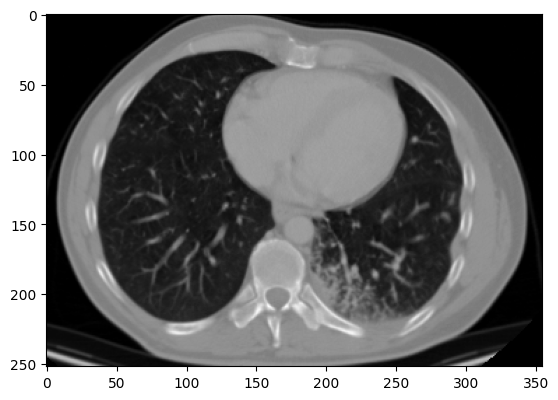

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

datadir = '/content/drive/MyDrive/LungGD'
# iterating over just one element
for img in os.listdir(datadir):
        img_array = cv2.imread(os.path.join(datadir,img) ,cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap='gray')
plt.show()

In [ ]:
img_array.shape

(252, 355)

In [ ]:
array = []
array_small =[]
from tqdm import tqdm
def create_training_data():
        for img in tqdm(list(os.listdir(datadir))):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(datadir+'/'+img ,cv2.IMREAD_COLOR)  # convert to array
                new_array = cv2.resize(img_array, (128, 128))  # resize to normalize data size
                array.append([new_array])
                array_small.append([cv2.resize(img_array, (32,32),
                               interpolation=cv2.INTER_AREA)]) # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
create_training_data()

100%|██████████| 566/566 [00:04<00:00, 128.53it/s]


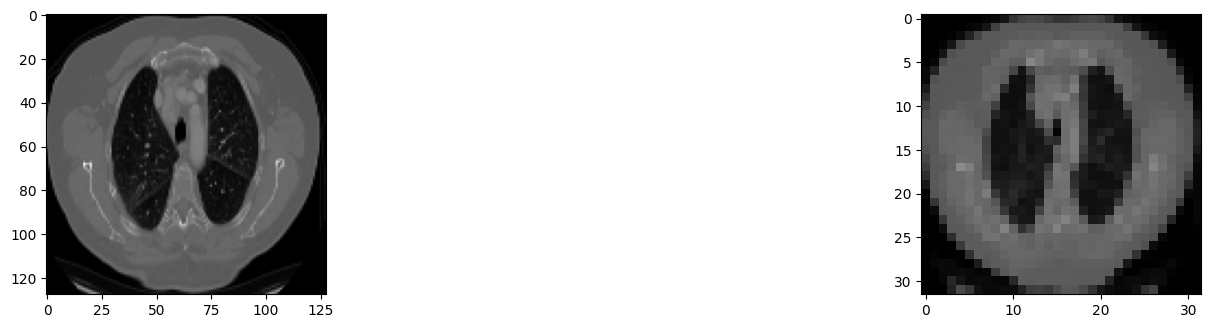

In [ ]:
X =  []
Xs = []
for features in array:
    X.append(features)
for features in array_small:
    Xs.append(features)
plt.figure(figsize=(16, 8))
X = np.array(X).reshape(-1, 128, 128, 3)
Xs = np.array(Xs).reshape(-1, 32, 32, 3)
plt.subplot(231)
plt.imshow(X[0], cmap = 'gray')
plt.subplot(233)
plt.imshow(Xs[0], cmap = 'gray')
plt.show()

In [ ]:
#augmenting the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io
datagen = ImageDataGenerator(
        rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5))

for a in X:
 i = 0
 a = a.reshape((1, ) + a.shape)
 for batch in datagen.flow(a, batch_size=1,  save_to_dir= '/content/drive/MyDrive/LungAug',
 save_prefix='ag', save_format='png'):
  try:
    i += 1
    if i>= 10:
      break
  except Exception:
    print("error")
    pass

100%|██████████| 4326/4326 [00:10<00:00, 394.20it/s]


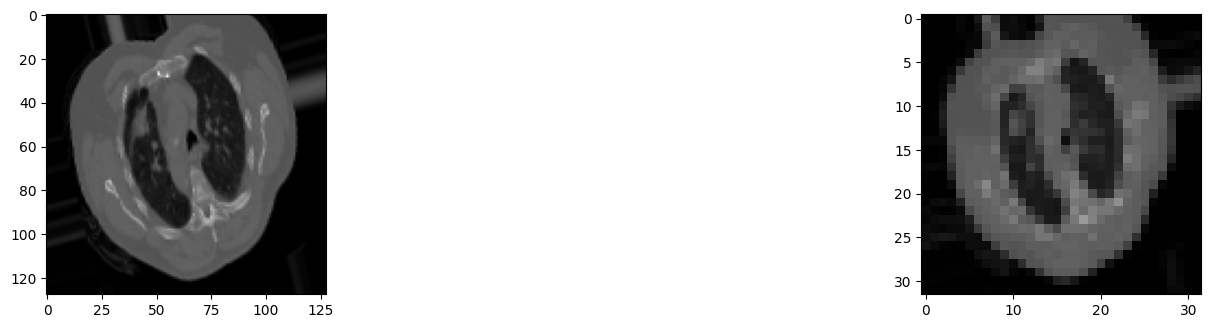

(4892, 128, 128, 3)

In [ ]:
array=[]
array_small=[]
datadir = '/content/drive/MyDrive/LungAug'
create_training_data()

X1 =  []
Xs1 = []
for features in array:
    X1.append(features)
for features in array_small:
    Xs1.append(features)
X1 = np.array(X1).reshape(-1, 128, 128, 3)
Xs1 = np.array(Xs1).reshape(-1, 32, 32, 3)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.imshow(X1[0], cmap = 'gray')
plt.subplot(233)
plt.imshow(Xs1[0], cmap = 'gray')
plt.show()

X=np.concatenate((X,X1), axis = 0)
Xs=np.concatenate((Xs,Xs1), axis=0)
X.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train, y_valid = train_test_split(Xs, X, test_size = 0.33, random_state = 12)
X_train.shape

(3277, 32, 32, 3)

In [ ]:
def res_block(input_dim):
    model = Conv2D(64, (3,3), padding = 'same' )(input_dim)
    model = BatchNormalization()(model)
    model = PReLU(shared_axes = [1,2])(model)
    model = Conv2D(64, (3,3), padding = 'same' )(model)
    model = BatchNormalization()(model)
    return add([input_dim, model])
def upscale_block(input_dim):
    model = Conv2D(256,(3,3), strides=1, padding = 'same')(input_dim)
    model = UpSampling2D(size = (2,2))(model)
    model = PReLU(shared_axes=[1, 2])(model)
    return model
def generator(input, res_range = 1,upscale_range=1):
    model = Conv2D(64,(9,9), strides=1, padding = 'same')(input)
    model = PReLU(shared_axes = [1,2])(model)
    model = Conv2D(64,(9,9), strides=1, padding = 'same')(input)
    model = PReLU(shared_axes = [1,2])(model)
    model1 = model
    for i in range(res_range):
        model = res_block(model)
        model = res_block(model)
    model = Conv2D(64, (3,3), padding = 'same' )(model)
    model = BatchNormalization()(model)
    model = Conv2D(64, (3,3), padding = 'same' )(model)
    model = BatchNormalization()(model)
    model = add([model,model1])
    for i in range(upscale_range):
        model  =upscale_block(model)
        model  =upscale_block(model)
    output = Conv2D(3, (9,9),  padding='same')(model)
    return Model(input, output)

In [ ]:
def discrim_block(input_dim, fmaps = 64, strides = 1):
    model = Conv2D(fmaps, (3,3), padding = 'same', strides  = strides)(input_dim)
    model = BatchNormalization()(model)
    model = LeakyReLU()(model)
    return model
def discriminator(input):
    model = Conv2D(64,(3,3),padding='same')(input)
    model = LeakyReLU()(model)
    model = discrim_block(model, strides = 2)
    model = discrim_block(model, fmaps  = 128)
    model = discrim_block(model, fmaps = 128, strides = 2)
    model = discrim_block(model, fmaps=256)
    model = discrim_block(model, fmaps=256, strides=2)
    model = discrim_block(model, fmaps=512)
    model = discrim_block(model, fmaps=512, strides=2)
    model = Flatten()(model)
    model = Dense(1024)(model)
    model = Flatten()(model)
    model = Dense(1024)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    out = Dense(1, activation='sigmoid')(model)
    return Model(input, out)

In [ ]:
#introducing vgg19 layer
from tensorflow.keras.applications.vgg19 import VGG19
def build_vgg(hr_shape):
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


# Define combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [ ]:
hr_shape = (y_train.shape[1], y_train.shape[2], y_train.shape[3])
lr_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = generator(lr_ip, res_range = 16, upscale_range=2)
generator.summary()

discriminator = discriminator(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 32, 32, 64)           64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['p_re_lu[0][0]']             
                                                                                              

In [ ]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 128, 128, 3)          2044291   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 1)                    3824928   ['model[0][0]']               
                                                          1                                 

In [ ]:
batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(y_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(y_train[start_idx:end_idx])
    train_lr_batches.append(X_train[start_idx:end_idx])

In [ ]:
epochs = 2
#Enumerate training over epochs
for e in range(epochs):

    fake_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size,1))

    g_losses = []
    d_losses = []

    #Enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b]

        fake_imgs = generator.predict_on_batch(lr_imgs)

        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        discriminator.trainable = False
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)
        image_features = vgg.predict(hr_imgs)
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 5 == 0:
        generator.save("gen_e_"+ str(e+1) +".h5")


generator.save("generator"+ str(e+1) +".h5")

  0%|          | 0/3277 [00:00<?, ?it/s]

1/1 [==============================] - 0s 69ms/step


  0%|          | 1/3277 [00:00<24:03,  2.27it/s]

1/1 [==============================] - 0s 70ms/step


  0%|          | 2/3277 [00:00<23:31,  2.32it/s]

1/1 [==============================] - 0s 65ms/step


  0%|          | 3/3277 [00:01<24:40,  2.21it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 4/3277 [00:01<20:25,  2.67it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 5/3277 [00:01<18:05,  3.02it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 6/3277 [00:02<16:46,  3.25it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 7/3277 [00:02<17:05,  3.19it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 8/3277 [00:02<16:50,  3.23it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 9/3277 [00:02<15:15,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 10/3277 [00:03<14:11,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 11/3277 [00:03<13:02,  4.17it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 12/3277 [00:03<12:10,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 13/3277 [00:03<11:31,  4.72it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 14/3277 [00:03<11:07,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 15/3277 [00:04<10:43,  5.07it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 16/3277 [00:04<10:27,  5.19it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 17/3277 [00:04<10:12,  5.32it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 18/3277 [00:04<10:05,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 19/3277 [00:04<09:48,  5.54it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 20/3277 [00:04<09:43,  5.58it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 21/3277 [00:05<10:15,  5.29it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 22/3277 [00:05<10:06,  5.37it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 23/3277 [00:05<09:55,  5.46it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 24/3277 [00:05<09:53,  5.48it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 25/3277 [00:05<10:14,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 26/3277 [00:06<10:22,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 27/3277 [00:06<10:00,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 28/3277 [00:06<09:56,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 29/3277 [00:06<09:36,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 30/3277 [00:06<09:36,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 31/3277 [00:07<09:33,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 32/3277 [00:07<09:51,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 33/3277 [00:07<09:41,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 34/3277 [00:07<09:37,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 35/3277 [00:07<10:02,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 36/3277 [00:07<09:50,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 37/3277 [00:08<09:36,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 38/3277 [00:08<09:44,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 39/3277 [00:08<09:42,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 40/3277 [00:08<09:32,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 41/3277 [00:08<09:20,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 42/3277 [00:08<09:10,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 43/3277 [00:09<09:05,  5.93it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 44/3277 [00:09<09:02,  5.96it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 45/3277 [00:09<08:51,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 46/3277 [00:09<09:15,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 47/3277 [00:09<09:07,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 48/3277 [00:09<08:56,  6.02it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 49/3277 [00:10<08:46,  6.13it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 50/3277 [00:10<08:48,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 51/3277 [00:10<08:45,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 52/3277 [00:10<08:39,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 53/3277 [00:10<08:47,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 54/3277 [00:10<08:51,  6.07it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 55/3277 [00:11<08:50,  6.07it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 56/3277 [00:11<08:52,  6.05it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 57/3277 [00:11<08:50,  6.07it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 58/3277 [00:11<08:39,  6.19it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 59/3277 [00:11<08:39,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 60/3277 [00:11<08:39,  6.19it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 61/3277 [00:12<08:58,  5.97it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 62/3277 [00:12<08:52,  6.04it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 63/3277 [00:12<09:13,  5.81it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 64/3277 [00:12<09:24,  5.69it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 65/3277 [00:12<09:58,  5.37it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 66/3277 [00:13<10:34,  5.06it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 67/3277 [00:13<10:42,  5.00it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 68/3277 [00:13<10:58,  4.87it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 69/3277 [00:13<11:25,  4.68it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 70/3277 [00:13<11:45,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 71/3277 [00:14<11:45,  4.55it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 72/3277 [00:14<11:49,  4.52it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 73/3277 [00:14<11:58,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 74/3277 [00:14<11:56,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 75/3277 [00:15<11:51,  4.50it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 76/3277 [00:15<12:10,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 77/3277 [00:15<12:23,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 78/3277 [00:15<12:30,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 79/3277 [00:16<12:34,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 80/3277 [00:16<11:35,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 81/3277 [00:16<10:55,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 82/3277 [00:16<10:30,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 83/3277 [00:16<10:05,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 84/3277 [00:16<10:01,  5.31it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 85/3277 [00:17<09:43,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 86/3277 [00:17<09:40,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 87/3277 [00:17<09:25,  5.64it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 88/3277 [00:17<09:12,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 89/3277 [00:17<08:56,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 90/3277 [00:17<09:03,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 91/3277 [00:18<09:04,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 92/3277 [00:18<08:59,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 93/3277 [00:18<09:16,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 94/3277 [00:18<09:06,  5.83it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 95/3277 [00:18<09:27,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 96/3277 [00:18<09:07,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 97/3277 [00:19<08:56,  5.93it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 98/3277 [00:19<08:47,  6.02it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 99/3277 [00:19<09:11,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 100/3277 [00:19<08:57,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 101/3277 [00:19<08:44,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 102/3277 [00:19<08:40,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 103/3277 [00:20<08:33,  6.18it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 104/3277 [00:20<08:35,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 105/3277 [00:20<08:33,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 106/3277 [00:20<08:46,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 107/3277 [00:20<08:43,  6.05it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 108/3277 [00:20<08:49,  5.99it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 109/3277 [00:21<08:52,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 110/3277 [00:21<08:49,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 111/3277 [00:21<08:41,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 112/3277 [00:21<09:10,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 113/3277 [00:21<08:59,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 114/3277 [00:21<08:54,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 115/3277 [00:22<08:58,  5.88it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 116/3277 [00:22<08:45,  6.02it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 117/3277 [00:22<08:41,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 118/3277 [00:22<08:45,  6.02it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 119/3277 [00:22<08:41,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 120/3277 [00:22<08:35,  6.12it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 121/3277 [00:23<08:38,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 122/3277 [00:23<08:36,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 123/3277 [00:23<09:06,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 124/3277 [00:23<09:06,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 125/3277 [00:23<08:51,  5.93it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 126/3277 [00:23<08:55,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 127/3277 [00:24<08:47,  5.97it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 128/3277 [00:24<08:35,  6.10it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 129/3277 [00:24<08:27,  6.20it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 130/3277 [00:24<08:34,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 131/3277 [00:24<08:35,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 132/3277 [00:24<08:36,  6.09it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 133/3277 [00:25<08:37,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 134/3277 [00:25<08:34,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 135/3277 [00:25<08:39,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 136/3277 [00:25<08:43,  6.00it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 137/3277 [00:25<08:36,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 138/3277 [00:25<08:30,  6.15it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 139/3277 [00:26<09:02,  5.78it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 140/3277 [00:26<09:55,  5.27it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 141/3277 [00:26<10:31,  4.97it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 142/3277 [00:26<11:00,  4.74it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 143/3277 [00:27<11:11,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 144/3277 [00:27<11:24,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 145/3277 [00:27<11:31,  4.53it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 146/3277 [00:27<11:51,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 147/3277 [00:27<11:55,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 148/3277 [00:28<11:59,  4.35it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 149/3277 [00:28<12:09,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 150/3277 [00:28<11:53,  4.38it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 151/3277 [00:28<12:14,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 152/3277 [00:29<12:27,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 153/3277 [00:29<12:25,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 154/3277 [00:29<11:55,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 155/3277 [00:29<11:29,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 156/3277 [00:29<10:53,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 157/3277 [00:30<10:30,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 158/3277 [00:30<10:13,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 159/3277 [00:30<09:57,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 160/3277 [00:30<09:46,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 161/3277 [00:30<09:44,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 162/3277 [00:31<09:49,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 163/3277 [00:31<09:48,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 164/3277 [00:31<09:50,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 165/3277 [00:31<09:37,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 166/3277 [00:31<09:44,  5.32it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 167/3277 [00:32<09:52,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 168/3277 [00:32<09:58,  5.19it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 169/3277 [00:32<09:51,  5.26it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 170/3277 [00:32<09:36,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 171/3277 [00:32<09:25,  5.49it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 172/3277 [00:32<09:49,  5.26it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 173/3277 [00:33<09:45,  5.30it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 174/3277 [00:33<09:34,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 175/3277 [00:33<09:28,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 176/3277 [00:33<09:11,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 177/3277 [00:33<09:11,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 178/3277 [00:34<09:29,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 179/3277 [00:34<09:13,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 180/3277 [00:34<09:03,  5.70it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 181/3277 [00:34<09:05,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 182/3277 [00:34<09:00,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 183/3277 [00:34<09:02,  5.71it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 184/3277 [00:35<09:03,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 185/3277 [00:35<08:51,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 186/3277 [00:35<08:45,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 187/3277 [00:35<08:47,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 188/3277 [00:35<08:44,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 189/3277 [00:35<09:25,  5.46it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 190/3277 [00:36<09:13,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 191/3277 [00:36<09:10,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 192/3277 [00:36<09:01,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 193/3277 [00:36<08:56,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 194/3277 [00:36<08:48,  5.83it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 195/3277 [00:37<08:51,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 196/3277 [00:37<08:52,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 197/3277 [00:37<09:13,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 198/3277 [00:37<08:54,  5.76it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 199/3277 [00:37<08:49,  5.81it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 200/3277 [00:37<08:51,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 201/3277 [00:38<08:57,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 202/3277 [00:38<08:58,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 203/3277 [00:38<08:45,  5.85it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 204/3277 [00:38<08:38,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 205/3277 [00:38<08:52,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 206/3277 [00:38<08:53,  5.75it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 207/3277 [00:39<08:50,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 208/3277 [00:39<08:39,  5.91it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 209/3277 [00:39<08:38,  5.91it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 210/3277 [00:39<09:16,  5.51it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 211/3277 [00:39<10:13,  5.00it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▋         | 212/3277 [00:40<10:46,  4.74it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 213/3277 [00:40<11:10,  4.57it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 214/3277 [00:40<11:18,  4.52it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 215/3277 [00:40<11:46,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 216/3277 [00:41<12:08,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 217/3277 [00:41<12:23,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 218/3277 [00:41<12:05,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 219/3277 [00:41<11:52,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 220/3277 [00:42<12:15,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 221/3277 [00:42<12:40,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 222/3277 [00:42<12:42,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 223/3277 [00:42<12:40,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 224/3277 [00:43<11:59,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 225/3277 [00:43<11:15,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 226/3277 [00:43<10:49,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 227/3277 [00:43<10:17,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 228/3277 [00:43<09:54,  5.13it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 229/3277 [00:43<10:05,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 230/3277 [00:44<09:43,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 231/3277 [00:44<09:44,  5.21it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 232/3277 [00:44<09:28,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 233/3277 [00:44<09:44,  5.21it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 234/3277 [00:44<09:24,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 235/3277 [00:45<09:37,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 236/3277 [00:45<09:31,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 237/3277 [00:45<09:21,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 238/3277 [00:45<09:20,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 239/3277 [00:45<09:12,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 240/3277 [00:45<09:11,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 241/3277 [00:46<08:59,  5.63it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 242/3277 [00:46<09:24,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 243/3277 [00:46<09:06,  5.55it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 244/3277 [00:46<09:14,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 245/3277 [00:46<09:08,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 246/3277 [00:47<08:54,  5.67it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 247/3277 [00:47<08:53,  5.68it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 248/3277 [00:47<08:48,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 249/3277 [00:47<08:35,  5.87it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 250/3277 [00:47<08:27,  5.96it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 251/3277 [00:47<08:19,  6.06it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 252/3277 [00:48<08:45,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 253/3277 [00:48<08:37,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 254/3277 [00:48<08:32,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 255/3277 [00:48<08:25,  5.98it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 256/3277 [00:48<08:21,  6.03it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 257/3277 [00:48<08:12,  6.13it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 258/3277 [00:49<08:38,  5.82it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 259/3277 [00:49<08:28,  5.93it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 260/3277 [00:49<08:25,  5.97it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 261/3277 [00:49<08:50,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 262/3277 [00:49<08:37,  5.82it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 263/3277 [00:49<08:37,  5.83it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 264/3277 [00:50<08:28,  5.93it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 265/3277 [00:50<08:27,  5.93it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 266/3277 [00:50<08:34,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 267/3277 [00:50<08:25,  5.95it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 268/3277 [00:50<08:24,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 269/3277 [00:50<08:56,  5.61it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 270/3277 [00:51<08:50,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 271/3277 [00:51<08:41,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 272/3277 [00:51<09:04,  5.52it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 273/3277 [00:51<08:51,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 274/3277 [00:51<08:37,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 275/3277 [00:51<08:34,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 276/3277 [00:52<08:36,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 277/3277 [00:52<08:38,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 278/3277 [00:52<08:44,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 279/3277 [00:52<08:34,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 280/3277 [00:52<08:29,  5.88it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 281/3277 [00:53<09:31,  5.24it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 282/3277 [00:53<10:04,  4.96it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 283/3277 [00:53<10:23,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 284/3277 [00:53<10:40,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 285/3277 [00:54<11:00,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 286/3277 [00:54<11:13,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 287/3277 [00:54<11:13,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 288/3277 [00:54<11:03,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 289/3277 [00:54<11:25,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 290/3277 [00:55<11:32,  4.32it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 291/3277 [00:55<11:37,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 292/3277 [00:55<11:27,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 293/3277 [00:55<11:41,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 294/3277 [00:56<11:37,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 295/3277 [00:56<11:47,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 296/3277 [00:56<11:09,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 297/3277 [00:56<10:32,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 298/3277 [00:56<09:59,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 299/3277 [00:57<09:44,  5.10it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 300/3277 [00:57<09:18,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 301/3277 [00:57<09:13,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 302/3277 [00:57<09:06,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 303/3277 [00:57<08:56,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 304/3277 [00:57<08:58,  5.52it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 305/3277 [00:58<08:48,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 306/3277 [00:58<09:05,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 307/3277 [00:58<09:11,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 308/3277 [00:58<09:02,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 309/3277 [00:58<08:48,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 310/3277 [00:59<08:36,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 311/3277 [00:59<08:35,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 312/3277 [00:59<08:22,  5.90it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 313/3277 [00:59<08:22,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 314/3277 [00:59<08:27,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 315/3277 [00:59<08:19,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 316/3277 [01:00<08:17,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 317/3277 [01:00<08:42,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 318/3277 [01:00<08:30,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 319/3277 [01:00<08:49,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 320/3277 [01:00<08:36,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 321/3277 [01:00<08:31,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 322/3277 [01:01<08:20,  5.90it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 323/3277 [01:01<08:12,  6.00it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 324/3277 [01:01<08:22,  5.88it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 325/3277 [01:01<08:42,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 326/3277 [01:01<08:32,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 327/3277 [01:01<08:19,  5.91it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 328/3277 [01:02<08:35,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 329/3277 [01:02<08:29,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 330/3277 [01:02<08:35,  5.72it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 331/3277 [01:02<08:38,  5.68it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 332/3277 [01:02<08:30,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 333/3277 [01:03<08:26,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 334/3277 [01:03<08:21,  5.87it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 335/3277 [01:03<08:38,  5.68it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 336/3277 [01:03<08:31,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 337/3277 [01:03<08:31,  5.75it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 338/3277 [01:03<08:21,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 339/3277 [01:04<08:15,  5.92it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 340/3277 [01:04<08:30,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 341/3277 [01:04<08:32,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 342/3277 [01:04<08:28,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 343/3277 [01:04<08:28,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 344/3277 [01:04<08:23,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 345/3277 [01:05<08:23,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 346/3277 [01:05<08:14,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 347/3277 [01:05<08:10,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 348/3277 [01:05<08:38,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 349/3277 [01:05<08:39,  5.64it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 350/3277 [01:05<08:29,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 351/3277 [01:06<08:25,  5.78it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 352/3277 [01:06<08:28,  5.76it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 353/3277 [01:06<09:08,  5.33it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 354/3277 [01:06<10:14,  4.75it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 355/3277 [01:07<10:44,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 356/3277 [01:07<10:46,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 357/3277 [01:07<11:03,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 358/3277 [01:07<10:53,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 359/3277 [01:07<11:03,  4.40it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 360/3277 [01:08<11:26,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 361/3277 [01:08<11:22,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 362/3277 [01:08<11:36,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 363/3277 [01:08<11:41,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 364/3277 [01:09<11:33,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 365/3277 [01:09<11:47,  4.12it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 366/3277 [01:09<11:58,  4.05it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 367/3277 [01:09<12:03,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 368/3277 [01:10<11:21,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 369/3277 [01:10<10:37,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 370/3277 [01:10<10:20,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 371/3277 [01:10<09:59,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 372/3277 [01:10<09:34,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 373/3277 [01:11<09:28,  5.11it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 374/3277 [01:11<09:12,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 375/3277 [01:11<09:02,  5.34it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 376/3277 [01:11<09:00,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 377/3277 [01:11<08:58,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 378/3277 [01:11<09:08,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 379/3277 [01:12<09:13,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 380/3277 [01:12<08:56,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 381/3277 [01:12<08:51,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 382/3277 [01:12<08:43,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 383/3277 [01:12<09:03,  5.32it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 384/3277 [01:13<09:48,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 385/3277 [01:13<10:14,  4.70it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 386/3277 [01:13<10:14,  4.70it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 387/3277 [01:13<10:33,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 388/3277 [01:14<11:15,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 389/3277 [01:14<11:45,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 390/3277 [01:14<11:54,  4.04it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 391/3277 [01:14<12:05,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 392/3277 [01:15<12:07,  3.96it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 393/3277 [01:15<12:03,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 394/3277 [01:15<12:14,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 395/3277 [01:15<12:27,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 396/3277 [01:16<12:38,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 397/3277 [01:16<12:25,  3.86it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 398/3277 [01:16<11:27,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 399/3277 [01:16<10:56,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 400/3277 [01:16<10:10,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 401/3277 [01:17<09:50,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 402/3277 [01:17<09:30,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 403/3277 [01:17<09:11,  5.21it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 404/3277 [01:17<09:01,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 405/3277 [01:17<08:55,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 406/3277 [01:18<08:44,  5.48it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 407/3277 [01:18<08:58,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 408/3277 [01:18<08:55,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 409/3277 [01:18<08:47,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 410/3277 [01:18<08:47,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 411/3277 [01:19<08:40,  5.50it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 412/3277 [01:19<08:54,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 413/3277 [01:19<08:46,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 414/3277 [01:19<08:50,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 415/3277 [01:19<08:56,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 416/3277 [01:19<08:44,  5.46it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 417/3277 [01:20<09:24,  5.07it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 418/3277 [01:20<10:07,  4.71it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 419/3277 [01:20<10:26,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 420/3277 [01:20<10:42,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 421/3277 [01:21<10:57,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 422/3277 [01:21<11:16,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 423/3277 [01:21<11:32,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 424/3277 [01:21<11:28,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 425/3277 [01:22<11:30,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 426/3277 [01:22<11:51,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 427/3277 [01:22<11:31,  4.12it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 428/3277 [01:22<11:34,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 429/3277 [01:23<11:48,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 430/3277 [01:23<11:47,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 431/3277 [01:23<11:08,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 432/3277 [01:23<10:22,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 433/3277 [01:23<09:48,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 434/3277 [01:24<09:28,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 435/3277 [01:24<09:16,  5.11it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 436/3277 [01:24<09:22,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 437/3277 [01:24<09:10,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 438/3277 [01:24<09:06,  5.20it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 439/3277 [01:25<08:54,  5.31it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 440/3277 [01:25<08:41,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 441/3277 [01:25<08:39,  5.46it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 442/3277 [01:25<08:28,  5.58it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 443/3277 [01:25<08:51,  5.33it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 444/3277 [01:25<08:37,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 445/3277 [01:26<08:41,  5.43it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 446/3277 [01:26<08:33,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 447/3277 [01:26<08:28,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 448/3277 [01:26<08:31,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 449/3277 [01:26<08:21,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 450/3277 [01:27<08:18,  5.67it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 451/3277 [01:27<08:16,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 452/3277 [01:27<08:14,  5.71it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 453/3277 [01:27<08:49,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 454/3277 [01:27<08:38,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 455/3277 [01:27<08:32,  5.51it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 456/3277 [01:28<08:48,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 457/3277 [01:28<08:32,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 458/3277 [01:28<08:27,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 459/3277 [01:28<08:21,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 460/3277 [01:28<08:13,  5.70it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 461/3277 [01:29<08:12,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 462/3277 [01:29<08:07,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 463/3277 [01:29<08:05,  5.80it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 464/3277 [01:29<08:09,  5.74it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 465/3277 [01:29<08:10,  5.74it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 466/3277 [01:29<08:30,  5.50it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 467/3277 [01:30<08:23,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 468/3277 [01:30<08:15,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 469/3277 [01:30<08:34,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 470/3277 [01:30<08:25,  5.55it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 471/3277 [01:30<08:36,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 472/3277 [01:30<08:31,  5.49it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 473/3277 [01:31<08:32,  5.47it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 474/3277 [01:31<08:22,  5.58it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 475/3277 [01:31<08:39,  5.39it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 476/3277 [01:31<08:31,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 477/3277 [01:31<08:33,  5.45it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 478/3277 [01:32<08:28,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 479/3277 [01:32<08:14,  5.65it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 480/3277 [01:32<08:30,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 481/3277 [01:32<08:21,  5.58it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 482/3277 [01:32<08:18,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 483/3277 [01:32<08:29,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 484/3277 [01:33<08:12,  5.68it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 485/3277 [01:33<08:13,  5.66it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 486/3277 [01:33<08:28,  5.49it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 487/3277 [01:33<09:22,  4.96it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 488/3277 [01:33<09:37,  4.83it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 489/3277 [01:34<09:58,  4.66it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 490/3277 [01:34<10:05,  4.60it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 491/3277 [01:34<10:23,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 492/3277 [01:34<10:45,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 493/3277 [01:35<10:58,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 494/3277 [01:35<11:10,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 495/3277 [01:35<11:37,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 496/3277 [01:35<11:31,  4.02it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 497/3277 [01:36<11:35,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 498/3277 [01:36<11:42,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 499/3277 [01:36<11:25,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 500/3277 [01:36<11:13,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 501/3277 [01:37<10:31,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 502/3277 [01:37<10:20,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 503/3277 [01:37<10:00,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 504/3277 [01:37<09:41,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 505/3277 [01:37<09:28,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 506/3277 [01:38<09:12,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 507/3277 [01:38<09:01,  5.12it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 508/3277 [01:38<08:50,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 509/3277 [01:38<08:48,  5.23it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 510/3277 [01:38<08:35,  5.36it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 511/3277 [01:39<08:35,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 512/3277 [01:39<08:26,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 513/3277 [01:39<08:16,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 514/3277 [01:39<08:05,  5.69it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 515/3277 [01:39<07:59,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 516/3277 [01:39<07:58,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 517/3277 [01:40<07:58,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 518/3277 [01:40<07:58,  5.77it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 519/3277 [01:40<07:56,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 520/3277 [01:40<07:50,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 521/3277 [01:40<07:53,  5.82it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 522/3277 [01:40<08:02,  5.71it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 523/3277 [01:41<07:51,  5.85it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 524/3277 [01:41<08:07,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 525/3277 [01:41<08:04,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 526/3277 [01:41<08:08,  5.64it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 527/3277 [01:41<08:07,  5.65it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 528/3277 [01:41<08:09,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 529/3277 [01:42<08:09,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 530/3277 [01:42<08:01,  5.70it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 531/3277 [01:42<07:57,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 532/3277 [01:42<07:54,  5.78it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 533/3277 [01:42<08:13,  5.57it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 534/3277 [01:43<08:06,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 535/3277 [01:43<07:57,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 536/3277 [01:43<07:55,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 537/3277 [01:43<08:01,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 538/3277 [01:43<08:06,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 539/3277 [01:43<08:12,  5.56it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 540/3277 [01:44<08:30,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 541/3277 [01:44<08:20,  5.47it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 542/3277 [01:44<08:16,  5.51it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 543/3277 [01:44<08:30,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 544/3277 [01:44<08:26,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 545/3277 [01:45<08:22,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 546/3277 [01:45<08:11,  5.56it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 547/3277 [01:45<08:10,  5.57it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 548/3277 [01:45<08:23,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 549/3277 [01:45<08:29,  5.36it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 550/3277 [01:45<08:29,  5.35it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 551/3277 [01:46<08:22,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 552/3277 [01:46<08:11,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 553/3277 [01:46<08:28,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 554/3277 [01:46<08:33,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 555/3277 [01:46<08:19,  5.45it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 556/3277 [01:47<09:15,  4.90it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 557/3277 [01:47<09:35,  4.72it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 558/3277 [01:47<10:03,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 559/3277 [01:47<10:02,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 560/3277 [01:48<10:27,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 561/3277 [01:48<10:30,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 562/3277 [01:48<10:25,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 563/3277 [01:48<10:44,  4.21it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 564/3277 [01:49<11:19,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 565/3277 [01:49<11:32,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 566/3277 [01:49<11:35,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 567/3277 [01:49<11:24,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 568/3277 [01:50<11:23,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 569/3277 [01:50<11:24,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 570/3277 [01:50<11:27,  3.94it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 571/3277 [01:50<10:48,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 572/3277 [01:51<10:10,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 573/3277 [01:51<09:56,  4.53it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 574/3277 [01:51<09:50,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 575/3277 [01:51<09:39,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 576/3277 [01:51<09:30,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 577/3277 [01:52<09:13,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 578/3277 [01:52<09:04,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 579/3277 [01:52<08:51,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 580/3277 [01:52<08:47,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 581/3277 [01:52<08:42,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 582/3277 [01:52<08:29,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 583/3277 [01:53<08:29,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 584/3277 [01:53<08:40,  5.17it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 585/3277 [01:53<08:28,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 586/3277 [01:53<08:44,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 587/3277 [01:53<08:39,  5.18it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 588/3277 [01:54<08:56,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 589/3277 [01:54<08:41,  5.15it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 590/3277 [01:54<08:42,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 591/3277 [01:54<08:36,  5.20it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 592/3277 [01:54<08:25,  5.31it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 593/3277 [01:55<08:20,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 594/3277 [01:55<08:16,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 595/3277 [01:55<08:14,  5.43it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 596/3277 [01:55<08:15,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 597/3277 [01:55<08:20,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 598/3277 [01:56<08:17,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 599/3277 [01:56<08:18,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 600/3277 [01:56<08:12,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 601/3277 [01:56<08:09,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 602/3277 [01:56<08:06,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 603/3277 [01:56<08:12,  5.43it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 604/3277 [01:57<08:00,  5.56it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 605/3277 [01:57<08:05,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 606/3277 [01:57<08:04,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 607/3277 [01:57<07:58,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 608/3277 [01:57<08:02,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 609/3277 [01:57<07:58,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 610/3277 [01:58<08:18,  5.35it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 611/3277 [01:58<08:14,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 612/3277 [01:58<08:30,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 613/3277 [01:58<08:38,  5.14it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 614/3277 [01:58<08:23,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 615/3277 [01:59<08:15,  5.37it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 616/3277 [01:59<08:15,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 617/3277 [01:59<08:04,  5.49it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 618/3277 [01:59<08:08,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 619/3277 [01:59<07:58,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 620/3277 [02:00<07:54,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 621/3277 [02:00<08:06,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 622/3277 [02:00<08:06,  5.45it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 623/3277 [02:00<08:01,  5.51it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 624/3277 [02:00<08:43,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 625/3277 [02:01<10:03,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 626/3277 [02:01<10:17,  4.29it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 627/3277 [02:01<10:38,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 628/3277 [02:01<10:40,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 629/3277 [02:02<10:48,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 630/3277 [02:02<10:48,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 631/3277 [02:02<11:11,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 632/3277 [02:02<11:16,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 633/3277 [02:03<11:08,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 634/3277 [02:03<11:17,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 635/3277 [02:03<11:32,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 636/3277 [02:03<11:33,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 637/3277 [02:04<11:16,  3.90it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 638/3277 [02:04<10:39,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 639/3277 [02:04<10:17,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 640/3277 [02:04<09:46,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 641/3277 [02:04<09:19,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 642/3277 [02:05<09:00,  4.88it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 643/3277 [02:05<08:49,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 644/3277 [02:05<08:39,  5.07it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 645/3277 [02:05<08:39,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 646/3277 [02:05<08:30,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 647/3277 [02:06<08:20,  5.25it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 648/3277 [02:06<08:23,  5.22it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 649/3277 [02:06<08:16,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 650/3277 [02:06<08:29,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 651/3277 [02:06<08:28,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 652/3277 [02:07<08:17,  5.27it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 653/3277 [02:07<08:14,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 654/3277 [02:07<08:09,  5.36it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 655/3277 [02:07<08:07,  5.37it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 656/3277 [02:07<08:14,  5.30it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 657/3277 [02:08<08:25,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 658/3277 [02:08<08:13,  5.30it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 659/3277 [02:08<08:13,  5.30it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 660/3277 [02:08<08:17,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 661/3277 [02:08<08:12,  5.31it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 662/3277 [02:08<08:11,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 663/3277 [02:09<08:00,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 664/3277 [02:09<07:54,  5.50it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 665/3277 [02:09<07:52,  5.53it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 666/3277 [02:09<08:03,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 667/3277 [02:09<08:00,  5.43it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 668/3277 [02:10<07:54,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 669/3277 [02:10<07:49,  5.55it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 670/3277 [02:10<07:50,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 671/3277 [02:10<07:45,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 672/3277 [02:10<07:45,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 673/3277 [02:10<07:39,  5.66it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 674/3277 [02:11<07:49,  5.55it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 675/3277 [02:11<07:47,  5.56it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 676/3277 [02:11<07:41,  5.63it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 677/3277 [02:11<07:56,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 678/3277 [02:11<07:47,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 679/3277 [02:12<07:44,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 680/3277 [02:12<07:41,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 681/3277 [02:12<07:32,  5.74it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 682/3277 [02:12<07:26,  5.82it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 683/3277 [02:12<07:29,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 684/3277 [02:12<07:32,  5.73it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 685/3277 [02:13<07:47,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 686/3277 [02:13<07:58,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 687/3277 [02:13<07:44,  5.57it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 688/3277 [02:13<07:55,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 689/3277 [02:13<07:49,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 690/3277 [02:13<07:51,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 691/3277 [02:14<08:11,  5.27it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 692/3277 [02:14<08:39,  4.98it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 693/3277 [02:14<09:24,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 694/3277 [02:14<09:42,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 695/3277 [02:15<10:05,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 696/3277 [02:15<10:03,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 697/3277 [02:15<09:54,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 698/3277 [02:15<10:09,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 699/3277 [02:16<10:27,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 700/3277 [02:16<10:31,  4.08it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 701/3277 [02:16<10:38,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 702/3277 [02:16<10:41,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 703/3277 [02:17<10:49,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 704/3277 [02:17<10:54,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 705/3277 [02:17<10:45,  3.98it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 706/3277 [02:17<10:14,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 707/3277 [02:18<09:43,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 708/3277 [02:18<09:11,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 709/3277 [02:18<09:07,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 710/3277 [02:18<08:47,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 711/3277 [02:18<08:38,  4.95it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 712/3277 [02:19<08:43,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 713/3277 [02:19<08:29,  5.03it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 714/3277 [02:19<08:19,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 715/3277 [02:19<08:22,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 716/3277 [02:19<08:28,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 717/3277 [02:20<08:24,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 718/3277 [02:20<08:13,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 719/3277 [02:20<08:06,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 720/3277 [02:20<08:04,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 721/3277 [02:20<08:12,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 722/3277 [02:20<08:09,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 723/3277 [02:21<08:02,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 724/3277 [02:21<07:52,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 725/3277 [02:21<07:53,  5.39it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 726/3277 [02:21<07:43,  5.51it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 727/3277 [02:21<07:57,  5.34it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 728/3277 [02:22<07:53,  5.38it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 729/3277 [02:22<07:57,  5.34it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 730/3277 [02:22<07:43,  5.50it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 731/3277 [02:22<07:31,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 732/3277 [02:22<07:52,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 733/3277 [02:22<07:55,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 734/3277 [02:23<07:51,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 735/3277 [02:23<07:45,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 736/3277 [02:23<07:41,  5.51it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 737/3277 [02:23<07:44,  5.47it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 738/3277 [02:23<07:37,  5.55it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 739/3277 [02:24<07:40,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 740/3277 [02:24<07:41,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 741/3277 [02:24<08:01,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 742/3277 [02:24<07:54,  5.35it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 743/3277 [02:24<08:05,  5.22it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 744/3277 [02:25<08:08,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 745/3277 [02:25<08:00,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 746/3277 [02:25<07:57,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 747/3277 [02:25<07:58,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 748/3277 [02:25<07:54,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 749/3277 [02:25<07:51,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 750/3277 [02:26<07:50,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 751/3277 [02:26<07:50,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 752/3277 [02:26<07:43,  5.45it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 753/3277 [02:26<07:41,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 754/3277 [02:26<07:36,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 755/3277 [02:27<07:47,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 756/3277 [02:27<07:38,  5.50it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 757/3277 [02:27<07:34,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 758/3277 [02:27<07:39,  5.49it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 759/3277 [02:27<08:06,  5.18it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 760/3277 [02:28<09:18,  4.51it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 761/3277 [02:28<09:37,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 762/3277 [02:28<10:01,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 763/3277 [02:28<10:33,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 764/3277 [02:29<10:49,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 765/3277 [02:29<10:48,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 766/3277 [02:29<10:43,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 767/3277 [02:29<10:53,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 768/3277 [02:30<10:49,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 769/3277 [02:30<10:35,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 770/3277 [02:30<10:41,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 771/3277 [02:30<10:51,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 772/3277 [02:31<10:42,  3.90it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 773/3277 [02:31<10:01,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 774/3277 [02:31<09:22,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 775/3277 [02:31<09:02,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 776/3277 [02:32<08:42,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 777/3277 [02:32<08:27,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 778/3277 [02:32<08:22,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 779/3277 [02:32<08:11,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 780/3277 [02:32<08:09,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 781/3277 [02:32<08:06,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 782/3277 [02:33<08:22,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 783/3277 [02:33<08:11,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 784/3277 [02:33<08:05,  5.13it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 785/3277 [02:33<07:51,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 786/3277 [02:33<07:49,  5.31it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 787/3277 [02:34<07:45,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 788/3277 [02:34<07:54,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 789/3277 [02:34<07:52,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 790/3277 [02:34<07:58,  5.20it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 791/3277 [02:34<07:45,  5.34it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 792/3277 [02:35<07:42,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 793/3277 [02:35<07:54,  5.23it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 794/3277 [02:35<08:11,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 795/3277 [02:35<08:02,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 796/3277 [02:35<07:57,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 797/3277 [02:36<08:07,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 798/3277 [02:36<07:57,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 799/3277 [02:36<08:02,  5.14it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 800/3277 [02:36<08:01,  5.14it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 801/3277 [02:36<08:05,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 802/3277 [02:37<08:26,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 803/3277 [02:37<08:09,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 804/3277 [02:37<08:06,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 805/3277 [02:37<07:57,  5.17it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 806/3277 [02:37<07:57,  5.18it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 807/3277 [02:38<07:52,  5.22it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 808/3277 [02:38<07:53,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 809/3277 [02:38<07:49,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 810/3277 [02:38<07:49,  5.26it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 811/3277 [02:38<08:09,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 812/3277 [02:38<07:59,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 813/3277 [02:39<07:54,  5.19it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 814/3277 [02:39<08:06,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 815/3277 [02:39<08:05,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 816/3277 [02:39<07:56,  5.16it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 817/3277 [02:39<08:09,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 818/3277 [02:40<07:53,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 819/3277 [02:40<08:00,  5.12it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 820/3277 [02:40<07:48,  5.25it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 821/3277 [02:40<07:54,  5.17it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 822/3277 [02:40<08:02,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 823/3277 [02:41<07:59,  5.12it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 824/3277 [02:41<08:09,  5.01it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 825/3277 [02:41<08:51,  4.62it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 826/3277 [02:41<09:15,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 827/3277 [02:42<09:45,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 828/3277 [02:42<09:45,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 829/3277 [02:42<09:54,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 830/3277 [02:42<10:11,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 831/3277 [02:43<10:10,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 832/3277 [02:43<10:07,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 833/3277 [02:43<10:14,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 834/3277 [02:43<10:05,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 835/3277 [02:44<10:04,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 836/3277 [02:44<10:09,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 837/3277 [02:44<10:22,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 838/3277 [02:44<10:26,  3.89it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 839/3277 [02:45<09:40,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 840/3277 [02:45<09:01,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 841/3277 [02:45<08:45,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 842/3277 [02:45<08:23,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 843/3277 [02:45<08:21,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 844/3277 [02:46<08:06,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 845/3277 [02:46<07:53,  5.14it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 846/3277 [02:46<07:43,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 847/3277 [02:46<07:30,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 848/3277 [02:46<07:34,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 849/3277 [02:46<07:29,  5.40it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 850/3277 [02:47<07:44,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 851/3277 [02:47<07:37,  5.31it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 852/3277 [02:47<07:30,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 853/3277 [02:47<07:47,  5.18it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 854/3277 [02:47<07:40,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 855/3277 [02:48<07:50,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 856/3277 [02:48<07:39,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 857/3277 [02:48<07:33,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 858/3277 [02:48<07:50,  5.14it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 859/3277 [02:48<07:44,  5.20it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 860/3277 [02:49<07:35,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 861/3277 [02:49<07:39,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 862/3277 [02:49<07:28,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 863/3277 [02:49<07:23,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 864/3277 [02:49<07:29,  5.37it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 865/3277 [02:50<07:56,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 866/3277 [02:50<07:44,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 867/3277 [02:50<07:34,  5.31it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 868/3277 [02:50<07:38,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 869/3277 [02:50<07:43,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 870/3277 [02:50<07:32,  5.31it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 871/3277 [02:51<07:34,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 872/3277 [02:51<07:27,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 873/3277 [02:51<07:26,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 874/3277 [02:51<07:20,  5.46it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 875/3277 [02:51<07:22,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 876/3277 [02:52<07:24,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 877/3277 [02:52<07:21,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 878/3277 [02:52<07:19,  5.46it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 879/3277 [02:52<07:13,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 880/3277 [02:52<07:16,  5.49it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 881/3277 [02:52<07:29,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 882/3277 [02:53<07:20,  5.43it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 883/3277 [02:53<07:19,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 884/3277 [02:53<07:17,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 885/3277 [02:53<07:20,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 886/3277 [02:53<07:23,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 887/3277 [02:54<07:29,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 888/3277 [02:54<07:35,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 889/3277 [02:54<07:31,  5.29it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 890/3277 [02:54<07:30,  5.30it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 891/3277 [02:54<07:31,  5.29it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 892/3277 [02:55<08:12,  4.84it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 893/3277 [02:55<08:48,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 894/3277 [02:55<09:19,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 895/3277 [02:55<09:52,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 896/3277 [02:56<10:04,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 897/3277 [02:56<09:57,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 898/3277 [02:56<09:59,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 899/3277 [02:56<10:04,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 900/3277 [02:57<10:06,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 901/3277 [02:57<10:30,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 902/3277 [02:57<10:32,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 903/3277 [02:58<10:39,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 904/3277 [02:58<10:28,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 905/3277 [02:58<10:33,  3.74it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 906/3277 [02:58<09:44,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 907/3277 [02:58<09:12,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 908/3277 [02:59<08:51,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 909/3277 [02:59<08:34,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 910/3277 [02:59<08:17,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 911/3277 [02:59<08:07,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 912/3277 [02:59<07:58,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 913/3277 [03:00<08:05,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 914/3277 [03:00<07:56,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 915/3277 [03:00<07:59,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 916/3277 [03:00<07:50,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 917/3277 [03:00<07:52,  5.00it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 918/3277 [03:01<07:51,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 919/3277 [03:01<07:47,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 920/3277 [03:01<07:36,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 921/3277 [03:01<07:33,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 922/3277 [03:01<07:25,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 923/3277 [03:02<07:27,  5.26it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 924/3277 [03:02<07:25,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 925/3277 [03:02<07:28,  5.25it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 926/3277 [03:02<07:28,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 927/3277 [03:02<07:24,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 928/3277 [03:03<07:23,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 929/3277 [03:03<07:25,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 930/3277 [03:03<07:24,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 931/3277 [03:03<07:18,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 932/3277 [03:03<07:21,  5.31it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 933/3277 [03:03<07:38,  5.11it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 934/3277 [03:04<07:29,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 935/3277 [03:04<07:22,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 936/3277 [03:04<07:18,  5.34it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 937/3277 [03:04<07:18,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 938/3277 [03:04<07:17,  5.35it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 939/3277 [03:05<07:11,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 940/3277 [03:05<07:24,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 941/3277 [03:05<07:21,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 942/3277 [03:05<07:16,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 943/3277 [03:05<07:12,  5.40it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 944/3277 [03:06<07:27,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 945/3277 [03:06<07:33,  5.15it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 946/3277 [03:06<07:37,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 947/3277 [03:06<07:32,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 948/3277 [03:06<07:32,  5.14it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 949/3277 [03:07<07:31,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 950/3277 [03:07<07:21,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 951/3277 [03:07<07:33,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 952/3277 [03:07<07:29,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 953/3277 [03:07<07:31,  5.15it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 954/3277 [03:07<07:27,  5.19it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 955/3277 [03:08<07:18,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 956/3277 [03:08<07:24,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 957/3277 [03:08<07:42,  5.01it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 958/3277 [03:08<08:13,  4.70it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 959/3277 [03:09<08:19,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 960/3277 [03:09<08:39,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 961/3277 [03:09<08:39,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 962/3277 [03:09<09:15,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 963/3277 [03:10<09:24,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 964/3277 [03:10<09:38,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 965/3277 [03:10<09:50,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 966/3277 [03:10<10:01,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 967/3277 [03:11<10:07,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 968/3277 [03:11<10:02,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 969/3277 [03:11<10:01,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 970/3277 [03:11<10:07,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 971/3277 [03:12<09:55,  3.87it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 972/3277 [03:12<09:29,  4.04it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 973/3277 [03:12<09:02,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 974/3277 [03:12<08:42,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 975/3277 [03:12<08:24,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 976/3277 [03:13<08:12,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 977/3277 [03:13<07:57,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 978/3277 [03:13<07:55,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 979/3277 [03:13<07:49,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 980/3277 [03:13<07:41,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 981/3277 [03:14<07:42,  4.97it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 982/3277 [03:14<07:42,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 983/3277 [03:14<07:48,  4.89it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 984/3277 [03:14<07:52,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 985/3277 [03:14<07:43,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 986/3277 [03:15<07:39,  4.99it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 987/3277 [03:15<07:34,  5.04it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 988/3277 [03:15<07:33,  5.05it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 989/3277 [03:15<07:36,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 990/3277 [03:15<07:32,  5.06it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 991/3277 [03:16<07:28,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 992/3277 [03:16<07:23,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 993/3277 [03:16<07:17,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 994/3277 [03:16<07:21,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 995/3277 [03:16<07:17,  5.21it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 996/3277 [03:17<07:14,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 997/3277 [03:17<07:13,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 998/3277 [03:17<07:06,  5.35it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 999/3277 [03:17<07:04,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1000/3277 [03:17<07:03,  5.37it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1001/3277 [03:18<07:09,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 1002/3277 [03:18<07:02,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1003/3277 [03:18<06:54,  5.49it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1004/3277 [03:18<06:59,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1005/3277 [03:18<07:09,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1006/3277 [03:18<07:06,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1007/3277 [03:19<07:02,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1008/3277 [03:19<06:53,  5.48it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1009/3277 [03:19<07:06,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1010/3277 [03:19<07:01,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1011/3277 [03:19<06:54,  5.47it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1012/3277 [03:20<07:09,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 1013/3277 [03:20<07:05,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1014/3277 [03:20<06:57,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1015/3277 [03:20<06:54,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1016/3277 [03:20<06:50,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 1017/3277 [03:20<06:43,  5.60it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1018/3277 [03:21<06:44,  5.58it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1019/3277 [03:21<06:57,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 1020/3277 [03:21<06:48,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 1021/3277 [03:21<06:48,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1022/3277 [03:21<07:01,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1023/3277 [03:22<06:51,  5.47it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 1024/3277 [03:22<06:45,  5.56it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 1025/3277 [03:22<07:17,  5.15it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███▏      | 1026/3277 [03:22<07:45,  4.84it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 1027/3277 [03:22<07:52,  4.77it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 1028/3277 [03:23<08:00,  4.68it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 1029/3277 [03:23<08:19,  4.50it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 1030/3277 [03:24<14:28,  2.59it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 1031/3277 [03:24<13:09,  2.84it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 1032/3277 [03:24<12:22,  3.02it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1033/3277 [03:24<11:26,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1034/3277 [03:25<10:56,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 1035/3277 [03:25<10:48,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1036/3277 [03:25<10:38,  3.51it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1037/3277 [03:26<09:49,  3.80it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1038/3277 [03:26<09:12,  4.05it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1039/3277 [03:26<08:46,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1040/3277 [03:26<08:35,  4.34it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1041/3277 [03:26<08:24,  4.43it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1042/3277 [03:27<08:24,  4.43it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1043/3277 [03:27<08:09,  4.56it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1044/3277 [03:27<08:00,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1045/3277 [03:27<07:47,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 1046/3277 [03:27<07:57,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1047/3277 [03:28<07:45,  4.79it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1048/3277 [03:28<07:43,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1049/3277 [03:28<07:37,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1050/3277 [03:28<07:33,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 1051/3277 [03:28<07:35,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1052/3277 [03:29<07:37,  4.86it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1053/3277 [03:29<07:35,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1054/3277 [03:29<07:38,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1055/3277 [03:29<07:35,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 1056/3277 [03:29<07:38,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1057/3277 [03:30<07:32,  4.91it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1058/3277 [03:30<07:30,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1059/3277 [03:30<07:26,  4.97it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1060/3277 [03:30<07:28,  4.94it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1061/3277 [03:30<07:33,  4.89it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1062/3277 [03:31<07:39,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1063/3277 [03:31<07:31,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1064/3277 [03:31<07:27,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1065/3277 [03:31<07:17,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1066/3277 [03:31<07:12,  5.11it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1067/3277 [03:32<07:22,  4.99it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1068/3277 [03:32<07:22,  4.99it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1069/3277 [03:32<07:23,  4.98it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1070/3277 [03:32<07:54,  4.65it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1071/3277 [03:33<07:58,  4.61it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1072/3277 [03:33<08:04,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1073/3277 [03:33<08:14,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1074/3277 [03:33<08:08,  4.51it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1075/3277 [03:33<08:08,  4.51it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1076/3277 [03:34<08:11,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1077/3277 [03:34<08:02,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1078/3277 [03:34<07:56,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1079/3277 [03:34<07:45,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1080/3277 [03:34<07:36,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1081/3277 [03:35<07:48,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1082/3277 [03:35<07:41,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1083/3277 [03:35<07:30,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1084/3277 [03:35<07:26,  4.91it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1085/3277 [03:36<07:50,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 1086/3277 [03:36<08:31,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1087/3277 [03:36<08:45,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 1088/3277 [03:36<08:54,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1089/3277 [03:37<08:57,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1090/3277 [03:37<09:02,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1091/3277 [03:37<09:05,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1092/3277 [03:37<09:15,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1093/3277 [03:38<09:10,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1094/3277 [03:38<09:29,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1095/3277 [03:38<09:31,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 1096/3277 [03:38<09:59,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 1097/3277 [03:39<10:09,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 1098/3277 [03:39<09:56,  3.65it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1099/3277 [03:39<09:10,  3.96it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 1100/3277 [03:39<08:45,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1101/3277 [03:40<08:21,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1102/3277 [03:40<08:08,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 1103/3277 [03:40<07:54,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 1104/3277 [03:40<07:44,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1105/3277 [03:40<07:32,  4.80it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1106/3277 [03:41<07:31,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1107/3277 [03:41<07:32,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1108/3277 [03:41<07:31,  4.80it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1109/3277 [03:41<07:29,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1110/3277 [03:41<07:27,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1111/3277 [03:42<07:22,  4.90it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 1112/3277 [03:42<07:13,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1113/3277 [03:42<07:07,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1114/3277 [03:42<06:58,  5.17it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1115/3277 [03:42<07:01,  5.12it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1116/3277 [03:43<06:49,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1117/3277 [03:43<06:41,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1118/3277 [03:43<06:49,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1119/3277 [03:43<06:47,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1120/3277 [03:43<06:41,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1121/3277 [03:44<06:42,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1122/3277 [03:44<06:40,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1123/3277 [03:44<06:50,  5.24it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1124/3277 [03:44<06:48,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1125/3277 [03:44<06:45,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1126/3277 [03:45<06:55,  5.17it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1127/3277 [03:45<06:46,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1128/3277 [03:45<06:48,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1129/3277 [03:45<06:44,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1130/3277 [03:45<06:47,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1131/3277 [03:45<06:49,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1132/3277 [03:46<06:44,  5.31it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1133/3277 [03:46<06:54,  5.17it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1134/3277 [03:46<06:54,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1135/3277 [03:46<06:42,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1136/3277 [03:46<06:42,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1137/3277 [03:47<06:36,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1138/3277 [03:47<06:30,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1139/3277 [03:47<06:32,  5.44it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 1140/3277 [03:47<06:35,  5.41it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1141/3277 [03:47<06:41,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1142/3277 [03:48<06:46,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1143/3277 [03:48<06:46,  5.25it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1144/3277 [03:48<06:37,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1145/3277 [03:48<06:36,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1146/3277 [03:48<06:32,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 1147/3277 [03:48<06:29,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1148/3277 [03:49<06:35,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1149/3277 [03:49<06:34,  5.40it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 1150/3277 [03:49<06:34,  5.39it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1151/3277 [03:49<07:10,  4.94it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 1152/3277 [03:49<07:41,  4.61it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 1153/3277 [03:50<08:30,  4.16it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 1154/3277 [03:50<09:07,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1155/3277 [03:50<09:18,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 1156/3277 [03:51<09:38,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 1157/3277 [03:51<09:25,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 1158/3277 [03:51<09:18,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1159/3277 [03:51<09:16,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1160/3277 [03:52<09:21,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 1161/3277 [03:52<09:52,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1162/3277 [03:52<09:47,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1163/3277 [03:53<09:32,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 1164/3277 [03:53<09:30,  3.70it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1165/3277 [03:53<09:05,  3.87it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1166/3277 [03:53<08:39,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1167/3277 [03:53<08:19,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1168/3277 [03:54<08:00,  4.39it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1169/3277 [03:54<07:49,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1170/3277 [03:54<07:51,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1171/3277 [03:54<07:45,  4.52it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 1172/3277 [03:55<08:03,  4.35it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 1173/3277 [03:55<08:25,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1174/3277 [03:55<08:09,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1175/3277 [03:55<08:00,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1176/3277 [03:55<07:40,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1177/3277 [03:56<07:27,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1178/3277 [03:56<07:20,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1179/3277 [03:56<07:15,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1180/3277 [03:56<07:13,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1181/3277 [03:56<07:07,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1182/3277 [03:57<07:00,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1183/3277 [03:57<07:01,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1184/3277 [03:57<06:52,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1185/3277 [03:57<06:53,  5.06it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1186/3277 [03:57<06:55,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1187/3277 [03:58<06:48,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 1188/3277 [03:58<06:48,  5.11it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 1189/3277 [03:58<06:48,  5.12it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1190/3277 [03:58<07:12,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 1191/3277 [03:58<07:15,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 1192/3277 [03:59<07:16,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1193/3277 [03:59<07:05,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 1194/3277 [03:59<07:13,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 1195/3277 [03:59<07:04,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 1196/3277 [04:00<07:02,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1197/3277 [04:00<06:56,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1198/3277 [04:00<06:56,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1199/3277 [04:00<06:52,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1200/3277 [04:00<07:01,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1201/3277 [04:01<07:07,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1202/3277 [04:01<07:03,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1203/3277 [04:01<07:04,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1204/3277 [04:01<07:14,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1205/3277 [04:01<07:21,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1206/3277 [04:02<07:25,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1207/3277 [04:02<07:13,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1208/3277 [04:02<07:17,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1209/3277 [04:02<07:11,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1210/3277 [04:02<07:05,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1211/3277 [04:03<07:02,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1212/3277 [04:03<07:00,  4.91it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1213/3277 [04:03<07:07,  4.83it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1214/3277 [04:03<07:51,  4.37it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 1215/3277 [04:04<08:31,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1216/3277 [04:04<08:30,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1217/3277 [04:04<08:22,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1218/3277 [04:04<08:39,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1219/3277 [04:05<08:42,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1220/3277 [04:05<08:41,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1221/3277 [04:05<08:46,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1222/3277 [04:05<08:44,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1223/3277 [04:06<08:41,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1224/3277 [04:06<08:46,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1225/3277 [04:06<08:49,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1226/3277 [04:06<08:58,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1227/3277 [04:07<08:59,  3.80it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1228/3277 [04:07<08:20,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1229/3277 [04:07<07:49,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1230/3277 [04:07<07:30,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1231/3277 [04:07<07:18,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1232/3277 [04:08<07:05,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1233/3277 [04:08<06:57,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1234/3277 [04:08<06:59,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1235/3277 [04:08<07:04,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1236/3277 [04:09<07:07,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1237/3277 [04:09<07:04,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1238/3277 [04:09<07:01,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1239/3277 [04:09<06:57,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1240/3277 [04:09<07:06,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1241/3277 [04:10<07:01,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1242/3277 [04:10<06:58,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1243/3277 [04:10<06:59,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1244/3277 [04:10<06:56,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1245/3277 [04:10<06:49,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1246/3277 [04:11<06:46,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1247/3277 [04:11<06:54,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1248/3277 [04:11<06:50,  4.95it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1249/3277 [04:11<06:46,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1250/3277 [04:11<06:48,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1251/3277 [04:12<06:51,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1252/3277 [04:12<06:58,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1253/3277 [04:12<06:54,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1254/3277 [04:12<06:53,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1255/3277 [04:12<06:56,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1256/3277 [04:13<06:49,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1257/3277 [04:13<06:52,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1258/3277 [04:13<06:47,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1259/3277 [04:13<06:51,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1260/3277 [04:13<06:51,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1261/3277 [04:14<06:59,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1262/3277 [04:14<06:58,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 1263/3277 [04:14<06:55,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1264/3277 [04:14<06:54,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 1265/3277 [04:14<06:53,  4.87it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 1266/3277 [04:15<06:56,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 1267/3277 [04:15<07:05,  4.73it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 1268/3277 [04:15<07:06,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 1269/3277 [04:15<07:10,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1270/3277 [04:16<07:16,  4.60it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1271/3277 [04:16<07:11,  4.65it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1272/3277 [04:16<07:08,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1273/3277 [04:16<07:03,  4.73it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1274/3277 [04:16<07:04,  4.71it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1275/3277 [04:17<07:06,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1276/3277 [04:17<07:09,  4.66it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1277/3277 [04:17<07:31,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1278/3277 [04:17<07:54,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1279/3277 [04:18<08:08,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1280/3277 [04:18<08:28,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1281/3277 [04:18<08:31,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1282/3277 [04:18<08:43,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1283/3277 [04:19<08:51,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 1284/3277 [04:19<08:45,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 1285/3277 [04:19<08:50,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1286/3277 [04:19<08:51,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1287/3277 [04:20<08:54,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1288/3277 [04:20<10:09,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1289/3277 [04:20<09:39,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1290/3277 [04:21<09:16,  3.57it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1291/3277 [04:21<08:28,  3.90it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1292/3277 [04:21<07:54,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1293/3277 [04:21<07:32,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1294/3277 [04:21<07:18,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 1295/3277 [04:22<07:05,  4.66it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1296/3277 [04:22<06:57,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1297/3277 [04:22<06:49,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1298/3277 [04:22<06:59,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1299/3277 [04:22<06:52,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1300/3277 [04:23<06:48,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1301/3277 [04:23<06:50,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1302/3277 [04:23<06:52,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 1303/3277 [04:23<06:48,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1304/3277 [04:23<06:45,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 1305/3277 [04:24<06:38,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1306/3277 [04:24<06:36,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1307/3277 [04:24<06:33,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1308/3277 [04:24<06:33,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1309/3277 [04:24<06:32,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1310/3277 [04:25<06:37,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1311/3277 [04:25<06:33,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1312/3277 [04:25<06:28,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 1313/3277 [04:25<06:33,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1314/3277 [04:25<06:30,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 1315/3277 [04:26<06:29,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1316/3277 [04:26<06:26,  5.07it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1317/3277 [04:26<06:22,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1318/3277 [04:26<06:32,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1319/3277 [04:26<06:29,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1320/3277 [04:27<06:29,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1321/3277 [04:27<06:30,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 1322/3277 [04:27<06:33,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1323/3277 [04:27<06:42,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1324/3277 [04:28<06:48,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1325/3277 [04:28<06:38,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1326/3277 [04:28<06:35,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1327/3277 [04:28<06:32,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1328/3277 [04:28<06:30,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1329/3277 [04:28<06:29,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1330/3277 [04:29<06:25,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1331/3277 [04:29<06:22,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1332/3277 [04:29<06:27,  5.02it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1333/3277 [04:29<06:24,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1334/3277 [04:29<06:28,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1335/3277 [04:30<06:34,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1336/3277 [04:30<06:33,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1337/3277 [04:30<06:31,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1338/3277 [04:30<06:38,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1339/3277 [04:31<06:40,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1340/3277 [04:31<06:59,  4.61it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1341/3277 [04:31<07:52,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1342/3277 [04:31<08:10,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 1343/3277 [04:32<08:18,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1344/3277 [04:32<08:11,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1345/3277 [04:32<08:09,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 1346/3277 [04:32<08:14,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 1347/3277 [04:33<08:16,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1348/3277 [04:33<08:17,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 1349/3277 [04:33<08:22,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1350/3277 [04:33<08:37,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1351/3277 [04:34<08:24,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 1352/3277 [04:34<09:12,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 1353/3277 [04:34<09:06,  3.52it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 1354/3277 [04:35<08:34,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 1355/3277 [04:35<07:59,  4.01it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 1356/3277 [04:35<07:37,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 1357/3277 [04:35<07:14,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 1358/3277 [04:35<07:09,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 1359/3277 [04:36<06:57,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1360/3277 [04:36<06:48,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1361/3277 [04:36<06:44,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1362/3277 [04:36<06:36,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1363/3277 [04:36<06:30,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1364/3277 [04:37<06:38,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1365/3277 [04:37<06:36,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1366/3277 [04:37<06:36,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1367/3277 [04:37<06:28,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1368/3277 [04:37<06:23,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1369/3277 [04:38<06:32,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1370/3277 [04:38<06:27,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1371/3277 [04:38<06:22,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1372/3277 [04:38<06:23,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1373/3277 [04:38<06:30,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1374/3277 [04:39<06:31,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1375/3277 [04:39<06:22,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1376/3277 [04:39<06:21,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1377/3277 [04:39<06:20,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1378/3277 [04:39<06:19,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1379/3277 [04:40<06:21,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1380/3277 [04:40<06:17,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1381/3277 [04:40<06:24,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1382/3277 [04:40<06:19,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1383/3277 [04:40<06:18,  5.00it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1384/3277 [04:41<06:18,  5.00it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1385/3277 [04:41<06:11,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1386/3277 [04:41<06:08,  5.13it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1387/3277 [04:41<06:03,  5.21it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1388/3277 [04:41<06:05,  5.17it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1389/3277 [04:42<06:16,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1390/3277 [04:42<06:24,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1391/3277 [04:42<06:22,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1392/3277 [04:42<06:26,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1393/3277 [04:42<06:25,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1394/3277 [04:43<06:21,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1395/3277 [04:43<06:17,  4.98it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1396/3277 [04:43<06:12,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1397/3277 [04:43<06:05,  5.14it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1398/3277 [04:43<06:10,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1399/3277 [04:44<06:11,  5.05it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1400/3277 [04:44<06:28,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1401/3277 [04:44<06:22,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1402/3277 [04:44<06:25,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1403/3277 [04:44<06:32,  4.77it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1404/3277 [04:45<06:45,  4.62it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1405/3277 [04:45<07:08,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1406/3277 [04:45<07:25,  4.20it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 1407/3277 [04:45<07:42,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1408/3277 [04:46<07:43,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1409/3277 [04:46<07:44,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1410/3277 [04:46<07:56,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1411/3277 [04:47<07:56,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 1412/3277 [04:47<08:08,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1413/3277 [04:47<08:05,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1414/3277 [04:47<08:03,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 1415/3277 [04:48<08:11,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1416/3277 [04:48<08:06,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 1417/3277 [04:48<07:58,  3.88it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1418/3277 [04:48<07:46,  3.99it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1419/3277 [04:49<07:14,  4.27it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1420/3277 [04:49<06:50,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1421/3277 [04:49<06:34,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1422/3277 [04:49<06:25,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1423/3277 [04:49<06:15,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1424/3277 [04:49<06:14,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1425/3277 [04:50<06:13,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 1426/3277 [04:50<06:12,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 1427/3277 [04:50<06:16,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 1428/3277 [04:50<06:12,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 1429/3277 [04:50<06:11,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 1430/3277 [04:51<06:14,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 1431/3277 [04:51<06:10,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 1432/3277 [04:51<06:07,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 1433/3277 [04:51<06:04,  5.06it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1434/3277 [04:52<06:19,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1435/3277 [04:52<06:12,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1436/3277 [04:52<06:04,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1437/3277 [04:52<06:14,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1438/3277 [04:52<06:06,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1439/3277 [04:52<06:04,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1440/3277 [04:53<06:06,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1441/3277 [04:53<06:05,  5.03it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 1442/3277 [04:53<06:07,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1443/3277 [04:53<06:09,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1444/3277 [04:53<06:06,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1445/3277 [04:54<06:09,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1446/3277 [04:54<06:04,  5.02it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1447/3277 [04:54<06:01,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1448/3277 [04:54<06:01,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 1449/3277 [04:54<06:03,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1450/3277 [04:55<05:58,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1451/3277 [04:55<06:09,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1452/3277 [04:55<06:05,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1453/3277 [04:55<06:04,  5.00it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1454/3277 [04:55<06:06,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 1455/3277 [04:56<06:05,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1456/3277 [04:56<06:00,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1457/3277 [04:56<06:09,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 1458/3277 [04:56<06:16,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1459/3277 [04:57<06:14,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1460/3277 [04:57<06:18,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1461/3277 [04:57<06:13,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1462/3277 [04:57<06:12,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 1463/3277 [04:57<06:13,  4.85it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 1464/3277 [04:58<06:11,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1465/3277 [04:58<06:06,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1466/3277 [04:58<06:04,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1467/3277 [04:58<06:05,  4.95it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 1468/3277 [04:58<07:01,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 1469/3277 [04:59<07:27,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 1470/3277 [04:59<07:42,  3.90it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 1471/3277 [04:59<07:51,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 1472/3277 [05:00<07:57,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 1473/3277 [05:00<08:02,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 1474/3277 [05:00<08:05,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 1475/3277 [05:00<08:08,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 1476/3277 [05:01<08:17,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 1477/3277 [05:01<08:23,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 1478/3277 [05:01<08:14,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1479/3277 [05:01<08:13,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 1480/3277 [05:02<08:06,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 1481/3277 [05:02<07:51,  3.81it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1482/3277 [05:02<07:32,  3.97it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1483/3277 [05:02<07:08,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1484/3277 [05:03<06:56,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1485/3277 [05:03<06:41,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1486/3277 [05:03<06:30,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 1487/3277 [05:03<06:25,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1488/3277 [05:03<06:21,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1489/3277 [05:04<06:13,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1490/3277 [05:04<06:07,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 1491/3277 [05:04<06:10,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1492/3277 [05:04<06:06,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1493/3277 [05:04<06:10,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1494/3277 [05:05<06:09,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1495/3277 [05:05<06:05,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1496/3277 [05:05<06:02,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1497/3277 [05:05<06:03,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1498/3277 [05:06<06:00,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1499/3277 [05:06<06:01,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1500/3277 [05:06<06:01,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1501/3277 [05:06<05:59,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1502/3277 [05:06<05:56,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1503/3277 [05:07<06:02,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1504/3277 [05:07<05:59,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1505/3277 [05:07<05:55,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1506/3277 [05:07<05:48,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1507/3277 [05:07<05:45,  5.13it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1508/3277 [05:08<05:58,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1509/3277 [05:08<05:52,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1510/3277 [05:08<05:53,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1511/3277 [05:08<05:52,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1512/3277 [05:08<05:51,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1513/3277 [05:09<05:55,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1514/3277 [05:09<05:51,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1515/3277 [05:09<05:42,  5.14it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 1516/3277 [05:09<05:43,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 1517/3277 [05:09<05:43,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 1518/3277 [05:09<05:40,  5.17it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 1519/3277 [05:10<05:50,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 1520/3277 [05:10<05:50,  5.02it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 1521/3277 [05:10<05:41,  5.14it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 1522/3277 [05:10<05:36,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 1523/3277 [05:10<05:31,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1524/3277 [05:11<05:34,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1525/3277 [05:11<05:33,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1526/3277 [05:11<05:30,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1527/3277 [05:11<05:24,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1528/3277 [05:11<05:23,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1529/3277 [05:12<05:25,  5.37it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1530/3277 [05:12<05:28,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1531/3277 [05:12<05:27,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1532/3277 [05:12<05:45,  5.05it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 1533/3277 [05:12<06:24,  4.53it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 1534/3277 [05:13<06:42,  4.33it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1535/3277 [05:13<06:46,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1536/3277 [05:13<06:51,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1537/3277 [05:13<06:48,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1538/3277 [05:14<06:57,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1539/3277 [05:14<07:06,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1540/3277 [05:14<07:18,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1541/3277 [05:14<07:24,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1542/3277 [05:15<07:20,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1543/3277 [05:15<07:24,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1544/3277 [05:15<07:21,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1545/3277 [05:15<07:25,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1546/3277 [05:16<07:31,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1547/3277 [05:16<07:26,  3.87it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1548/3277 [05:16<06:53,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1549/3277 [05:16<06:36,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1550/3277 [05:17<06:21,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1551/3277 [05:17<06:10,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1552/3277 [05:17<06:00,  4.78it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1553/3277 [05:17<06:00,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1554/3277 [05:17<05:58,  4.80it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1555/3277 [05:18<05:53,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1556/3277 [05:18<05:57,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1557/3277 [05:18<05:53,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1558/3277 [05:18<05:52,  4.88it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1559/3277 [05:18<05:48,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1560/3277 [05:19<05:44,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1561/3277 [05:19<05:51,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1562/3277 [05:19<05:49,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1563/3277 [05:19<05:50,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1564/3277 [05:19<05:48,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1565/3277 [05:20<05:47,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1566/3277 [05:20<05:45,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1567/3277 [05:20<05:40,  5.02it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1568/3277 [05:20<05:45,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1569/3277 [05:20<05:47,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1570/3277 [05:21<05:44,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1571/3277 [05:21<05:44,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1572/3277 [05:21<05:44,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1573/3277 [05:21<05:52,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1574/3277 [05:21<05:47,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1575/3277 [05:22<05:42,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1576/3277 [05:22<05:42,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1577/3277 [05:22<05:49,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1578/3277 [05:22<05:52,  4.82it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1579/3277 [05:22<05:47,  4.89it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1580/3277 [05:23<05:42,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1581/3277 [05:23<05:39,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1582/3277 [05:23<05:40,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1583/3277 [05:23<05:38,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1584/3277 [05:23<05:37,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1585/3277 [05:24<05:36,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1586/3277 [05:24<05:41,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1587/3277 [05:24<05:44,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1588/3277 [05:24<05:39,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1589/3277 [05:24<05:44,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 1590/3277 [05:25<05:49,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 1591/3277 [05:25<05:45,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 1592/3277 [05:25<05:47,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 1593/3277 [05:25<05:39,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 1594/3277 [05:26<05:40,  4.95it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 1595/3277 [05:26<05:33,  5.05it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 1596/3277 [05:26<05:31,  5.08it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 1597/3277 [05:26<06:07,  4.57it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 1598/3277 [05:26<06:29,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 1599/3277 [05:27<06:43,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1600/3277 [05:27<06:55,  4.03it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1601/3277 [05:27<07:10,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1602/3277 [05:27<07:11,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1603/3277 [05:28<07:07,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1604/3277 [05:28<07:12,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1605/3277 [05:28<07:22,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1606/3277 [05:29<07:26,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1607/3277 [05:29<07:19,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1608/3277 [05:29<07:25,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1609/3277 [05:29<07:26,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1610/3277 [05:30<07:32,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1611/3277 [05:30<07:21,  3.77it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1612/3277 [05:30<06:47,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1613/3277 [05:30<06:34,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1614/3277 [05:31<06:21,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1615/3277 [05:31<06:12,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1616/3277 [05:31<05:57,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1617/3277 [05:31<05:49,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1618/3277 [05:31<05:48,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1619/3277 [05:32<05:46,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1620/3277 [05:32<05:38,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1621/3277 [05:32<05:40,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1622/3277 [05:32<05:31,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1623/3277 [05:32<05:37,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 1624/3277 [05:33<05:35,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1625/3277 [05:33<05:33,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1626/3277 [05:33<05:33,  4.95it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1627/3277 [05:33<05:45,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1628/3277 [05:33<05:43,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1629/3277 [05:34<05:39,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1630/3277 [05:34<05:35,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 1631/3277 [05:34<05:41,  4.82it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 1632/3277 [05:34<05:37,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1633/3277 [05:34<05:42,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1634/3277 [05:35<05:35,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1635/3277 [05:35<05:32,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1636/3277 [05:35<05:26,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 1637/3277 [05:35<05:27,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 1638/3277 [05:35<05:28,  4.99it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 1639/3277 [05:36<05:31,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1640/3277 [05:36<05:21,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1641/3277 [05:36<05:19,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1642/3277 [05:36<05:19,  5.12it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 1643/3277 [05:36<05:37,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1644/3277 [05:37<05:27,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1645/3277 [05:37<05:30,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1646/3277 [05:37<05:27,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1647/3277 [05:37<05:26,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1648/3277 [05:37<05:24,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1649/3277 [05:38<05:27,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1650/3277 [05:38<05:29,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1651/3277 [05:38<05:24,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 1652/3277 [05:38<05:25,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1653/3277 [05:38<05:26,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1654/3277 [05:39<05:25,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1655/3277 [05:39<05:25,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1656/3277 [05:39<05:25,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1657/3277 [05:39<05:27,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1658/3277 [05:39<05:22,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1659/3277 [05:40<05:26,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1660/3277 [05:40<05:23,  5.00it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 1661/3277 [05:40<05:50,  4.61it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 1662/3277 [05:40<06:22,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1663/3277 [05:41<06:31,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1664/3277 [05:41<06:34,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1665/3277 [05:41<06:47,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1666/3277 [05:41<06:52,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1667/3277 [05:42<06:49,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 1668/3277 [05:42<06:52,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 1669/3277 [05:42<06:58,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1670/3277 [05:42<06:58,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 1671/3277 [05:43<07:06,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1672/3277 [05:43<07:05,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 1673/3277 [05:43<06:57,  3.84it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 1674/3277 [05:43<07:00,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1675/3277 [05:44<07:34,  3.52it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1676/3277 [05:44<06:54,  3.87it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1677/3277 [05:44<06:25,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1678/3277 [05:44<06:05,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1679/3277 [05:45<05:55,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 1680/3277 [05:45<05:43,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 1681/3277 [05:45<05:31,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 1682/3277 [05:45<05:31,  4.81it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 1683/3277 [05:45<05:33,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 1684/3277 [05:46<05:30,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 1685/3277 [05:46<05:29,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 1686/3277 [05:46<05:25,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 1687/3277 [05:46<05:21,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1688/3277 [05:46<05:23,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1689/3277 [05:47<05:19,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1690/3277 [05:47<05:18,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1691/3277 [05:47<05:15,  5.03it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1692/3277 [05:47<05:07,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1693/3277 [05:47<05:13,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1694/3277 [05:48<05:11,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1695/3277 [05:48<05:18,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1696/3277 [05:48<05:13,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1697/3277 [05:48<05:16,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1698/3277 [05:48<05:17,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1699/3277 [05:49<05:11,  5.06it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1700/3277 [05:49<05:12,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1701/3277 [05:49<05:18,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1702/3277 [05:49<05:13,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1703/3277 [05:49<05:21,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1704/3277 [05:50<05:16,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1705/3277 [05:50<05:13,  5.01it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1706/3277 [05:50<05:14,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1707/3277 [05:50<05:21,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1708/3277 [05:50<05:22,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1709/3277 [05:51<05:23,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1710/3277 [05:51<05:23,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1711/3277 [05:51<05:13,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1712/3277 [05:51<05:14,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1713/3277 [05:51<05:15,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1714/3277 [05:52<05:15,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1715/3277 [05:52<05:17,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1716/3277 [05:52<05:10,  5.02it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1717/3277 [05:52<05:15,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1718/3277 [05:52<05:18,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1719/3277 [05:53<05:13,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1720/3277 [05:53<05:11,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1721/3277 [05:53<05:06,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1722/3277 [05:53<05:00,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1723/3277 [05:53<05:02,  5.14it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1724/3277 [05:54<05:03,  5.12it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1725/3277 [05:54<05:19,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1726/3277 [05:54<05:55,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1727/3277 [05:54<06:11,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1728/3277 [05:55<06:13,  4.14it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 1729/3277 [05:55<06:36,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1730/3277 [05:55<06:45,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1731/3277 [05:55<06:44,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1732/3277 [05:56<06:46,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1733/3277 [05:56<07:03,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 1734/3277 [05:56<07:07,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 1735/3277 [05:57<07:04,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1736/3277 [05:57<07:03,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 1737/3277 [05:57<07:09,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1738/3277 [05:57<07:02,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1739/3277 [05:58<06:50,  3.74it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1740/3277 [05:58<06:24,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1741/3277 [05:58<06:01,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1742/3277 [05:58<05:47,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1743/3277 [05:58<05:32,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1744/3277 [05:59<05:25,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1745/3277 [05:59<05:22,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1746/3277 [05:59<05:23,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1747/3277 [05:59<05:13,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1748/3277 [06:00<05:13,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1749/3277 [06:00<05:10,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1750/3277 [06:00<05:21,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1751/3277 [06:00<05:21,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1752/3277 [06:00<05:19,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1753/3277 [06:01<05:10,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 1754/3277 [06:01<05:09,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 1755/3277 [06:01<05:04,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 1756/3277 [06:01<05:01,  5.05it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 1757/3277 [06:01<05:06,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 1758/3277 [06:02<05:11,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1759/3277 [06:02<05:10,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 1760/3277 [06:02<05:10,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 1761/3277 [06:02<05:14,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1762/3277 [06:02<05:07,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1763/3277 [06:03<05:06,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1764/3277 [06:03<05:07,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1765/3277 [06:03<05:12,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1766/3277 [06:03<05:17,  4.76it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1767/3277 [06:03<05:14,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1768/3277 [06:04<05:09,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1769/3277 [06:04<05:12,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1770/3277 [06:04<05:07,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1771/3277 [06:04<05:12,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1772/3277 [06:04<05:08,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1773/3277 [06:05<05:12,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1774/3277 [06:05<05:10,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1775/3277 [06:05<05:03,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1776/3277 [06:05<05:06,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1777/3277 [06:05<05:12,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1778/3277 [06:06<05:08,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1779/3277 [06:06<05:02,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1780/3277 [06:06<04:59,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1781/3277 [06:06<05:05,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1782/3277 [06:06<05:03,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1783/3277 [06:07<05:02,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1784/3277 [06:07<05:04,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1785/3277 [06:07<05:05,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1786/3277 [06:07<05:06,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1787/3277 [06:08<05:04,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1788/3277 [06:08<05:06,  4.86it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 1789/3277 [06:08<05:33,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 1790/3277 [06:08<05:49,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 1791/3277 [06:09<06:12,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1792/3277 [06:09<06:16,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1793/3277 [06:09<06:23,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 1794/3277 [06:09<06:26,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1795/3277 [06:10<06:37,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1796/3277 [06:10<06:35,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 1797/3277 [06:10<06:40,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 1798/3277 [06:10<06:48,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1799/3277 [06:11<06:50,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1800/3277 [06:11<07:23,  3.33it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1801/3277 [06:11<07:00,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1802/3277 [06:12<06:44,  3.65it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1803/3277 [06:12<06:15,  3.93it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1804/3277 [06:12<05:55,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1805/3277 [06:12<05:37,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1806/3277 [06:12<05:24,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1807/3277 [06:13<05:15,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1808/3277 [06:13<05:07,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1809/3277 [06:13<05:07,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1810/3277 [06:13<05:12,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1811/3277 [06:13<05:12,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1812/3277 [06:14<05:08,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1813/3277 [06:14<05:02,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1814/3277 [06:14<04:59,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1815/3277 [06:14<04:51,  5.01it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 1816/3277 [06:14<04:58,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1817/3277 [06:15<04:54,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1818/3277 [06:15<04:51,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1819/3277 [06:15<04:46,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1820/3277 [06:15<04:53,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1821/3277 [06:15<04:56,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1822/3277 [06:16<05:01,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1823/3277 [06:16<04:54,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1824/3277 [06:16<04:59,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1825/3277 [06:16<04:54,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1826/3277 [06:16<04:53,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1827/3277 [06:17<04:52,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1828/3277 [06:17<04:50,  4.99it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1829/3277 [06:17<04:48,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1830/3277 [06:17<04:47,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1831/3277 [06:17<04:45,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1832/3277 [06:18<04:45,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1833/3277 [06:18<04:45,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1834/3277 [06:18<04:45,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1835/3277 [06:18<04:45,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1836/3277 [06:18<04:43,  5.09it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1837/3277 [06:19<04:49,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1838/3277 [06:19<04:45,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1839/3277 [06:19<04:42,  5.10it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1840/3277 [06:19<04:41,  5.11it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 1841/3277 [06:19<04:40,  5.12it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1842/3277 [06:20<04:46,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1843/3277 [06:20<04:41,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 1844/3277 [06:20<04:39,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 1845/3277 [06:20<04:39,  5.13it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 1846/3277 [06:20<04:48,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 1847/3277 [06:21<04:51,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 1848/3277 [06:21<04:48,  4.95it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 1849/3277 [06:21<04:50,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 1850/3277 [06:21<04:41,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 1851/3277 [06:21<04:37,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1852/3277 [06:22<04:39,  5.11it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1853/3277 [06:22<05:06,  4.65it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1854/3277 [06:22<05:36,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1855/3277 [06:22<05:59,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1856/3277 [06:23<06:13,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1857/3277 [06:23<06:17,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1858/3277 [06:23<06:24,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1859/3277 [06:24<06:22,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1860/3277 [06:24<06:25,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1861/3277 [06:24<06:20,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1862/3277 [06:24<06:19,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1863/3277 [06:25<06:19,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1864/3277 [06:25<06:18,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1865/3277 [06:25<06:33,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1866/3277 [06:25<06:20,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1867/3277 [06:26<05:55,  3.97it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1868/3277 [06:26<05:34,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1869/3277 [06:26<05:23,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1870/3277 [06:26<05:17,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1871/3277 [06:26<05:11,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1872/3277 [06:27<05:00,  4.68it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1873/3277 [06:27<04:55,  4.75it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1874/3277 [06:27<04:48,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1875/3277 [06:27<04:52,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1876/3277 [06:28<04:51,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1877/3277 [06:28<04:48,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1878/3277 [06:28<04:48,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1879/3277 [06:28<04:42,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1880/3277 [06:28<04:36,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1881/3277 [06:29<04:40,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1882/3277 [06:29<04:41,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1883/3277 [06:29<04:41,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1884/3277 [06:29<04:33,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1885/3277 [06:29<04:31,  5.13it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1886/3277 [06:30<04:37,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1887/3277 [06:30<04:33,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1888/3277 [06:30<04:38,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1889/3277 [06:30<04:33,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1890/3277 [06:30<04:32,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1891/3277 [06:30<04:34,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1892/3277 [06:31<04:41,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1893/3277 [06:31<04:45,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1894/3277 [06:31<04:43,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1895/3277 [06:31<04:41,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1896/3277 [06:32<04:38,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1897/3277 [06:32<04:40,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1898/3277 [06:32<04:38,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1899/3277 [06:32<04:39,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1900/3277 [06:32<04:44,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1901/3277 [06:33<04:43,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1902/3277 [06:33<04:37,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1903/3277 [06:33<04:42,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1904/3277 [06:33<04:45,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1905/3277 [06:33<04:40,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1906/3277 [06:34<04:36,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1907/3277 [06:34<04:38,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1908/3277 [06:34<04:40,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1909/3277 [06:34<04:37,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1910/3277 [06:34<04:43,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1911/3277 [06:35<04:41,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1912/3277 [06:35<04:36,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1913/3277 [06:35<04:31,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1914/3277 [06:35<04:35,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1915/3277 [06:35<04:36,  4.92it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 1916/3277 [06:36<04:56,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 1917/3277 [06:36<05:17,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 1918/3277 [06:36<05:43,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 1919/3277 [06:36<05:52,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 1920/3277 [06:37<05:38,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 1921/3277 [06:37<05:47,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 1922/3277 [06:37<05:55,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 1923/3277 [06:38<06:05,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 1924/3277 [06:38<06:00,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 1925/3277 [06:38<06:17,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 1926/3277 [06:38<06:33,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1927/3277 [06:39<06:27,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 1928/3277 [06:39<06:14,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 1929/3277 [06:39<06:15,  3.59it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1930/3277 [06:39<05:55,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1931/3277 [06:40<05:32,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1932/3277 [06:40<05:11,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1933/3277 [06:40<05:07,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1934/3277 [06:40<05:00,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1935/3277 [06:41<04:47,  4.66it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1936/3277 [06:41<04:44,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1937/3277 [06:41<04:44,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1938/3277 [06:41<04:38,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1939/3277 [06:41<04:44,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1940/3277 [06:42<04:38,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1941/3277 [06:42<04:39,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1942/3277 [06:42<04:30,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1943/3277 [06:42<04:31,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1944/3277 [06:42<04:31,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1945/3277 [06:43<04:27,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1946/3277 [06:43<04:25,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1947/3277 [06:43<04:23,  5.06it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1948/3277 [06:43<04:22,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1949/3277 [06:43<04:23,  5.04it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1950/3277 [06:44<04:32,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1951/3277 [06:44<04:33,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1952/3277 [06:44<04:29,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1953/3277 [06:44<04:27,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1954/3277 [06:44<04:25,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1955/3277 [06:45<04:26,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 1956/3277 [06:45<04:22,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 1957/3277 [06:45<04:23,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1958/3277 [06:45<04:25,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1959/3277 [06:45<04:24,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1960/3277 [06:46<04:32,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1961/3277 [06:46<04:29,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1962/3277 [06:46<04:27,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1963/3277 [06:46<04:29,  4.88it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 1964/3277 [06:46<04:30,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 1965/3277 [06:47<04:32,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1966/3277 [06:47<04:26,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1967/3277 [06:47<04:20,  5.03it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 1968/3277 [06:47<04:25,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1969/3277 [06:47<04:25,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1970/3277 [06:48<04:23,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1971/3277 [06:48<04:21,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1972/3277 [06:48<04:19,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 1973/3277 [06:48<04:22,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1974/3277 [06:48<04:22,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1975/3277 [06:49<04:29,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1976/3277 [06:49<04:25,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1977/3277 [06:49<04:25,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1978/3277 [06:49<04:25,  4.89it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 1979/3277 [06:49<04:40,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 1980/3277 [06:50<05:01,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 1981/3277 [06:50<05:15,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 1982/3277 [06:50<05:17,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 1983/3277 [06:51<05:29,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 1984/3277 [06:51<06:05,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1985/3277 [06:51<05:54,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1986/3277 [06:51<05:46,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1987/3277 [06:52<05:40,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1988/3277 [06:52<05:44,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1989/3277 [06:52<05:46,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1990/3277 [06:52<05:39,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1991/3277 [06:53<05:43,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 1992/3277 [06:53<05:45,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 1993/3277 [06:53<05:48,  3.68it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1994/3277 [06:54<05:30,  3.88it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1995/3277 [06:54<05:07,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1996/3277 [06:54<04:55,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1997/3277 [06:54<04:47,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 1998/3277 [06:54<04:40,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1999/3277 [06:55<04:30,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2000/3277 [06:55<04:25,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 2001/3277 [06:55<04:23,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2002/3277 [06:55<04:19,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 2003/3277 [06:55<04:22,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 2004/3277 [06:56<04:24,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 2005/3277 [06:56<04:23,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2006/3277 [06:56<04:30,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 2007/3277 [06:56<04:26,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 2008/3277 [06:56<04:21,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 2009/3277 [06:57<04:23,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 2010/3277 [06:57<04:21,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 2011/3277 [06:57<04:22,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 2012/3277 [06:57<04:15,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 2013/3277 [06:57<04:25,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 2014/3277 [06:58<04:25,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 2015/3277 [06:58<04:25,  4.75it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 2016/3277 [06:58<04:20,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 2017/3277 [06:58<04:19,  4.86it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 2018/3277 [06:58<04:17,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2019/3277 [06:59<04:15,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2020/3277 [06:59<04:21,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2021/3277 [06:59<04:17,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2022/3277 [06:59<04:18,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2023/3277 [06:59<04:23,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2024/3277 [07:00<04:22,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2025/3277 [07:00<04:23,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2026/3277 [07:00<04:22,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2027/3277 [07:00<04:19,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2028/3277 [07:01<04:18,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 2029/3277 [07:01<04:39,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2030/3277 [07:01<04:35,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2031/3277 [07:01<04:25,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2032/3277 [07:01<04:25,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2033/3277 [07:02<04:38,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2034/3277 [07:02<04:35,  4.52it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 2035/3277 [07:02<04:31,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 2036/3277 [07:02<04:38,  4.46it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 2037/3277 [07:03<04:52,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 2038/3277 [07:03<05:13,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 2039/3277 [07:03<05:20,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 2040/3277 [07:03<05:41,  3.62it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 2041/3277 [07:04<06:01,  3.41it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 2042/3277 [07:04<06:28,  3.18it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 2043/3277 [07:05<06:55,  2.97it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 2044/3277 [07:05<06:47,  3.03it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 2045/3277 [07:05<06:53,  2.98it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 2046/3277 [07:06<07:01,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 2047/3277 [07:06<06:44,  3.04it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 2048/3277 [07:06<06:48,  3.01it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 2049/3277 [07:07<06:44,  3.03it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 2050/3277 [07:07<06:53,  2.97it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 2051/3277 [07:07<06:44,  3.03it/s]

1/1 [==============================] - 0s 62ms/step


 63%|██████▎   | 2052/3277 [07:08<06:57,  2.94it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 2053/3277 [07:08<06:41,  3.05it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 2054/3277 [07:08<06:26,  3.16it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 2055/3277 [07:08<06:13,  3.27it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 2056/3277 [07:09<06:21,  3.20it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 2057/3277 [07:09<06:03,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 2058/3277 [07:09<06:00,  3.39it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2059/3277 [07:10<05:32,  3.66it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2060/3277 [07:10<05:10,  3.92it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2061/3277 [07:10<04:54,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2062/3277 [07:10<04:44,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2063/3277 [07:10<04:35,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2064/3277 [07:11<04:33,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2065/3277 [07:11<04:27,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2066/3277 [07:11<04:22,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2067/3277 [07:11<04:19,  4.67it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 2068/3277 [07:11<04:16,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2069/3277 [07:12<04:24,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2070/3277 [07:12<04:19,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2071/3277 [07:12<04:21,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2072/3277 [07:12<04:18,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2073/3277 [07:13<04:14,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2074/3277 [07:13<04:11,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 2075/3277 [07:13<04:11,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2076/3277 [07:13<04:09,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2077/3277 [07:13<04:13,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2078/3277 [07:14<04:14,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2079/3277 [07:14<04:07,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2080/3277 [07:14<04:14,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 2081/3277 [07:14<04:11,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 2082/3277 [07:14<04:11,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 2083/3277 [07:15<04:08,  4.80it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 2084/3277 [07:15<04:04,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 2085/3277 [07:15<04:05,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 2086/3277 [07:15<04:07,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 2087/3277 [07:15<04:12,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 2088/3277 [07:16<04:12,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 2089/3277 [07:16<04:07,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2090/3277 [07:16<04:03,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 2091/3277 [07:16<04:03,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2092/3277 [07:16<04:05,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2093/3277 [07:17<04:09,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2094/3277 [07:17<04:07,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2095/3277 [07:17<04:04,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2096/3277 [07:17<03:59,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2097/3277 [07:18<03:59,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2098/3277 [07:18<04:03,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2099/3277 [07:18<04:00,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2100/3277 [07:18<03:59,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2101/3277 [07:18<04:00,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2102/3277 [07:19<04:00,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2103/3277 [07:19<03:59,  4.90it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 2104/3277 [07:19<03:59,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2105/3277 [07:19<03:58,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2106/3277 [07:19<03:56,  4.95it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 2107/3277 [07:20<04:11,  4.66it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 2108/3277 [07:20<04:31,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 2109/3277 [07:20<04:48,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 2110/3277 [07:20<04:58,  3.91it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 2111/3277 [07:21<05:10,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 2112/3277 [07:21<05:11,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 2113/3277 [07:21<05:08,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 2114/3277 [07:22<05:08,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 2115/3277 [07:22<05:18,  3.65it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 2116/3277 [07:22<05:38,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 2117/3277 [07:22<05:33,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 2118/3277 [07:23<05:22,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 2119/3277 [07:23<05:19,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 2120/3277 [07:23<05:22,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 2121/3277 [07:23<05:15,  3.66it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 2122/3277 [07:24<04:55,  3.91it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2123/3277 [07:24<04:39,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 2124/3277 [07:24<04:29,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 2125/3277 [07:24<04:20,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2126/3277 [07:25<04:10,  4.59it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 2127/3277 [07:25<04:07,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 2128/3277 [07:25<04:06,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 2129/3277 [07:25<04:00,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2130/3277 [07:25<03:55,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2131/3277 [07:26<03:56,  4.85it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 2132/3277 [07:26<03:53,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2133/3277 [07:26<03:58,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2134/3277 [07:26<04:00,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2135/3277 [07:26<03:57,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 2136/3277 [07:27<03:54,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2137/3277 [07:27<03:56,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 2138/3277 [07:27<03:56,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2139/3277 [07:27<04:01,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 2140/3277 [07:27<03:56,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2141/3277 [07:28<04:02,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2142/3277 [07:28<04:00,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2143/3277 [07:28<03:53,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 2144/3277 [07:28<03:52,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2145/3277 [07:28<03:47,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2146/3277 [07:29<03:46,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2147/3277 [07:29<03:44,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2148/3277 [07:29<03:48,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2149/3277 [07:29<03:48,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 2150/3277 [07:29<03:54,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 2151/3277 [07:30<03:44,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 2152/3277 [07:30<03:46,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2153/3277 [07:30<03:46,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 2154/3277 [07:30<03:48,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2155/3277 [07:30<03:48,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2156/3277 [07:31<03:46,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2157/3277 [07:31<03:49,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2158/3277 [07:31<03:49,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2159/3277 [07:31<03:49,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2160/3277 [07:32<03:54,  4.77it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2161/3277 [07:32<03:52,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2162/3277 [07:32<03:49,  4.86it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2163/3277 [07:32<03:53,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 2164/3277 [07:32<03:49,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2165/3277 [07:33<03:46,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 2166/3277 [07:33<06:20,  2.92it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 2167/3277 [07:33<05:36,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 2168/3277 [07:34<05:29,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 2169/3277 [07:34<05:24,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 2170/3277 [07:34<05:15,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 2171/3277 [07:35<05:26,  3.38it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 2172/3277 [07:35<05:18,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 2173/3277 [07:35<05:13,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▋   | 2174/3277 [07:35<05:12,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 2175/3277 [07:36<05:18,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 2176/3277 [07:36<05:20,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 2177/3277 [07:36<05:48,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▋   | 2178/3277 [07:37<05:35,  3.28it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▋   | 2179/3277 [07:37<05:33,  3.30it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 2180/3277 [07:37<05:30,  3.31it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2181/3277 [07:37<05:05,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2182/3277 [07:38<04:52,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2183/3277 [07:38<04:37,  3.94it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2184/3277 [07:38<04:26,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2185/3277 [07:38<04:17,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 2186/3277 [07:39<04:10,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 2187/3277 [07:39<04:04,  4.46it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2188/3277 [07:39<03:58,  4.56it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2189/3277 [07:39<03:59,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2190/3277 [07:39<03:58,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2191/3277 [07:40<03:56,  4.58it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2192/3277 [07:40<03:56,  4.59it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2193/3277 [07:40<03:58,  4.55it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 2194/3277 [07:40<04:20,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2195/3277 [07:41<04:26,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2196/3277 [07:41<04:17,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 2197/3277 [07:41<04:12,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 2198/3277 [07:41<04:11,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2199/3277 [07:42<04:14,  4.23it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2200/3277 [07:42<04:08,  4.34it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2201/3277 [07:42<04:04,  4.40it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2202/3277 [07:42<04:03,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2203/3277 [07:42<04:04,  4.40it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2204/3277 [07:43<03:57,  4.52it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2205/3277 [07:43<03:58,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2206/3277 [07:43<04:00,  4.45it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2207/3277 [07:43<04:01,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 2208/3277 [07:44<03:58,  4.49it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2209/3277 [07:44<03:55,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2210/3277 [07:44<03:55,  4.54it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2211/3277 [07:44<03:57,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2212/3277 [07:44<04:04,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2213/3277 [07:45<03:59,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 2214/3277 [07:45<03:58,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 2215/3277 [07:45<03:59,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2216/3277 [07:45<03:55,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 2217/3277 [07:46<03:51,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2218/3277 [07:46<03:46,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2219/3277 [07:46<03:41,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2220/3277 [07:46<03:42,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2221/3277 [07:46<03:40,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2222/3277 [07:47<03:39,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2223/3277 [07:47<03:38,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2224/3277 [07:47<03:39,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2225/3277 [07:47<03:37,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2226/3277 [07:47<03:54,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2227/3277 [07:48<04:08,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2228/3277 [07:48<04:15,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2229/3277 [07:48<04:25,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 2230/3277 [07:49<04:40,  3.73it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 2231/3277 [07:49<04:44,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2232/3277 [07:49<04:40,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 2233/3277 [07:49<04:43,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 2234/3277 [07:50<04:45,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2235/3277 [07:50<04:44,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 2236/3277 [07:50<04:47,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 2237/3277 [07:51<04:47,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2238/3277 [07:51<05:22,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 2239/3277 [07:51<05:09,  3.36it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2240/3277 [07:51<04:50,  3.57it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2241/3277 [07:52<04:27,  3.87it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2242/3277 [07:52<04:09,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2243/3277 [07:52<03:54,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2244/3277 [07:52<03:46,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 2245/3277 [07:52<03:39,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 2246/3277 [07:53<03:36,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 2247/3277 [07:53<03:42,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 2248/3277 [07:53<03:34,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 2249/3277 [07:53<03:29,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 2250/3277 [07:53<03:34,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 2251/3277 [07:54<03:34,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 2252/3277 [07:54<03:38,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2253/3277 [07:54<03:32,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2254/3277 [07:54<03:36,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2255/3277 [07:54<03:34,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 2256/3277 [07:55<03:33,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2257/3277 [07:55<03:31,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2258/3277 [07:55<03:35,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2259/3277 [07:55<03:34,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2260/3277 [07:56<03:32,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2261/3277 [07:56<03:36,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2262/3277 [07:56<03:37,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 2263/3277 [07:56<03:36,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2264/3277 [07:56<03:40,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2265/3277 [07:57<03:35,  4.69it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2266/3277 [07:57<03:34,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2267/3277 [07:57<03:37,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2268/3277 [07:57<03:34,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2269/3277 [07:57<03:30,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2270/3277 [07:58<03:33,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2271/3277 [07:58<03:32,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2272/3277 [07:58<03:32,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2273/3277 [07:58<03:29,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2274/3277 [07:59<03:32,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2275/3277 [07:59<03:31,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2276/3277 [07:59<03:33,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2277/3277 [07:59<03:32,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 2278/3277 [07:59<03:31,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 2279/3277 [08:00<03:28,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2280/3277 [08:00<03:26,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2281/3277 [08:00<03:30,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2282/3277 [08:00<03:25,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 2283/3277 [08:00<03:23,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 2284/3277 [08:01<03:29,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 2285/3277 [08:01<03:26,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2286/3277 [08:01<03:26,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2287/3277 [08:01<03:26,  4.79it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 2288/3277 [08:01<03:36,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 2289/3277 [08:02<03:43,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 2290/3277 [08:02<03:57,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 2291/3277 [08:02<04:16,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 2292/3277 [08:03<04:19,  3.79it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 2293/3277 [08:03<04:32,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 2294/3277 [08:03<04:37,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 2295/3277 [08:03<04:29,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 2296/3277 [08:04<04:37,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 2297/3277 [08:04<04:38,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 2298/3277 [08:04<04:36,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 2299/3277 [08:05<04:49,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 2300/3277 [08:05<04:46,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 2301/3277 [08:05<04:36,  3.53it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2302/3277 [08:05<04:19,  3.76it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2303/3277 [08:06<04:02,  4.01it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 2304/3277 [08:06<03:53,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 2305/3277 [08:06<03:43,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2306/3277 [08:06<03:41,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2307/3277 [08:06<03:32,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2308/3277 [08:07<03:30,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2309/3277 [08:07<03:27,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 2310/3277 [08:07<03:22,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2311/3277 [08:07<03:23,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2312/3277 [08:08<03:22,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2313/3277 [08:08<03:24,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2314/3277 [08:08<03:22,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2315/3277 [08:08<03:22,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2316/3277 [08:08<03:19,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2317/3277 [08:09<03:25,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2318/3277 [08:09<03:25,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2319/3277 [08:09<03:21,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2320/3277 [08:09<03:22,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2321/3277 [08:09<03:21,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2322/3277 [08:10<03:20,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2323/3277 [08:10<03:22,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2324/3277 [08:10<03:34,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2325/3277 [08:10<03:29,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2326/3277 [08:11<03:28,  4.55it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 2327/3277 [08:11<03:29,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2328/3277 [08:11<03:22,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2329/3277 [08:11<03:20,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2330/3277 [08:11<03:24,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2331/3277 [08:12<03:25,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2332/3277 [08:12<03:22,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2333/3277 [08:12<03:23,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2334/3277 [08:12<03:22,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 2335/3277 [08:12<03:21,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 2336/3277 [08:13<03:19,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 2337/3277 [08:13<03:19,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 2338/3277 [08:13<03:18,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 2339/3277 [08:13<03:16,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 2340/3277 [08:13<03:15,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 2341/3277 [08:14<03:13,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 2342/3277 [08:14<03:18,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 2343/3277 [08:14<03:16,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2344/3277 [08:14<03:17,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2345/3277 [08:15<03:16,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2346/3277 [08:15<03:21,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2347/3277 [08:15<03:25,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2348/3277 [08:15<03:19,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 2349/3277 [08:16<03:46,  4.10it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 2350/3277 [08:16<04:03,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2351/3277 [08:16<04:03,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2352/3277 [08:16<04:10,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 2353/3277 [08:17<04:18,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2354/3277 [08:17<04:15,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2355/3277 [08:17<04:42,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 2356/3277 [08:18<04:35,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2357/3277 [08:18<04:31,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2358/3277 [08:18<04:26,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2359/3277 [08:18<04:26,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 2360/3277 [08:19<04:21,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2361/3277 [08:19<04:21,  3.51it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2362/3277 [08:19<04:11,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2363/3277 [08:19<03:54,  3.89it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2364/3277 [08:20<03:45,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2365/3277 [08:20<03:36,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2366/3277 [08:20<03:33,  4.26it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2367/3277 [08:20<03:27,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2368/3277 [08:21<03:21,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2369/3277 [08:21<03:17,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2370/3277 [08:21<03:14,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 2371/3277 [08:21<03:17,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2372/3277 [08:21<03:14,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2373/3277 [08:22<03:10,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2374/3277 [08:22<03:08,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2375/3277 [08:22<03:08,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 2376/3277 [08:22<03:07,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2377/3277 [08:22<03:07,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2378/3277 [08:23<03:06,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2379/3277 [08:23<03:07,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2380/3277 [08:23<03:05,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2381/3277 [08:23<03:04,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2382/3277 [08:23<03:04,  4.85it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2383/3277 [08:24<03:10,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2384/3277 [08:24<03:07,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2385/3277 [08:24<03:07,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2386/3277 [08:24<03:10,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2387/3277 [08:25<03:08,  4.73it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2388/3277 [08:25<03:08,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2389/3277 [08:25<03:08,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2390/3277 [08:25<03:09,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2391/3277 [08:25<03:11,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2392/3277 [08:26<03:05,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2393/3277 [08:26<03:05,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2394/3277 [08:26<03:01,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2395/3277 [08:26<03:04,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2396/3277 [08:26<03:00,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2397/3277 [08:27<02:58,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2398/3277 [08:27<03:00,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2399/3277 [08:27<03:01,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2400/3277 [08:27<03:00,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2401/3277 [08:27<03:01,  4.84it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2402/3277 [08:28<02:59,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2403/3277 [08:28<02:59,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2404/3277 [08:28<02:59,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2405/3277 [08:28<02:59,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2406/3277 [08:28<02:58,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2407/3277 [08:29<03:01,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2408/3277 [08:29<02:59,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 2409/3277 [08:29<03:00,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 2410/3277 [08:29<03:15,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 2411/3277 [08:30<03:33,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 2412/3277 [08:30<03:46,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 2413/3277 [08:30<03:53,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 2414/3277 [08:31<03:57,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 2415/3277 [08:31<03:58,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 2416/3277 [08:31<03:59,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2417/3277 [08:31<04:04,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 2418/3277 [08:32<04:07,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 2419/3277 [08:32<04:05,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2420/3277 [08:32<03:58,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2421/3277 [08:33<03:59,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2422/3277 [08:33<03:59,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2423/3277 [08:33<03:51,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2424/3277 [08:33<03:50,  3.70it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2425/3277 [08:34<03:50,  3.70it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2426/3277 [08:34<03:35,  3.96it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 2427/3277 [08:34<03:27,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2428/3277 [08:34<03:16,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2429/3277 [08:34<03:13,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2430/3277 [08:35<03:11,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2431/3277 [08:35<03:11,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 2432/3277 [08:35<03:09,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2433/3277 [08:35<03:01,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2434/3277 [08:36<02:58,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2435/3277 [08:36<02:55,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2436/3277 [08:36<02:54,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2437/3277 [08:36<02:56,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2438/3277 [08:36<02:57,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2439/3277 [08:37<02:56,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2440/3277 [08:37<02:55,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2441/3277 [08:37<02:55,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2442/3277 [08:37<02:52,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 2443/3277 [08:37<02:55,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 2444/3277 [08:38<02:52,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 2445/3277 [08:38<02:52,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2446/3277 [08:38<02:54,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 2447/3277 [08:38<02:57,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 2448/3277 [08:38<02:57,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2449/3277 [08:39<02:54,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2450/3277 [08:39<02:55,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2451/3277 [08:39<02:53,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2452/3277 [08:39<02:56,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2453/3277 [08:40<02:56,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2454/3277 [08:40<02:58,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2455/3277 [08:40<02:58,  4.60it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 2456/3277 [08:40<02:59,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2457/3277 [08:40<02:56,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 2458/3277 [08:41<02:53,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 2459/3277 [08:41<02:52,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 2460/3277 [08:41<02:53,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 2461/3277 [08:41<02:49,  4.81it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 2462/3277 [08:41<02:50,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 2463/3277 [08:42<02:48,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2464/3277 [08:42<02:51,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2465/3277 [08:42<02:49,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 2466/3277 [08:42<02:52,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 2467/3277 [08:42<02:52,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 2468/3277 [08:43<02:51,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2469/3277 [08:43<02:52,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2470/3277 [08:43<02:50,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 2471/3277 [08:43<02:50,  4.74it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 2472/3277 [08:44<02:53,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 2473/3277 [08:44<03:02,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 2474/3277 [08:44<03:16,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 2475/3277 [08:44<03:21,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2476/3277 [08:45<03:25,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 2477/3277 [08:45<03:32,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2478/3277 [08:45<03:34,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 2479/3277 [08:45<03:40,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 2480/3277 [08:46<03:40,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 2481/3277 [08:46<03:41,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 2482/3277 [08:46<03:46,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 2483/3277 [08:47<03:49,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 2484/3277 [08:47<03:42,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 2485/3277 [08:47<03:48,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 2486/3277 [08:47<03:44,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 2487/3277 [08:48<03:39,  3.59it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2488/3277 [08:48<03:27,  3.80it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2489/3277 [08:48<03:14,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2490/3277 [08:48<03:09,  4.15it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 2491/3277 [08:49<03:00,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2492/3277 [08:49<02:52,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2493/3277 [08:49<02:46,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2494/3277 [08:49<02:41,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2495/3277 [08:49<02:43,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2496/3277 [08:50<02:46,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2497/3277 [08:50<02:46,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2498/3277 [08:50<02:49,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 2499/3277 [08:50<02:47,  4.65it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 2500/3277 [08:50<02:42,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 2501/3277 [08:51<02:40,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 2502/3277 [08:51<02:41,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 2503/3277 [08:51<02:41,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 2504/3277 [08:51<02:46,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 2505/3277 [08:52<02:44,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 2506/3277 [08:52<02:42,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2507/3277 [08:52<02:44,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2508/3277 [08:52<02:45,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2509/3277 [08:52<02:43,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2510/3277 [08:53<02:45,  4.63it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2511/3277 [08:53<02:43,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2512/3277 [08:53<02:43,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2513/3277 [08:53<02:38,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2514/3277 [08:53<02:36,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2515/3277 [08:54<02:36,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2516/3277 [08:54<02:35,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2517/3277 [08:54<02:36,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2518/3277 [08:54<02:39,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2519/3277 [08:54<02:35,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2520/3277 [08:55<02:35,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2521/3277 [08:55<02:34,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2522/3277 [08:55<02:32,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2523/3277 [08:55<02:36,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2524/3277 [08:56<02:41,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2525/3277 [08:56<02:42,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2526/3277 [08:56<02:39,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2527/3277 [08:56<02:43,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2528/3277 [08:56<02:39,  4.69it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 2529/3277 [08:57<02:38,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2530/3277 [08:57<02:37,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2531/3277 [08:57<02:36,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2532/3277 [08:57<02:39,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2533/3277 [08:57<02:37,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2534/3277 [08:58<02:40,  4.62it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 2535/3277 [08:58<02:49,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2536/3277 [08:58<02:49,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2537/3277 [08:58<02:56,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2538/3277 [08:59<03:09,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2539/3277 [08:59<03:10,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2540/3277 [08:59<03:14,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2541/3277 [09:00<03:16,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 2542/3277 [09:00<03:21,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2543/3277 [09:00<03:28,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 2544/3277 [09:00<03:27,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 2545/3277 [09:01<03:23,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2546/3277 [09:01<03:29,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2547/3277 [09:01<03:27,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 2548/3277 [09:02<03:26,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2549/3277 [09:02<03:22,  3.59it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2550/3277 [09:02<03:10,  3.81it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2551/3277 [09:02<03:03,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2552/3277 [09:02<02:56,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2553/3277 [09:03<02:49,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2554/3277 [09:03<02:44,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2555/3277 [09:03<02:41,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2556/3277 [09:03<02:38,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2557/3277 [09:04<02:36,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2558/3277 [09:04<02:37,  4.57it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2559/3277 [09:04<02:35,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2560/3277 [09:04<02:33,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2561/3277 [09:04<02:31,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2562/3277 [09:05<02:29,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2563/3277 [09:05<02:29,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2564/3277 [09:05<02:28,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2565/3277 [09:05<02:30,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2566/3277 [09:05<02:33,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2567/3277 [09:06<02:31,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2568/3277 [09:06<02:29,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2569/3277 [09:06<02:33,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2570/3277 [09:06<02:29,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2571/3277 [09:07<02:30,  4.70it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2572/3277 [09:07<02:27,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 2573/3277 [09:07<02:23,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 2574/3277 [09:07<02:27,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 2575/3277 [09:07<02:25,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 2576/3277 [09:08<02:26,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 2577/3277 [09:08<02:28,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 2578/3277 [09:08<02:23,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 2579/3277 [09:08<02:21,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 2580/3277 [09:08<02:24,  4.83it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2581/3277 [09:09<02:24,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 2582/3277 [09:09<02:26,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2583/3277 [09:09<02:22,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2584/3277 [09:09<02:22,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2585/3277 [09:09<02:21,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 2586/3277 [09:10<02:17,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2587/3277 [09:10<02:17,  5.02it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2588/3277 [09:10<02:24,  4.78it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2589/3277 [09:10<02:24,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2590/3277 [09:10<02:24,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2591/3277 [09:11<02:19,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2592/3277 [09:11<02:18,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 2593/3277 [09:11<02:21,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2594/3277 [09:11<02:24,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2595/3277 [09:11<02:27,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2596/3277 [09:12<02:24,  4.71it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 2597/3277 [09:12<02:33,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 2598/3277 [09:12<02:47,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2599/3277 [09:13<02:52,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2600/3277 [09:13<03:00,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2601/3277 [09:13<03:01,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2602/3277 [09:13<03:03,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 2603/3277 [09:14<03:01,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 2604/3277 [09:14<02:57,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2605/3277 [09:14<02:58,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 2606/3277 [09:14<02:56,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2607/3277 [09:15<03:03,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 2608/3277 [09:15<03:03,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 2609/3277 [09:15<03:10,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 2610/3277 [09:16<03:07,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 2611/3277 [09:16<03:10,  3.50it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2612/3277 [09:16<03:02,  3.64it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 2613/3277 [09:16<02:52,  3.85it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 2614/3277 [09:17<02:42,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2615/3277 [09:17<02:38,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 2616/3277 [09:17<02:32,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 2617/3277 [09:17<02:27,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 2618/3277 [09:17<02:23,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2619/3277 [09:18<02:24,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2620/3277 [09:18<02:23,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2621/3277 [09:18<02:23,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 2622/3277 [09:18<02:23,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 2623/3277 [09:18<02:22,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 2624/3277 [09:19<02:17,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 2625/3277 [09:19<02:17,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 2626/3277 [09:19<02:18,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2627/3277 [09:19<02:16,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 2628/3277 [09:20<02:15,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 2629/3277 [09:20<02:17,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2630/3277 [09:20<02:15,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 2631/3277 [09:20<02:16,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 2632/3277 [09:20<02:13,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 2633/3277 [09:21<02:15,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2634/3277 [09:21<02:14,  4.79it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 2635/3277 [09:21<02:14,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2636/3277 [09:21<02:11,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2637/3277 [09:21<02:10,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2638/3277 [09:22<02:13,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2639/3277 [09:22<02:14,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2640/3277 [09:22<02:17,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2641/3277 [09:22<02:13,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2642/3277 [09:22<02:13,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2643/3277 [09:23<02:18,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2644/3277 [09:23<02:13,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2645/3277 [09:23<02:13,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2646/3277 [09:23<02:12,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2647/3277 [09:24<02:14,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2648/3277 [09:24<02:13,  4.71it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2649/3277 [09:24<02:11,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2650/3277 [09:24<02:10,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2651/3277 [09:24<02:10,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2652/3277 [09:25<02:11,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2653/3277 [09:25<02:10,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 2654/3277 [09:25<02:09,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2655/3277 [09:25<02:10,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2656/3277 [09:25<02:09,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2657/3277 [09:26<02:10,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2658/3277 [09:26<02:08,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2659/3277 [09:26<02:06,  4.87it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 2660/3277 [09:26<02:13,  4.63it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 2661/3277 [09:27<02:28,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2662/3277 [09:27<02:37,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 2663/3277 [09:27<02:37,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 2664/3277 [09:27<02:41,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 2665/3277 [09:28<02:45,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 2666/3277 [09:28<02:45,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 2667/3277 [09:28<02:45,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 2668/3277 [09:28<02:46,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 2669/3277 [09:29<02:47,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 2670/3277 [09:29<02:47,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2671/3277 [09:29<02:46,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2672/3277 [09:30<02:45,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 2673/3277 [09:30<02:46,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2674/3277 [09:30<02:48,  3.58it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2675/3277 [09:30<02:36,  3.84it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2676/3277 [09:31<02:27,  4.08it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2677/3277 [09:31<02:21,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2678/3277 [09:31<02:13,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2679/3277 [09:31<02:10,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2680/3277 [09:31<02:08,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2681/3277 [09:32<02:05,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2682/3277 [09:32<02:01,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 2683/3277 [09:32<02:05,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2684/3277 [09:32<02:07,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2685/3277 [09:32<02:05,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2686/3277 [09:33<02:05,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2687/3277 [09:33<02:03,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2688/3277 [09:33<02:04,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2689/3277 [09:33<02:02,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2690/3277 [09:33<02:02,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2691/3277 [09:34<02:00,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2692/3277 [09:34<02:02,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2693/3277 [09:34<02:02,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2694/3277 [09:34<02:01,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2695/3277 [09:35<02:00,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2696/3277 [09:35<02:00,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2697/3277 [09:35<01:59,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2698/3277 [09:35<01:57,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2699/3277 [09:35<01:59,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2700/3277 [09:36<02:00,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2701/3277 [09:36<01:57,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2702/3277 [09:36<01:58,  4.83it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2703/3277 [09:36<01:56,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2704/3277 [09:36<01:55,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2705/3277 [09:37<01:53,  5.06it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2706/3277 [09:37<01:53,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2707/3277 [09:37<01:54,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2708/3277 [09:37<01:54,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2709/3277 [09:37<01:56,  4.88it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2710/3277 [09:38<01:59,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2711/3277 [09:38<01:57,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2712/3277 [09:38<02:00,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2713/3277 [09:38<01:59,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2714/3277 [09:38<01:55,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2715/3277 [09:39<01:52,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2716/3277 [09:39<01:51,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2717/3277 [09:39<01:52,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2718/3277 [09:39<01:54,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2719/3277 [09:39<01:55,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2720/3277 [09:40<01:53,  4.91it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2721/3277 [09:40<01:53,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2722/3277 [09:40<01:52,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2723/3277 [09:40<01:54,  4.83it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2724/3277 [09:41<02:04,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2725/3277 [09:41<02:10,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2726/3277 [09:41<02:16,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2727/3277 [09:41<02:21,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2728/3277 [09:42<02:25,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2729/3277 [09:42<02:26,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2730/3277 [09:42<02:24,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2731/3277 [09:42<02:23,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2732/3277 [09:43<02:24,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2733/3277 [09:43<02:25,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2734/3277 [09:43<02:24,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2735/3277 [09:43<02:23,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2736/3277 [09:44<02:29,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 2737/3277 [09:44<02:33,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 2738/3277 [09:44<02:46,  3.23it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 2739/3277 [09:45<02:34,  3.49it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 2740/3277 [09:45<02:23,  3.74it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 2741/3277 [09:45<02:15,  3.95it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 2742/3277 [09:45<02:08,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 2743/3277 [09:46<02:04,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 2744/3277 [09:46<01:59,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2745/3277 [09:46<01:56,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2746/3277 [09:46<01:56,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2747/3277 [09:46<01:55,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2748/3277 [09:47<01:53,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2749/3277 [09:47<01:53,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2750/3277 [09:47<01:52,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2751/3277 [09:47<01:53,  4.65it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 2752/3277 [09:47<01:54,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 2753/3277 [09:48<01:51,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 2754/3277 [09:48<01:49,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2755/3277 [09:48<01:47,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2756/3277 [09:48<01:49,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2757/3277 [09:49<01:51,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2758/3277 [09:49<01:49,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 2759/3277 [09:49<01:48,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2760/3277 [09:49<01:50,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 2761/3277 [09:49<01:48,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2762/3277 [09:50<01:47,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2763/3277 [09:50<01:46,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2764/3277 [09:50<01:46,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2765/3277 [09:50<01:47,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2766/3277 [09:50<01:47,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2767/3277 [09:51<01:52,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2768/3277 [09:51<01:50,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2769/3277 [09:51<01:49,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2770/3277 [09:51<01:48,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2771/3277 [09:52<01:50,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2772/3277 [09:52<01:49,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2773/3277 [09:52<01:52,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2774/3277 [09:52<01:51,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2775/3277 [09:52<01:52,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 2776/3277 [09:53<01:50,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 2777/3277 [09:53<01:50,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 2778/3277 [09:53<01:49,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2779/3277 [09:53<01:45,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2780/3277 [09:53<01:44,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2781/3277 [09:54<01:44,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2782/3277 [09:54<01:45,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2783/3277 [09:54<01:45,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2784/3277 [09:54<01:44,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2785/3277 [09:55<01:43,  4.77it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 2786/3277 [09:55<01:48,  4.51it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2787/3277 [09:55<01:59,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 2788/3277 [09:55<02:04,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2789/3277 [09:56<02:11,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 2790/3277 [09:56<02:09,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2791/3277 [09:56<02:10,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2792/3277 [09:56<02:16,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 2793/3277 [09:57<02:17,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2794/3277 [09:57<02:18,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2795/3277 [09:57<02:16,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 2796/3277 [09:58<02:17,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2797/3277 [09:58<02:23,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2798/3277 [09:58<02:18,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 2799/3277 [09:59<02:15,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 2800/3277 [09:59<02:09,  3.68it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 2801/3277 [09:59<01:59,  3.97it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2802/3277 [09:59<01:53,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2803/3277 [09:59<01:46,  4.45it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2804/3277 [10:00<01:44,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2805/3277 [10:00<01:42,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2806/3277 [10:00<01:40,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2807/3277 [10:00<01:38,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2808/3277 [10:00<01:40,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 2809/3277 [10:01<01:40,  4.67it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2810/3277 [10:01<01:41,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2811/3277 [10:01<01:39,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2812/3277 [10:01<01:38,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2813/3277 [10:01<01:38,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2814/3277 [10:02<01:37,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2815/3277 [10:02<01:37,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2816/3277 [10:02<01:35,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2817/3277 [10:02<01:36,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2818/3277 [10:03<01:35,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2819/3277 [10:03<01:37,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2820/3277 [10:03<01:37,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2821/3277 [10:03<01:37,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2822/3277 [10:03<01:36,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2823/3277 [10:04<01:37,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2824/3277 [10:04<01:35,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2825/3277 [10:04<01:35,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2826/3277 [10:04<01:35,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 2827/3277 [10:04<01:35,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 2828/3277 [10:05<01:34,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 2829/3277 [10:05<01:33,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 2830/3277 [10:05<01:36,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 2831/3277 [10:05<01:35,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 2832/3277 [10:06<01:34,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 2833/3277 [10:06<01:34,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 2834/3277 [10:06<01:33,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2835/3277 [10:06<01:33,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2836/3277 [10:06<01:31,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2837/3277 [10:07<01:33,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2838/3277 [10:07<01:32,  4.76it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2839/3277 [10:07<01:30,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2840/3277 [10:07<01:29,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2841/3277 [10:07<01:28,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2842/3277 [10:08<01:29,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2843/3277 [10:08<01:28,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2844/3277 [10:08<01:27,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2845/3277 [10:08<01:28,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2846/3277 [10:08<01:28,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2847/3277 [10:09<01:27,  4.93it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 2848/3277 [10:09<01:34,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2849/3277 [10:09<01:42,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2850/3277 [10:09<01:44,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2851/3277 [10:10<01:46,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2852/3277 [10:10<01:53,  3.75it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 2853/3277 [10:10<01:54,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2854/3277 [10:10<01:53,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2855/3277 [10:11<01:55,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2856/3277 [10:11<01:55,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 2857/3277 [10:11<02:03,  3.41it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2858/3277 [10:12<02:00,  3.49it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2859/3277 [10:12<01:56,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2860/3277 [10:12<01:54,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2861/3277 [10:12<01:57,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2862/3277 [10:13<01:55,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2863/3277 [10:13<01:51,  3.71it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2864/3277 [10:13<01:44,  3.96it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2865/3277 [10:13<01:40,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2866/3277 [10:14<01:34,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2867/3277 [10:14<01:32,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2868/3277 [10:14<01:29,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2869/3277 [10:14<01:29,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2870/3277 [10:14<01:26,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2871/3277 [10:15<01:24,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2872/3277 [10:15<01:22,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2873/3277 [10:15<01:21,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2874/3277 [10:15<01:20,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2875/3277 [10:15<01:21,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2876/3277 [10:16<01:20,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2877/3277 [10:16<01:20,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2878/3277 [10:16<01:22,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2879/3277 [10:16<01:24,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2880/3277 [10:17<01:27,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2881/3277 [10:17<01:25,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2882/3277 [10:17<01:24,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2883/3277 [10:17<01:24,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2884/3277 [10:17<01:23,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2885/3277 [10:18<01:23,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2886/3277 [10:18<01:22,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2887/3277 [10:18<01:21,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2888/3277 [10:18<01:23,  4.63it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2889/3277 [10:18<01:23,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2890/3277 [10:19<01:21,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2891/3277 [10:19<01:20,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2892/3277 [10:19<01:19,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2893/3277 [10:19<01:21,  4.69it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2894/3277 [10:20<01:20,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2895/3277 [10:20<01:19,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2896/3277 [10:20<01:17,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2897/3277 [10:20<01:18,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2898/3277 [10:20<01:18,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2899/3277 [10:21<01:19,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2900/3277 [10:21<01:19,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 2901/3277 [10:21<01:19,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 2902/3277 [10:21<01:19,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 2903/3277 [10:21<01:18,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 2904/3277 [10:22<01:16,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 2905/3277 [10:22<01:17,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 2906/3277 [10:22<01:16,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 2907/3277 [10:22<01:17,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 2908/3277 [10:22<01:18,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2909/3277 [10:23<01:18,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2910/3277 [10:23<01:18,  4.69it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 2911/3277 [10:23<01:23,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2912/3277 [10:23<01:28,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2913/3277 [10:24<01:35,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2914/3277 [10:24<01:39,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2915/3277 [10:24<01:43,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2916/3277 [10:25<01:41,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2917/3277 [10:25<01:42,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2918/3277 [10:25<01:46,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2919/3277 [10:25<01:45,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 2920/3277 [10:26<01:46,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 2921/3277 [10:26<01:44,  3.40it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2922/3277 [10:26<01:47,  3.29it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2923/3277 [10:27<01:42,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2924/3277 [10:27<01:41,  3.47it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2925/3277 [10:27<01:38,  3.56it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 2926/3277 [10:27<01:31,  3.84it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 2927/3277 [10:28<01:26,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 2928/3277 [10:28<01:22,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2929/3277 [10:28<01:21,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2930/3277 [10:28<01:18,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 2931/3277 [10:28<01:16,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 2932/3277 [10:29<01:15,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 2933/3277 [10:29<01:13,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 2934/3277 [10:29<01:13,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 2935/3277 [10:29<01:11,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 2936/3277 [10:30<01:10,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 2937/3277 [10:30<01:10,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2938/3277 [10:30<01:11,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2939/3277 [10:30<01:12,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 2940/3277 [10:30<01:10,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2941/3277 [10:31<01:11,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2942/3277 [10:31<01:13,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 2943/3277 [10:31<01:12,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 2944/3277 [10:31<01:12,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 2945/3277 [10:31<01:10,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 2946/3277 [10:32<01:11,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 2947/3277 [10:32<01:12,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 2948/3277 [10:32<01:12,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 2949/3277 [10:32<01:11,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 2950/3277 [10:33<01:12,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 2951/3277 [10:33<01:11,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 2952/3277 [10:33<01:10,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 2953/3277 [10:33<01:09,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 2954/3277 [10:33<01:08,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 2955/3277 [10:34<01:09,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 2956/3277 [10:34<01:09,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 2957/3277 [10:34<01:09,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 2958/3277 [10:34<01:09,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 2959/3277 [10:35<01:08,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 2960/3277 [10:35<01:08,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 2961/3277 [10:35<01:06,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 2962/3277 [10:35<01:05,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 2963/3277 [10:35<01:06,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 2964/3277 [10:36<01:05,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 2965/3277 [10:36<01:04,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2966/3277 [10:36<01:05,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 2967/3277 [10:36<01:04,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 2968/3277 [10:36<01:04,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 2969/3277 [10:37<01:04,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 2970/3277 [10:37<01:05,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2971/3277 [10:37<01:05,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 2972/3277 [10:37<01:12,  4.20it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 2973/3277 [10:38<01:17,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 2974/3277 [10:38<01:21,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 2975/3277 [10:38<01:25,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2976/3277 [10:39<01:24,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 2977/3277 [10:39<01:27,  3.42it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2978/3277 [10:39<01:26,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2979/3277 [10:39<01:29,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 2980/3277 [10:40<01:27,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 2981/3277 [10:40<01:24,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 2982/3277 [10:40<01:25,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2983/3277 [10:41<01:25,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 2984/3277 [10:41<01:25,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 2985/3277 [10:41<01:24,  3.46it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 2986/3277 [10:41<01:18,  3.69it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 2987/3277 [10:42<01:12,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 2988/3277 [10:42<01:07,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 2989/3277 [10:42<01:05,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2990/3277 [10:42<01:03,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 2991/3277 [10:42<01:02,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 2992/3277 [10:43<01:01,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 2993/3277 [10:43<01:01,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 2994/3277 [10:43<00:59,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 2995/3277 [10:43<00:58,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 2996/3277 [10:43<00:57,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 2997/3277 [10:44<00:56,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 2998/3277 [10:44<00:58,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2999/3277 [10:44<00:56,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3000/3277 [10:44<00:55,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 3001/3277 [10:44<00:57,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3002/3277 [10:45<00:56,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3003/3277 [10:45<00:56,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3004/3277 [10:45<00:56,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 3005/3277 [10:45<00:57,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3006/3277 [10:46<00:56,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3007/3277 [10:46<00:55,  4.88it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 3008/3277 [10:46<00:54,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 3009/3277 [10:46<00:54,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 3010/3277 [10:46<00:53,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3011/3277 [10:47<00:55,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3012/3277 [10:47<00:55,  4.80it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3013/3277 [10:47<00:54,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3014/3277 [10:47<00:54,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3015/3277 [10:47<00:54,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3016/3277 [10:48<00:55,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3017/3277 [10:48<00:54,  4.80it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 3018/3277 [10:48<00:53,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 3019/3277 [10:48<00:53,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3020/3277 [10:48<00:53,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3021/3277 [10:49<00:52,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3022/3277 [10:49<00:52,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3023/3277 [10:49<00:51,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3024/3277 [10:49<00:51,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3025/3277 [10:49<00:52,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3026/3277 [10:50<00:50,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3027/3277 [10:50<00:51,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3028/3277 [10:50<00:52,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3029/3277 [10:50<00:51,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 3030/3277 [10:50<00:51,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3031/3277 [10:51<00:50,  4.84it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 3032/3277 [10:51<00:50,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3033/3277 [10:51<00:50,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 3034/3277 [10:51<00:57,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 3035/3277 [10:52<01:02,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 3036/3277 [10:52<01:04,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 3037/3277 [10:52<01:06,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 3038/3277 [10:53<01:05,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 3039/3277 [10:53<01:05,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 3040/3277 [10:53<01:06,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 3041/3277 [10:53<01:07,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 3042/3277 [10:54<01:09,  3.38it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 3043/3277 [10:54<01:07,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 3044/3277 [10:54<01:05,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 3045/3277 [10:55<01:06,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 3046/3277 [10:55<01:06,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 3047/3277 [10:55<01:09,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 3048/3277 [10:55<01:07,  3.41it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3049/3277 [10:56<01:01,  3.71it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 3050/3277 [10:56<00:56,  4.00it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 3051/3277 [10:56<00:52,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 3052/3277 [10:56<00:51,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 3053/3277 [10:56<00:49,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3054/3277 [10:57<00:48,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 3055/3277 [10:57<00:48,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 3056/3277 [10:57<00:46,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 3057/3277 [10:57<00:45,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 3058/3277 [10:58<00:44,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 3059/3277 [10:58<00:45,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 3060/3277 [10:58<00:45,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 3061/3277 [10:58<00:44,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3062/3277 [10:58<00:45,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 3063/3277 [10:59<00:45,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 3064/3277 [10:59<00:46,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 3065/3277 [10:59<00:45,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 3066/3277 [10:59<00:44,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 3067/3277 [10:59<00:44,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 3068/3277 [11:00<00:44,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 3069/3277 [11:00<00:44,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 3070/3277 [11:00<00:43,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 3071/3277 [11:00<00:43,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 3072/3277 [11:01<00:43,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 3073/3277 [11:01<00:42,  4.77it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 3074/3277 [11:01<00:42,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 3075/3277 [11:01<00:42,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 3076/3277 [11:01<00:41,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 3077/3277 [11:02<00:41,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 3078/3277 [11:02<00:40,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 3079/3277 [11:02<00:39,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 3080/3277 [11:02<00:39,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 3081/3277 [11:02<00:39,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 3082/3277 [11:03<00:39,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 3083/3277 [11:03<00:39,  4.93it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 3084/3277 [11:03<00:39,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 3085/3277 [11:03<00:39,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 3086/3277 [11:03<00:40,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 3087/3277 [11:04<00:40,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 3088/3277 [11:04<00:39,  4.75it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 3089/3277 [11:04<00:39,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 3090/3277 [11:04<00:39,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 3091/3277 [11:04<00:39,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3092/3277 [11:05<00:40,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3093/3277 [11:05<00:39,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 3094/3277 [11:05<00:39,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 3095/3277 [11:05<00:39,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 3096/3277 [11:06<00:39,  4.53it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 3097/3277 [11:06<00:41,  4.30it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 3098/3277 [11:06<00:43,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3099/3277 [11:06<00:44,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 3100/3277 [11:07<00:46,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 3101/3277 [11:07<00:46,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3102/3277 [11:07<00:47,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 3103/3277 [11:07<00:48,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3104/3277 [11:08<00:49,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3105/3277 [11:08<00:50,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 3106/3277 [11:08<00:52,  3.27it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3107/3277 [11:09<00:54,  3.12it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 3108/3277 [11:09<00:52,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 3109/3277 [11:09<00:51,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 3110/3277 [11:10<00:57,  2.88it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 3111/3277 [11:10<00:51,  3.21it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 3112/3277 [11:10<00:47,  3.50it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 3113/3277 [11:10<00:43,  3.80it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3114/3277 [11:11<00:40,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 3115/3277 [11:11<00:37,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3116/3277 [11:11<00:37,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3117/3277 [11:11<00:36,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 3118/3277 [11:12<00:35,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 3119/3277 [11:12<00:34,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3120/3277 [11:12<00:33,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3121/3277 [11:12<00:33,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3122/3277 [11:12<00:33,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3123/3277 [11:13<00:32,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3124/3277 [11:13<00:32,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3125/3277 [11:13<00:32,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3126/3277 [11:13<00:31,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3127/3277 [11:13<00:31,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3128/3277 [11:14<00:30,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3129/3277 [11:14<00:30,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 3130/3277 [11:14<00:30,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 3131/3277 [11:14<00:30,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3132/3277 [11:14<00:30,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3133/3277 [11:15<00:30,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 3134/3277 [11:15<00:30,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 3135/3277 [11:15<00:30,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3136/3277 [11:15<00:30,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3137/3277 [11:16<00:29,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 3138/3277 [11:16<00:29,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 3139/3277 [11:16<00:29,  4.69it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 3140/3277 [11:16<00:30,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 3141/3277 [11:17<00:34,  3.89it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3142/3277 [11:17<00:33,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3143/3277 [11:17<00:31,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3144/3277 [11:17<00:30,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3145/3277 [11:17<00:30,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 3146/3277 [11:18<00:28,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 3147/3277 [11:18<00:28,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3148/3277 [11:18<00:27,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3149/3277 [11:18<00:27,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3150/3277 [11:18<00:27,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 3151/3277 [11:19<00:26,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 3152/3277 [11:19<00:27,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 3153/3277 [11:19<00:26,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 3154/3277 [11:19<00:25,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 3155/3277 [11:20<00:26,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 3156/3277 [11:20<00:25,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 3157/3277 [11:20<00:27,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▋| 3158/3277 [11:20<00:28,  4.21it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 3159/3277 [11:21<00:28,  4.07it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 3160/3277 [11:21<00:30,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 3161/3277 [11:21<00:29,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 3162/3277 [11:21<00:29,  3.87it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 3163/3277 [11:22<00:30,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 3164/3277 [11:22<00:31,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3165/3277 [11:22<00:31,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3166/3277 [11:23<00:31,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 3167/3277 [11:23<00:30,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3168/3277 [11:23<00:31,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3169/3277 [11:23<00:31,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 3170/3277 [11:24<00:30,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 3171/3277 [11:24<00:30,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 3172/3277 [11:24<00:30,  3.47it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3173/3277 [11:24<00:28,  3.66it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3174/3277 [11:25<00:26,  3.90it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3175/3277 [11:25<00:25,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3176/3277 [11:25<00:23,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3177/3277 [11:25<00:22,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3178/3277 [11:26<00:22,  4.47it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3179/3277 [11:26<00:22,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3180/3277 [11:26<00:20,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3181/3277 [11:26<00:20,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 3182/3277 [11:26<00:20,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3183/3277 [11:27<00:20,  4.55it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3184/3277 [11:27<00:20,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3185/3277 [11:27<00:20,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3186/3277 [11:27<00:19,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3187/3277 [11:28<00:19,  4.54it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 3188/3277 [11:28<00:19,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3189/3277 [11:28<00:19,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3190/3277 [11:28<00:19,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3191/3277 [11:28<00:18,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3192/3277 [11:29<00:18,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3193/3277 [11:29<00:17,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3194/3277 [11:29<00:17,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3195/3277 [11:29<00:17,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3196/3277 [11:29<00:17,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 3197/3277 [11:30<00:16,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3198/3277 [11:30<00:17,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3199/3277 [11:30<00:17,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3200/3277 [11:30<00:16,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3201/3277 [11:31<00:16,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3202/3277 [11:31<00:16,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3203/3277 [11:31<00:16,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 3204/3277 [11:31<00:16,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 3205/3277 [11:31<00:16,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3206/3277 [11:32<00:15,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3207/3277 [11:32<00:15,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3208/3277 [11:32<00:15,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3209/3277 [11:32<00:14,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3210/3277 [11:32<00:14,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3211/3277 [11:33<00:13,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3212/3277 [11:33<00:14,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3213/3277 [11:33<00:13,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3214/3277 [11:33<00:13,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3215/3277 [11:34<00:13,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3216/3277 [11:34<00:12,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3217/3277 [11:34<00:12,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3218/3277 [11:34<00:12,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 3219/3277 [11:34<00:12,  4.68it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3220/3277 [11:35<00:12,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 3221/3277 [11:35<00:13,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 3222/3277 [11:35<00:14,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3223/3277 [11:36<00:14,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3224/3277 [11:36<00:14,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 3225/3277 [11:36<00:15,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 3226/3277 [11:37<00:15,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 3227/3277 [11:37<00:15,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 3228/3277 [11:37<00:15,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 3229/3277 [11:37<00:15,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 3230/3277 [11:38<00:14,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 3231/3277 [11:38<00:14,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 3232/3277 [11:38<00:13,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 3233/3277 [11:39<00:12,  3.43it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 3234/3277 [11:39<00:11,  3.70it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 3235/3277 [11:39<00:10,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 3236/3277 [11:39<00:10,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 3237/3277 [11:40<00:09,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 3238/3277 [11:40<00:08,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 3239/3277 [11:40<00:08,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 3240/3277 [11:40<00:08,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3241/3277 [11:40<00:07,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3242/3277 [11:41<00:07,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3243/3277 [11:41<00:07,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 3244/3277 [11:41<00:06,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 3245/3277 [11:41<00:06,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 3246/3277 [11:41<00:06,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 3247/3277 [11:42<00:06,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 3248/3277 [11:42<00:06,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 3249/3277 [11:42<00:05,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3250/3277 [11:42<00:05,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3251/3277 [11:42<00:05,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 3252/3277 [11:43<00:05,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 3253/3277 [11:43<00:05,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 3254/3277 [11:43<00:04,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 3255/3277 [11:43<00:04,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3256/3277 [11:44<00:04,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 3257/3277 [11:44<00:04,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 3258/3277 [11:44<00:03,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 3259/3277 [11:44<00:03,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 3260/3277 [11:44<00:03,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 3261/3277 [11:45<00:03,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 3262/3277 [11:45<00:03,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 3263/3277 [11:45<00:02,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 3264/3277 [11:45<00:02,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 3265/3277 [11:45<00:02,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 3266/3277 [11:46<00:02,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 3267/3277 [11:46<00:02,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 3268/3277 [11:46<00:01,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 3269/3277 [11:46<00:01,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 3270/3277 [11:46<00:01,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 3271/3277 [11:47<00:01,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 3272/3277 [11:47<00:01,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 3273/3277 [11:47<00:00,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 3274/3277 [11:47<00:00,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3275/3277 [11:48<00:00,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 3276/3277 [11:48<00:00,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 3277/3277 [11:48<00:00,  4.63it/s]


epoch: 1 g_loss: 119334.14603021533 d_loss: [0.64387145 0.98611535]


  0%|          | 0/3277 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 1/3277 [00:00<12:58,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 2/3277 [00:00<12:15,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 3/3277 [00:00<12:08,  4.49it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 4/3277 [00:00<13:19,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 5/3277 [00:01<14:10,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 6/3277 [00:01<14:20,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 7/3277 [00:01<14:32,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 8/3277 [00:02<14:38,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 9/3277 [00:02<14:34,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 10/3277 [00:02<15:43,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 11/3277 [00:02<15:10,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 12/3277 [00:03<15:25,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 13/3277 [00:03<15:29,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 14/3277 [00:03<15:22,  3.54it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 15/3277 [00:04<16:07,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 16/3277 [00:04<15:45,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 17/3277 [00:04<15:59,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 18/3277 [00:04<16:13,  3.35it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 19/3277 [00:05<15:23,  3.53it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 20/3277 [00:05<14:19,  3.79it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 21/3277 [00:05<13:25,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 22/3277 [00:05<13:07,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 23/3277 [00:06<12:31,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 24/3277 [00:06<12:20,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 25/3277 [00:06<12:04,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 26/3277 [00:06<11:50,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 27/3277 [00:06<11:42,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 28/3277 [00:07<11:40,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 29/3277 [00:07<11:37,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 30/3277 [00:07<11:38,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 31/3277 [00:07<11:43,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 32/3277 [00:08<12:04,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 33/3277 [00:08<20:00,  2.70it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 34/3277 [00:09<17:58,  3.01it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 35/3277 [00:09<16:38,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 36/3277 [00:09<15:30,  3.48it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 37/3277 [00:09<14:33,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 38/3277 [00:09<13:57,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 39/3277 [00:10<13:31,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 40/3277 [00:10<13:15,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 41/3277 [00:10<12:59,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 42/3277 [00:10<12:58,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 43/3277 [00:11<12:48,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 44/3277 [00:11<12:52,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 45/3277 [00:11<12:50,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 46/3277 [00:11<12:37,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 47/3277 [00:12<12:46,  4.22it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 48/3277 [00:12<12:42,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 49/3277 [00:12<12:53,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 50/3277 [00:12<13:00,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 51/3277 [00:13<12:51,  4.18it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 52/3277 [00:13<12:46,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 53/3277 [00:13<12:33,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 54/3277 [00:13<12:34,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 55/3277 [00:13<12:22,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 56/3277 [00:14<12:31,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 57/3277 [00:14<12:31,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 58/3277 [00:14<12:24,  4.32it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 59/3277 [00:14<12:22,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 60/3277 [00:15<12:15,  4.37it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 61/3277 [00:15<13:39,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 62/3277 [00:15<14:24,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 63/3277 [00:16<15:21,  3.49it/s]

1/1 [==============================] - 0s 54ms/step


  2%|▏         | 64/3277 [00:16<16:05,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 65/3277 [00:16<16:19,  3.28it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 66/3277 [00:17<16:15,  3.29it/s]

1/1 [==============================] - 0s 61ms/step


  2%|▏         | 67/3277 [00:17<16:39,  3.21it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 68/3277 [00:17<17:39,  3.03it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 69/3277 [00:18<17:07,  3.12it/s]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 70/3277 [00:18<17:22,  3.08it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 71/3277 [00:18<17:24,  3.07it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 72/3277 [00:19<17:36,  3.04it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 73/3277 [00:19<17:03,  3.13it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 74/3277 [00:19<15:43,  3.40it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 75/3277 [00:19<14:33,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 76/3277 [00:19<13:46,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 77/3277 [00:20<13:31,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 78/3277 [00:20<13:03,  4.08it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 79/3277 [00:20<12:49,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 80/3277 [00:20<12:27,  4.27it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 81/3277 [00:21<12:32,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 82/3277 [00:21<12:37,  4.22it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 83/3277 [00:21<12:23,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 84/3277 [00:21<12:11,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 85/3277 [00:22<12:12,  4.36it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 86/3277 [00:22<12:07,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 87/3277 [00:22<11:53,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 88/3277 [00:22<12:00,  4.42it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 89/3277 [00:22<12:04,  4.40it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 90/3277 [00:23<12:07,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 91/3277 [00:23<12:10,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 92/3277 [00:23<11:50,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 93/3277 [00:23<11:34,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 94/3277 [00:24<11:51,  4.48it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 95/3277 [00:24<11:45,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 96/3277 [00:24<11:39,  4.55it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 97/3277 [00:24<11:43,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 98/3277 [00:24<11:45,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 99/3277 [00:25<11:49,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 100/3277 [00:25<11:45,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 101/3277 [00:25<11:38,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 102/3277 [00:25<11:39,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 103/3277 [00:26<11:28,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 104/3277 [00:26<11:49,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 105/3277 [00:26<11:55,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 106/3277 [00:26<11:50,  4.46it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 107/3277 [00:26<11:42,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 108/3277 [00:27<11:37,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 109/3277 [00:27<11:35,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 110/3277 [00:27<11:42,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 111/3277 [00:27<11:42,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 112/3277 [00:28<11:34,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 113/3277 [00:28<11:39,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 114/3277 [00:28<11:22,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 115/3277 [00:28<11:15,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 116/3277 [00:28<11:26,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 117/3277 [00:29<11:09,  4.72it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 118/3277 [00:29<11:48,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 119/3277 [00:29<13:04,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 120/3277 [00:29<13:31,  3.89it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▎         | 121/3277 [00:30<14:13,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 122/3277 [00:30<15:20,  3.43it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 123/3277 [00:30<15:43,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 124/3277 [00:31<15:24,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 125/3277 [00:31<15:36,  3.37it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 126/3277 [00:31<15:09,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 127/3277 [00:32<15:05,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 128/3277 [00:32<15:03,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 129/3277 [00:32<15:37,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 130/3277 [00:32<15:44,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 131/3277 [00:33<15:54,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 132/3277 [00:33<15:17,  3.43it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 133/3277 [00:33<14:21,  3.65it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 134/3277 [00:33<13:15,  3.95it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 135/3277 [00:34<12:32,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 136/3277 [00:34<12:07,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 137/3277 [00:34<11:54,  4.40it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 138/3277 [00:34<11:44,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 139/3277 [00:35<11:27,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 140/3277 [00:35<11:18,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 141/3277 [00:35<11:15,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 142/3277 [00:35<10:56,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 143/3277 [00:35<10:45,  4.85it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 144/3277 [00:36<10:44,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 145/3277 [00:36<11:02,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 146/3277 [00:36<11:00,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 147/3277 [00:36<10:48,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 148/3277 [00:36<11:01,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 149/3277 [00:37<10:45,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 150/3277 [00:37<10:55,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 151/3277 [00:37<10:38,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 152/3277 [00:37<10:35,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 153/3277 [00:37<10:43,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 154/3277 [00:38<10:42,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 155/3277 [00:38<10:36,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 156/3277 [00:38<10:43,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 157/3277 [00:38<10:47,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 158/3277 [00:38<10:45,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 159/3277 [00:39<10:50,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 160/3277 [00:39<10:55,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 161/3277 [00:39<10:44,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 162/3277 [00:39<10:51,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 163/3277 [00:40<10:54,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 164/3277 [00:40<10:47,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 165/3277 [00:40<10:54,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 166/3277 [00:40<10:51,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 167/3277 [00:40<10:55,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 168/3277 [00:41<11:10,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 169/3277 [00:41<11:17,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 170/3277 [00:41<11:18,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 171/3277 [00:41<11:09,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 172/3277 [00:41<11:15,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 173/3277 [00:42<11:12,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 174/3277 [00:42<11:08,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 175/3277 [00:42<11:10,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 176/3277 [00:42<11:08,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 177/3277 [00:43<11:15,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 178/3277 [00:43<11:03,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 179/3277 [00:43<11:01,  4.68it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 180/3277 [00:43<11:42,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 181/3277 [00:44<13:02,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 182/3277 [00:44<13:54,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 183/3277 [00:44<14:02,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 184/3277 [00:44<13:59,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 185/3277 [00:45<15:02,  3.43it/s]

1/1 [==============================] - 0s 59ms/step


  6%|▌         | 186/3277 [00:45<15:38,  3.29it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 187/3277 [00:45<15:32,  3.31it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 188/3277 [00:46<14:42,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 189/3277 [00:46<14:40,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 190/3277 [00:46<14:47,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 191/3277 [00:46<14:45,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 192/3277 [00:47<15:17,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 193/3277 [00:47<14:44,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 194/3277 [00:47<14:47,  3.47it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 195/3277 [00:48<13:40,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 196/3277 [00:48<12:44,  4.03it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 197/3277 [00:48<12:21,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 198/3277 [00:48<11:52,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 199/3277 [00:48<11:34,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 200/3277 [00:49<11:09,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 201/3277 [00:49<11:09,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 202/3277 [00:49<11:05,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 203/3277 [00:49<11:00,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 204/3277 [00:49<10:50,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 205/3277 [00:50<10:45,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 206/3277 [00:50<10:40,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 207/3277 [00:50<10:37,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 208/3277 [00:50<10:30,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 209/3277 [00:50<10:37,  4.82it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 210/3277 [00:51<10:44,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 211/3277 [00:51<10:37,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 212/3277 [00:51<10:28,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 213/3277 [00:51<10:43,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 214/3277 [00:51<10:26,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 215/3277 [00:52<10:31,  4.85it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 216/3277 [00:52<11:19,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 217/3277 [00:52<11:11,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 218/3277 [00:52<10:55,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 219/3277 [00:53<10:57,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 220/3277 [00:53<11:00,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 221/3277 [00:53<11:12,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 222/3277 [00:53<11:04,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 223/3277 [00:53<11:06,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 224/3277 [00:54<11:01,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 225/3277 [00:54<10:56,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 226/3277 [00:54<11:17,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 227/3277 [00:54<11:10,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 228/3277 [00:55<11:00,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 229/3277 [00:55<10:59,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 230/3277 [00:55<11:10,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 231/3277 [00:55<10:59,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 232/3277 [00:55<10:47,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 233/3277 [00:56<11:05,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 234/3277 [00:56<11:11,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 235/3277 [00:56<11:22,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 236/3277 [00:56<11:15,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 237/3277 [00:57<11:17,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 238/3277 [00:57<11:15,  4.50it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 239/3277 [00:57<11:14,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 240/3277 [00:57<11:08,  4.55it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 241/3277 [00:57<12:05,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 242/3277 [00:58<12:39,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 243/3277 [00:58<13:23,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 244/3277 [00:58<14:07,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 245/3277 [00:59<15:14,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 246/3277 [00:59<15:19,  3.30it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 247/3277 [00:59<15:03,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 248/3277 [01:00<14:33,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 249/3277 [01:00<15:07,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 250/3277 [01:00<14:48,  3.41it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 251/3277 [01:01<15:03,  3.35it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 252/3277 [01:01<14:35,  3.46it/s]

1/1 [==============================] - 0s 47ms/step


  8%|▊         | 253/3277 [01:01<14:51,  3.39it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 254/3277 [01:01<14:49,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 255/3277 [01:02<14:15,  3.53it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 256/3277 [01:02<13:23,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 257/3277 [01:02<12:53,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 258/3277 [01:02<12:40,  3.97it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 259/3277 [01:03<12:25,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 260/3277 [01:03<11:55,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 261/3277 [01:03<11:39,  4.31it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 262/3277 [01:03<11:47,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 263/3277 [01:03<11:19,  4.44it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 264/3277 [01:04<11:22,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 265/3277 [01:04<11:09,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 266/3277 [01:04<11:25,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 267/3277 [01:04<11:12,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 268/3277 [01:05<11:06,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 269/3277 [01:05<11:09,  4.50it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 270/3277 [01:05<11:28,  4.36it/s]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 271/3277 [01:05<12:47,  3.92it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 272/3277 [01:06<13:03,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 273/3277 [01:06<14:15,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 274/3277 [01:06<14:37,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 275/3277 [01:07<14:06,  3.55it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 276/3277 [01:07<14:46,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 277/3277 [01:07<14:58,  3.34it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 278/3277 [01:08<15:32,  3.22it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▊         | 279/3277 [01:08<15:29,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 280/3277 [01:08<14:40,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 281/3277 [01:08<15:06,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 282/3277 [01:09<14:57,  3.34it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▊         | 283/3277 [01:09<15:22,  3.25it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 284/3277 [01:09<15:04,  3.31it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 285/3277 [01:10<14:18,  3.48it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 286/3277 [01:10<13:10,  3.79it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 287/3277 [01:10<12:26,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 288/3277 [01:10<12:09,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 289/3277 [01:10<11:55,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 290/3277 [01:11<11:36,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 291/3277 [01:11<11:18,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 292/3277 [01:11<11:01,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 293/3277 [01:11<11:08,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 294/3277 [01:12<10:58,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 295/3277 [01:12<11:03,  4.50it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 296/3277 [01:12<11:52,  4.18it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 297/3277 [01:12<13:03,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 298/3277 [01:13<13:41,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 299/3277 [01:13<13:34,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 300/3277 [01:13<14:12,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 301/3277 [01:14<14:17,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 302/3277 [01:14<14:51,  3.34it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 303/3277 [01:14<14:24,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 304/3277 [01:14<14:45,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 305/3277 [01:15<15:14,  3.25it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▉         | 306/3277 [01:15<15:21,  3.23it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 307/3277 [01:15<16:21,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 308/3277 [01:16<15:38,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 309/3277 [01:16<15:19,  3.23it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 310/3277 [01:16<14:07,  3.50it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 311/3277 [01:16<13:04,  3.78it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 312/3277 [01:17<12:10,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 313/3277 [01:17<12:01,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 314/3277 [01:17<11:33,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 315/3277 [01:17<11:02,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 316/3277 [01:18<10:49,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 317/3277 [01:18<10:48,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 318/3277 [01:18<10:36,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 319/3277 [01:18<10:38,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 320/3277 [01:18<10:30,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 321/3277 [01:19<10:28,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 322/3277 [01:19<10:34,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 323/3277 [01:19<10:57,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 324/3277 [01:19<10:45,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 325/3277 [01:19<10:40,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 326/3277 [01:20<10:23,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 327/3277 [01:20<10:18,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 328/3277 [01:20<10:13,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 329/3277 [01:20<10:27,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 330/3277 [01:21<10:30,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 331/3277 [01:21<10:36,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 332/3277 [01:21<10:34,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 333/3277 [01:21<10:35,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 334/3277 [01:21<10:19,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 335/3277 [01:22<10:02,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 336/3277 [01:22<10:38,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 337/3277 [01:22<10:40,  4.59it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 338/3277 [01:22<10:34,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 339/3277 [01:22<10:17,  4.76it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 340/3277 [01:23<10:26,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 341/3277 [01:23<10:13,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 342/3277 [01:23<10:16,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 343/3277 [01:23<10:20,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 344/3277 [01:24<10:22,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 345/3277 [01:24<10:32,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 346/3277 [01:24<10:31,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 347/3277 [01:24<10:22,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 348/3277 [01:24<10:38,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 349/3277 [01:25<10:28,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 350/3277 [01:25<10:17,  4.74it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 351/3277 [01:25<10:09,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 352/3277 [01:25<10:09,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 353/3277 [01:25<10:09,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 354/3277 [01:26<10:17,  4.74it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 355/3277 [01:26<10:12,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 356/3277 [01:26<10:21,  4.70it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 357/3277 [01:26<11:11,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 358/3277 [01:27<11:40,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 359/3277 [01:27<12:14,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 360/3277 [01:27<12:49,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 361/3277 [01:28<14:06,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 362/3277 [01:28<14:22,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 363/3277 [01:28<15:35,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 364/3277 [01:29<15:31,  3.13it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 365/3277 [01:29<14:56,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 366/3277 [01:29<14:25,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 367/3277 [01:29<14:11,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 368/3277 [01:30<14:32,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 369/3277 [01:30<15:05,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 370/3277 [01:30<15:07,  3.21it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 371/3277 [01:31<14:14,  3.40it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 372/3277 [01:31<13:02,  3.71it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 373/3277 [01:31<12:10,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 374/3277 [01:31<11:22,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 375/3277 [01:31<11:10,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 376/3277 [01:32<10:47,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 377/3277 [01:32<10:43,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 378/3277 [01:32<10:41,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 379/3277 [01:32<10:46,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 380/3277 [01:33<10:52,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 381/3277 [01:33<10:49,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 382/3277 [01:33<10:41,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 383/3277 [01:33<10:30,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 384/3277 [01:33<10:18,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 385/3277 [01:34<10:11,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 386/3277 [01:34<10:32,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 387/3277 [01:34<10:21,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 388/3277 [01:34<11:08,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 389/3277 [01:35<11:06,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 390/3277 [01:35<10:49,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 391/3277 [01:35<10:32,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 392/3277 [01:35<10:35,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 393/3277 [01:35<10:34,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 394/3277 [01:36<11:09,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 395/3277 [01:36<10:54,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 396/3277 [01:36<10:38,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 397/3277 [01:36<10:28,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 398/3277 [01:36<10:22,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 399/3277 [01:37<10:20,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 400/3277 [01:37<10:24,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 401/3277 [01:37<10:26,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 402/3277 [01:37<10:08,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 403/3277 [01:38<10:13,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 404/3277 [01:38<10:09,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 405/3277 [01:38<10:13,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 406/3277 [01:38<10:03,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 407/3277 [01:38<09:59,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 408/3277 [01:39<10:19,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 409/3277 [01:39<10:30,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 410/3277 [01:39<10:22,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 411/3277 [01:39<10:15,  4.66it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 412/3277 [01:39<10:21,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 413/3277 [01:40<10:18,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 414/3277 [01:40<10:10,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 415/3277 [01:40<10:19,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 416/3277 [01:40<10:24,  4.58it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 417/3277 [01:41<10:39,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 418/3277 [01:41<12:03,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 419/3277 [01:41<12:24,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 420/3277 [01:41<12:49,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 421/3277 [01:42<13:14,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 422/3277 [01:42<14:17,  3.33it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 423/3277 [01:42<14:15,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 424/3277 [01:43<14:10,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 425/3277 [01:43<14:48,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 426/3277 [01:43<14:31,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 427/3277 [01:44<14:13,  3.34it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 428/3277 [01:44<14:34,  3.26it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 429/3277 [01:44<14:32,  3.27it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 430/3277 [01:45<13:52,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 431/3277 [01:45<14:05,  3.37it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 432/3277 [01:45<13:30,  3.51it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 433/3277 [01:45<12:35,  3.77it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 434/3277 [01:46<11:59,  3.95it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 435/3277 [01:46<11:31,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 436/3277 [01:46<11:16,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 437/3277 [01:46<10:58,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 438/3277 [01:46<10:38,  4.45it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 439/3277 [01:47<10:23,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 440/3277 [01:47<10:08,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 441/3277 [01:47<10:23,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 442/3277 [01:47<10:10,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 443/3277 [01:47<10:14,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 444/3277 [01:48<10:09,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 445/3277 [01:48<10:06,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 446/3277 [01:48<10:10,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 447/3277 [01:48<09:52,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 448/3277 [01:49<09:59,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 449/3277 [01:49<09:59,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 450/3277 [01:49<10:45,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 451/3277 [01:49<10:35,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 452/3277 [01:49<10:33,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 453/3277 [01:50<10:23,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 454/3277 [01:50<10:28,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 455/3277 [01:50<10:20,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 456/3277 [01:50<10:29,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 457/3277 [01:51<10:34,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 458/3277 [01:51<10:25,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 459/3277 [01:51<10:27,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 460/3277 [01:51<10:26,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 461/3277 [01:51<10:26,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 462/3277 [01:52<10:21,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 463/3277 [01:52<10:18,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 464/3277 [01:52<10:02,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 465/3277 [01:52<10:13,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 466/3277 [01:53<10:06,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 467/3277 [01:53<10:12,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 468/3277 [01:53<10:08,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 469/3277 [01:53<10:15,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 470/3277 [01:53<10:08,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 471/3277 [01:54<10:05,  4.63it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 472/3277 [01:54<09:56,  4.70it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 473/3277 [01:54<10:12,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 474/3277 [01:54<09:53,  4.72it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 475/3277 [01:54<09:56,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 476/3277 [01:55<09:53,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 477/3277 [01:55<09:57,  4.69it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 478/3277 [01:55<10:27,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 479/3277 [01:55<11:20,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 480/3277 [01:56<11:58,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 481/3277 [01:56<12:45,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 482/3277 [01:56<12:48,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 483/3277 [01:57<12:53,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 484/3277 [01:57<14:06,  3.30it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 485/3277 [01:57<13:45,  3.38it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 486/3277 [01:58<13:48,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 487/3277 [01:58<13:52,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 488/3277 [01:58<13:30,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 489/3277 [01:58<13:14,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 490/3277 [01:59<13:16,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 491/3277 [01:59<13:49,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 492/3277 [01:59<13:56,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 493/3277 [02:00<13:39,  3.40it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 494/3277 [02:00<13:07,  3.53it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 495/3277 [02:00<12:10,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 496/3277 [02:00<11:24,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 497/3277 [02:00<10:53,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 498/3277 [02:01<10:26,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 499/3277 [02:01<10:35,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 500/3277 [02:01<10:32,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 501/3277 [02:01<10:14,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 502/3277 [02:02<10:13,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 503/3277 [02:02<10:32,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 504/3277 [02:02<10:05,  4.58it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 505/3277 [02:02<10:04,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 506/3277 [02:02<10:09,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 507/3277 [02:03<09:55,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 508/3277 [02:03<09:55,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 509/3277 [02:03<09:58,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 510/3277 [02:03<09:58,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 511/3277 [02:04<10:03,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 512/3277 [02:04<09:59,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 513/3277 [02:04<09:48,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 514/3277 [02:04<09:54,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 515/3277 [02:04<10:18,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 516/3277 [02:05<10:12,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 517/3277 [02:05<10:04,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 518/3277 [02:05<10:01,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 519/3277 [02:05<10:00,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 520/3277 [02:05<09:53,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 521/3277 [02:06<09:43,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 522/3277 [02:06<09:52,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 523/3277 [02:06<09:43,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 524/3277 [02:06<09:40,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 525/3277 [02:07<09:39,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 526/3277 [02:07<09:54,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 527/3277 [02:07<09:53,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 528/3277 [02:07<09:51,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 529/3277 [02:07<09:43,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 530/3277 [02:08<09:56,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 531/3277 [02:08<10:07,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 532/3277 [02:08<09:59,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 533/3277 [02:08<09:53,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 534/3277 [02:08<09:50,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 535/3277 [02:09<09:52,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 536/3277 [02:09<09:45,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 537/3277 [02:09<09:53,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 538/3277 [02:09<09:50,  4.64it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 539/3277 [02:10<09:49,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 540/3277 [02:10<09:45,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 541/3277 [02:10<11:09,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 542/3277 [02:10<11:39,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 543/3277 [02:11<12:23,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 544/3277 [02:11<12:54,  3.53it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 545/3277 [02:11<13:44,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 546/3277 [02:12<13:17,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 547/3277 [02:12<13:16,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 548/3277 [02:12<13:34,  3.35it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 549/3277 [02:13<13:30,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 550/3277 [02:13<13:39,  3.33it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 551/3277 [02:13<13:41,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 552/3277 [02:13<13:21,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 553/3277 [02:14<13:47,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 554/3277 [02:14<13:26,  3.38it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 555/3277 [02:14<13:50,  3.28it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 556/3277 [02:15<12:47,  3.54it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 557/3277 [02:15<11:51,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 558/3277 [02:15<11:01,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 559/3277 [02:15<10:34,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 560/3277 [02:15<10:04,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 561/3277 [02:16<09:50,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 562/3277 [02:16<09:55,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 563/3277 [02:16<09:51,  4.59it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 564/3277 [02:16<09:44,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 565/3277 [02:16<09:44,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 566/3277 [02:17<10:01,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 567/3277 [02:17<10:00,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 568/3277 [02:17<09:53,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 569/3277 [02:17<09:56,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 570/3277 [02:18<09:55,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 571/3277 [02:18<10:09,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 572/3277 [02:18<09:58,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 573/3277 [02:18<09:50,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 574/3277 [02:18<09:44,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 575/3277 [02:19<09:39,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 576/3277 [02:19<09:38,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 577/3277 [02:19<09:50,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 578/3277 [02:19<09:47,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 579/3277 [02:19<09:35,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 580/3277 [02:20<09:41,  4.63it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 581/3277 [02:20<09:43,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 582/3277 [02:20<09:39,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 583/3277 [02:20<09:39,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 584/3277 [02:21<09:36,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 585/3277 [02:21<09:51,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 586/3277 [02:21<09:47,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 587/3277 [02:21<09:55,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 588/3277 [02:21<09:47,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 589/3277 [02:22<09:32,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 590/3277 [02:22<09:32,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 591/3277 [02:22<10:03,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 592/3277 [02:22<09:44,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 593/3277 [02:23<10:00,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 594/3277 [02:23<09:58,  4.48it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 595/3277 [02:23<09:49,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 596/3277 [02:23<09:38,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 597/3277 [02:23<09:30,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 598/3277 [02:24<09:26,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 599/3277 [02:24<09:30,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 600/3277 [02:24<09:28,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 601/3277 [02:24<09:29,  4.70it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 602/3277 [02:24<09:33,  4.67it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 603/3277 [02:25<10:35,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 604/3277 [02:25<11:32,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 605/3277 [02:25<12:32,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 606/3277 [02:26<12:21,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 607/3277 [02:26<12:14,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▊        | 608/3277 [02:26<12:25,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 609/3277 [02:27<12:18,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 610/3277 [02:27<12:41,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 611/3277 [02:27<12:53,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 612/3277 [02:27<13:04,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 613/3277 [02:28<13:18,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▊        | 614/3277 [02:28<13:16,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 615/3277 [02:28<13:33,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 616/3277 [02:29<14:21,  3.09it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 617/3277 [02:29<14:04,  3.15it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 618/3277 [02:29<13:04,  3.39it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 619/3277 [02:29<11:59,  3.70it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 620/3277 [02:30<11:20,  3.90it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 621/3277 [02:30<10:29,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 622/3277 [02:30<10:04,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 623/3277 [02:30<09:57,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 624/3277 [02:31<09:35,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 625/3277 [02:31<09:48,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 626/3277 [02:31<09:36,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 627/3277 [02:31<09:44,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 628/3277 [02:31<09:34,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 629/3277 [02:32<09:44,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 630/3277 [02:32<09:39,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 631/3277 [02:32<09:25,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 632/3277 [02:32<09:19,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 633/3277 [02:32<09:19,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 634/3277 [02:33<09:29,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 635/3277 [02:33<09:30,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 636/3277 [02:33<09:31,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 637/3277 [02:33<09:25,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 638/3277 [02:34<09:25,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 639/3277 [02:34<10:00,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 640/3277 [02:34<09:41,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 641/3277 [02:34<09:37,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 642/3277 [02:34<09:31,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 643/3277 [02:35<09:36,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 644/3277 [02:35<09:25,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 645/3277 [02:35<09:36,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 646/3277 [02:35<09:35,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 647/3277 [02:36<09:35,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 648/3277 [02:36<09:26,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 649/3277 [02:36<09:31,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 650/3277 [02:36<09:22,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 651/3277 [02:36<09:11,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 652/3277 [02:37<09:24,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 653/3277 [02:37<09:14,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 654/3277 [02:37<09:12,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 655/3277 [02:37<09:14,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 656/3277 [02:37<09:06,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 657/3277 [02:38<09:16,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 658/3277 [02:38<09:21,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 659/3277 [02:38<09:20,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 660/3277 [02:38<09:16,  4.70it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 661/3277 [02:39<09:29,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 662/3277 [02:39<09:18,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 663/3277 [02:39<10:11,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 664/3277 [02:39<10:54,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 665/3277 [02:40<11:45,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 666/3277 [02:40<12:30,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 667/3277 [02:40<12:42,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 668/3277 [02:41<12:37,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 669/3277 [02:41<12:47,  3.40it/s]

1/1 [==============================] - 0s 47ms/step


 20%|██        | 670/3277 [02:41<13:00,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 671/3277 [02:41<13:16,  3.27it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 672/3277 [02:42<13:05,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 673/3277 [02:42<13:59,  3.10it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 674/3277 [02:42<13:41,  3.17it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 675/3277 [02:43<13:34,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 676/3277 [02:43<14:18,  3.03it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 677/3277 [02:43<13:02,  3.32it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 678/3277 [02:44<12:03,  3.59it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 679/3277 [02:44<11:16,  3.84it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 680/3277 [02:44<10:55,  3.96it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 681/3277 [02:44<10:35,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 682/3277 [02:44<10:11,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 683/3277 [02:45<09:46,  4.42it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 684/3277 [02:45<09:53,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 685/3277 [02:45<09:39,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 686/3277 [02:45<09:33,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 687/3277 [02:46<09:30,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 688/3277 [02:46<09:16,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 689/3277 [02:46<09:33,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 690/3277 [02:46<09:34,  4.51it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 691/3277 [02:46<09:27,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 692/3277 [02:47<09:21,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 693/3277 [02:47<09:15,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 694/3277 [02:47<09:14,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 695/3277 [02:47<09:15,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 696/3277 [02:47<09:19,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 697/3277 [02:48<09:27,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 698/3277 [02:48<09:25,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 699/3277 [02:48<09:30,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 700/3277 [02:48<09:29,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 701/3277 [02:49<09:30,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 702/3277 [02:49<09:15,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 703/3277 [02:49<09:27,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 704/3277 [02:49<09:11,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 705/3277 [02:49<09:28,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 706/3277 [02:50<09:30,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 707/3277 [02:50<09:23,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 708/3277 [02:50<09:20,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 709/3277 [02:50<09:15,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 710/3277 [02:51<09:11,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 711/3277 [02:51<09:24,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 712/3277 [02:51<09:17,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 713/3277 [02:51<09:30,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 714/3277 [02:51<09:23,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 715/3277 [02:52<09:21,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 716/3277 [02:52<09:50,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 717/3277 [02:52<09:39,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 718/3277 [02:52<09:24,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 719/3277 [02:53<09:11,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 720/3277 [02:53<09:11,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 721/3277 [02:53<09:17,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 722/3277 [02:53<09:41,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 723/3277 [02:54<10:32,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 724/3277 [02:54<11:23,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 725/3277 [02:54<11:43,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 726/3277 [02:54<12:23,  3.43it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 727/3277 [02:55<12:42,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 728/3277 [02:55<12:23,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 729/3277 [02:55<13:00,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 730/3277 [02:56<13:02,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 731/3277 [02:56<12:30,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 732/3277 [02:56<12:18,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 733/3277 [02:57<12:24,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 734/3277 [02:57<12:48,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 735/3277 [02:57<12:42,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 736/3277 [02:57<12:31,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 737/3277 [02:58<12:57,  3.27it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 738/3277 [02:58<11:53,  3.56it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 739/3277 [02:58<10:57,  3.86it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 740/3277 [02:58<10:31,  4.02it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 741/3277 [02:59<10:10,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 742/3277 [02:59<09:40,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 743/3277 [02:59<09:37,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 744/3277 [02:59<09:19,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 745/3277 [03:00<09:22,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 746/3277 [03:00<09:21,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 747/3277 [03:00<09:07,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 748/3277 [03:00<09:39,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 749/3277 [03:00<09:25,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 750/3277 [03:01<09:21,  4.50it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 751/3277 [03:01<09:00,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 752/3277 [03:01<08:52,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 753/3277 [03:01<08:56,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 754/3277 [03:01<08:49,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 755/3277 [03:02<08:52,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 756/3277 [03:02<08:58,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 757/3277 [03:02<08:49,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 758/3277 [03:02<08:55,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 759/3277 [03:03<09:39,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 760/3277 [03:03<09:35,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 761/3277 [03:03<09:24,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 762/3277 [03:03<09:18,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 763/3277 [03:03<09:17,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 764/3277 [03:04<09:01,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 765/3277 [03:04<09:12,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 766/3277 [03:04<09:25,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 767/3277 [03:04<09:26,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 768/3277 [03:05<09:23,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 769/3277 [03:05<09:22,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 770/3277 [03:05<09:19,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 771/3277 [03:05<08:59,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 772/3277 [03:05<09:03,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 773/3277 [03:06<09:07,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 774/3277 [03:06<09:03,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 775/3277 [03:06<08:52,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 776/3277 [03:06<08:47,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 777/3277 [03:06<08:54,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 778/3277 [03:07<08:47,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 779/3277 [03:07<08:50,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 780/3277 [03:07<08:51,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 781/3277 [03:07<08:43,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 782/3277 [03:08<09:04,  4.58it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 783/3277 [03:08<09:51,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 784/3277 [03:08<10:22,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 785/3277 [03:08<11:21,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 786/3277 [03:09<11:33,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 787/3277 [03:09<12:17,  3.38it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 788/3277 [03:09<12:14,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 789/3277 [03:10<12:47,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 790/3277 [03:10<13:10,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 791/3277 [03:10<12:40,  3.27it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 792/3277 [03:11<12:33,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 793/3277 [03:11<12:34,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 794/3277 [03:11<12:47,  3.23it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 795/3277 [03:12<13:06,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 796/3277 [03:12<12:55,  3.20it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 797/3277 [03:12<12:34,  3.29it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 798/3277 [03:12<11:42,  3.53it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 799/3277 [03:13<11:04,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 800/3277 [03:13<10:46,  3.83it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 801/3277 [03:13<10:52,  3.80it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 802/3277 [03:13<10:20,  3.99it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 803/3277 [03:14<09:55,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 804/3277 [03:14<09:40,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 805/3277 [03:14<09:35,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 806/3277 [03:14<09:25,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 807/3277 [03:14<09:21,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 808/3277 [03:15<09:52,  4.17it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 809/3277 [03:15<10:28,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 810/3277 [03:15<10:54,  3.77it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 811/3277 [03:16<10:28,  3.92it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 812/3277 [03:16<09:45,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 813/3277 [03:16<09:47,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 814/3277 [03:16<09:25,  4.36it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 815/3277 [03:16<09:06,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 816/3277 [03:17<09:28,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 817/3277 [03:17<09:11,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 818/3277 [03:17<09:10,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 819/3277 [03:17<09:13,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 820/3277 [03:18<08:53,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 821/3277 [03:18<09:00,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 822/3277 [03:18<08:58,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 823/3277 [03:18<08:57,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 824/3277 [03:18<08:50,  4.63it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 825/3277 [03:19<08:58,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 826/3277 [03:19<08:54,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 827/3277 [03:19<08:51,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 828/3277 [03:19<08:43,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 829/3277 [03:19<08:41,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 830/3277 [03:20<08:41,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 831/3277 [03:20<08:49,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 832/3277 [03:20<08:42,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 833/3277 [03:20<08:46,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 834/3277 [03:21<08:32,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 835/3277 [03:21<08:47,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 836/3277 [03:21<08:49,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 837/3277 [03:21<09:19,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 838/3277 [03:21<09:06,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 839/3277 [03:22<08:53,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 840/3277 [03:22<08:53,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 841/3277 [03:22<08:49,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 842/3277 [03:22<09:31,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 843/3277 [03:23<10:14,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 844/3277 [03:23<11:06,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 845/3277 [03:23<11:25,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 846/3277 [03:24<11:55,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 847/3277 [03:24<11:57,  3.39it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 848/3277 [03:24<12:15,  3.30it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 849/3277 [03:25<12:21,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 850/3277 [03:25<12:11,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 851/3277 [03:25<12:40,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 852/3277 [03:25<12:29,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 853/3277 [03:26<12:28,  3.24it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 854/3277 [03:26<12:20,  3.27it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 855/3277 [03:26<12:26,  3.24it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 856/3277 [03:27<12:07,  3.33it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 857/3277 [03:27<11:16,  3.58it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 858/3277 [03:27<10:24,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 859/3277 [03:27<09:54,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 860/3277 [03:28<09:17,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 861/3277 [03:28<09:13,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 862/3277 [03:28<09:06,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 863/3277 [03:28<08:45,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 864/3277 [03:28<08:48,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 865/3277 [03:29<08:54,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 866/3277 [03:29<08:43,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 867/3277 [03:29<08:37,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 868/3277 [03:29<08:31,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 869/3277 [03:29<08:24,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 870/3277 [03:30<08:30,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 871/3277 [03:30<08:30,  4.71it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 872/3277 [03:30<08:34,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 873/3277 [03:30<08:36,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 874/3277 [03:31<08:33,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 875/3277 [03:31<08:47,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 876/3277 [03:31<08:46,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 877/3277 [03:31<08:42,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 878/3277 [03:31<08:46,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 879/3277 [03:32<08:51,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 880/3277 [03:32<09:46,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 881/3277 [03:32<09:34,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 882/3277 [03:32<09:28,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 883/3277 [03:33<09:23,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 884/3277 [03:33<09:04,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 885/3277 [03:33<09:00,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 886/3277 [03:33<08:53,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 887/3277 [03:34<08:54,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 888/3277 [03:34<08:54,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 889/3277 [03:34<08:48,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 890/3277 [03:34<08:54,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 891/3277 [03:34<09:09,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 892/3277 [03:35<09:10,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 893/3277 [03:35<09:16,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 894/3277 [03:35<09:00,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 895/3277 [03:35<08:40,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 896/3277 [03:36<08:39,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 897/3277 [03:36<08:36,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 898/3277 [03:36<08:32,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 899/3277 [03:36<08:25,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 900/3277 [03:36<08:26,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 901/3277 [03:37<08:16,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 902/3277 [03:37<08:30,  4.65it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 903/3277 [03:37<09:11,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 904/3277 [03:37<10:03,  3.93it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 905/3277 [03:38<10:42,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 906/3277 [03:38<10:56,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 907/3277 [03:38<11:07,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 908/3277 [03:39<11:30,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 909/3277 [03:39<11:31,  3.42it/s]

1/1 [==============================] - 0s 53ms/step


 28%|██▊       | 910/3277 [03:39<11:46,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 911/3277 [03:39<11:53,  3.32it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 912/3277 [03:40<11:31,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 913/3277 [03:40<11:36,  3.40it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 914/3277 [03:40<11:59,  3.28it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 915/3277 [03:41<11:28,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 916/3277 [03:41<11:51,  3.32it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 917/3277 [03:41<11:35,  3.39it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 918/3277 [03:41<10:44,  3.66it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 919/3277 [03:42<10:14,  3.84it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 920/3277 [03:42<09:46,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 921/3277 [03:42<09:14,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 922/3277 [03:42<08:53,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 923/3277 [03:43<08:56,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 924/3277 [03:43<08:38,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 925/3277 [03:43<08:50,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 926/3277 [03:43<08:29,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 927/3277 [03:43<08:27,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 928/3277 [03:44<08:29,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 929/3277 [03:44<08:44,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 930/3277 [03:44<08:43,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 931/3277 [03:44<08:27,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 932/3277 [03:45<08:22,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 933/3277 [03:45<08:24,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 934/3277 [03:45<08:29,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 935/3277 [03:45<08:41,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 936/3277 [03:45<08:36,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 937/3277 [03:46<08:34,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 938/3277 [03:46<08:36,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 939/3277 [03:46<08:38,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 940/3277 [03:46<08:26,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 941/3277 [03:46<08:14,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 942/3277 [03:47<08:05,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 943/3277 [03:47<08:02,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 944/3277 [03:47<08:19,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 945/3277 [03:47<08:11,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 946/3277 [03:48<08:13,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 947/3277 [03:48<08:11,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 948/3277 [03:48<07:57,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 949/3277 [03:48<08:12,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 950/3277 [03:48<08:03,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 951/3277 [03:49<08:12,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 952/3277 [03:49<08:13,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 953/3277 [03:49<08:31,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 954/3277 [03:49<08:27,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 955/3277 [03:49<08:24,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 956/3277 [03:50<08:23,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 957/3277 [03:50<08:27,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 958/3277 [03:50<08:34,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 959/3277 [03:50<08:30,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 960/3277 [03:51<08:30,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 961/3277 [03:51<08:26,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 962/3277 [03:51<08:29,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 963/3277 [03:51<08:26,  4.57it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 964/3277 [03:51<09:13,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 965/3277 [03:52<09:30,  4.06it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 966/3277 [03:52<09:57,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 967/3277 [03:52<10:06,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 968/3277 [03:53<10:39,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 969/3277 [03:53<10:36,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 970/3277 [03:53<10:29,  3.67it/s]

1/1 [==============================] - 0s 46ms/step


 30%|██▉       | 971/3277 [03:53<10:51,  3.54it/s]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 972/3277 [03:54<11:28,  3.35it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 973/3277 [03:54<11:39,  3.29it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 974/3277 [03:54<11:32,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 975/3277 [03:55<11:26,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 976/3277 [03:55<11:01,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 977/3277 [03:55<11:33,  3.32it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 978/3277 [03:56<11:35,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 979/3277 [03:56<11:21,  3.37it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 980/3277 [03:56<10:42,  3.58it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 981/3277 [03:56<09:57,  3.84it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 982/3277 [03:57<09:29,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 983/3277 [03:57<09:08,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 984/3277 [03:57<08:41,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 985/3277 [03:57<08:38,  4.42it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 986/3277 [03:57<08:33,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 987/3277 [03:58<08:29,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 988/3277 [03:58<08:16,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 989/3277 [03:58<08:16,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 990/3277 [03:58<08:12,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 991/3277 [03:59<08:16,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 992/3277 [03:59<08:19,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 993/3277 [03:59<08:16,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 994/3277 [03:59<08:11,  4.65it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 995/3277 [03:59<08:05,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 996/3277 [04:00<08:03,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 997/3277 [04:00<08:00,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 998/3277 [04:00<07:51,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 999/3277 [04:00<07:48,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 1000/3277 [04:00<07:47,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1001/3277 [04:01<07:52,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1002/3277 [04:01<07:47,  4.87it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 1003/3277 [04:01<07:45,  4.88it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 1004/3277 [04:01<07:57,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1005/3277 [04:01<07:48,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1006/3277 [04:02<08:02,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 1007/3277 [04:02<07:51,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1008/3277 [04:02<08:07,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1009/3277 [04:02<08:09,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 1010/3277 [04:03<08:04,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1011/3277 [04:03<08:08,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1012/3277 [04:03<08:03,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1013/3277 [04:03<08:02,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1014/3277 [04:03<07:51,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1015/3277 [04:04<07:56,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 1016/3277 [04:04<07:52,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1017/3277 [04:04<07:59,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1018/3277 [04:04<08:07,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1019/3277 [04:04<08:01,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 1020/3277 [04:05<08:11,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1021/3277 [04:05<08:26,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1022/3277 [04:05<08:20,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1023/3277 [04:05<08:30,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1024/3277 [04:06<08:25,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 1025/3277 [04:06<08:34,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 1026/3277 [04:06<08:31,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 1027/3277 [04:06<09:26,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 1028/3277 [04:07<09:39,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 1029/3277 [04:07<10:22,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 1030/3277 [04:07<10:30,  3.56it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███▏      | 1031/3277 [04:08<11:02,  3.39it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███▏      | 1032/3277 [04:08<11:20,  3.30it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 1033/3277 [04:08<11:37,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1034/3277 [04:08<11:21,  3.29it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 1035/3277 [04:09<11:43,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1036/3277 [04:09<11:42,  3.19it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1037/3277 [04:09<11:31,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 1038/3277 [04:10<11:59,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 1039/3277 [04:10<11:53,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1040/3277 [04:10<11:45,  3.17it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1041/3277 [04:11<10:52,  3.43it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1042/3277 [04:11<10:02,  3.71it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1043/3277 [04:11<09:24,  3.96it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1044/3277 [04:11<09:01,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1045/3277 [04:11<08:41,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1046/3277 [04:12<08:36,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1047/3277 [04:12<08:26,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1048/3277 [04:12<08:17,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1049/3277 [04:12<08:04,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1050/3277 [04:13<08:03,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1051/3277 [04:13<08:01,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1052/3277 [04:13<08:03,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1053/3277 [04:13<08:05,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1054/3277 [04:13<07:56,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1055/3277 [04:14<07:58,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1056/3277 [04:14<07:47,  4.75it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1057/3277 [04:14<07:54,  4.68it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1058/3277 [04:14<07:47,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1059/3277 [04:14<07:54,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1060/3277 [04:15<08:03,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1061/3277 [04:15<07:51,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1062/3277 [04:15<07:58,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1063/3277 [04:15<07:51,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1064/3277 [04:16<07:54,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1065/3277 [04:16<07:53,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1066/3277 [04:16<07:53,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 1067/3277 [04:16<07:41,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1068/3277 [04:16<07:38,  4.81it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 1069/3277 [04:17<07:49,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1070/3277 [04:17<07:52,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1071/3277 [04:17<07:49,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1072/3277 [04:17<07:54,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1073/3277 [04:17<07:47,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1074/3277 [04:18<07:50,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1075/3277 [04:18<07:51,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1076/3277 [04:18<07:41,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1077/3277 [04:18<07:43,  4.75it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1078/3277 [04:19<08:15,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1079/3277 [04:19<08:09,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1080/3277 [04:19<08:01,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1081/3277 [04:19<08:07,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1082/3277 [04:19<07:55,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1083/3277 [04:20<07:47,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1084/3277 [04:20<07:59,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1085/3277 [04:20<07:55,  4.61it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1086/3277 [04:20<07:53,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1087/3277 [04:21<08:21,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1088/3277 [04:21<09:30,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1089/3277 [04:21<09:55,  3.67it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 1090/3277 [04:22<10:39,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 1091/3277 [04:22<11:03,  3.29it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1092/3277 [04:22<10:28,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 1093/3277 [04:22<10:38,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1094/3277 [04:23<10:21,  3.51it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 1095/3277 [04:23<10:55,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1096/3277 [04:23<11:12,  3.24it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 1097/3277 [04:24<10:59,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▎      | 1098/3277 [04:24<11:04,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 1099/3277 [04:24<10:35,  3.43it/s]

1/1 [==============================] - 0s 61ms/step


 34%|███▎      | 1100/3277 [04:25<11:30,  3.15it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▎      | 1101/3277 [04:25<11:36,  3.13it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 1102/3277 [04:25<10:47,  3.36it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 1103/3277 [04:25<09:59,  3.63it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 1104/3277 [04:26<09:32,  3.80it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 1105/3277 [04:26<09:01,  4.01it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1106/3277 [04:26<08:38,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1107/3277 [04:26<08:20,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1108/3277 [04:26<08:07,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1109/3277 [04:27<08:09,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1110/3277 [04:27<07:58,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1111/3277 [04:27<07:54,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1112/3277 [04:27<07:57,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1113/3277 [04:28<07:52,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1114/3277 [04:28<07:40,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1115/3277 [04:28<07:52,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1116/3277 [04:28<07:51,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1117/3277 [04:28<07:48,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 1118/3277 [04:29<07:46,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1119/3277 [04:29<07:46,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1120/3277 [04:29<07:42,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1121/3277 [04:29<07:54,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1122/3277 [04:30<07:48,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1123/3277 [04:30<08:14,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1124/3277 [04:30<08:08,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1125/3277 [04:30<07:47,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1126/3277 [04:30<07:47,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1127/3277 [04:31<07:44,  4.63it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1128/3277 [04:31<07:48,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1129/3277 [04:31<07:53,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1130/3277 [04:31<07:44,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1131/3277 [04:31<07:35,  4.71it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 1132/3277 [04:32<07:48,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1133/3277 [04:32<07:40,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1134/3277 [04:32<07:47,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1135/3277 [04:32<07:38,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1136/3277 [04:33<07:37,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1137/3277 [04:33<07:37,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1138/3277 [04:33<07:36,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1139/3277 [04:33<07:41,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1140/3277 [04:33<07:38,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1141/3277 [04:34<07:32,  4.72it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 1142/3277 [04:34<07:34,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 1143/3277 [04:34<07:28,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1144/3277 [04:34<07:24,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1145/3277 [04:34<07:25,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1146/3277 [04:35<07:22,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1147/3277 [04:35<07:34,  4.69it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 1148/3277 [04:35<08:28,  4.19it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 1149/3277 [04:35<08:56,  3.97it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 1150/3277 [04:36<09:57,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 1151/3277 [04:36<10:11,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 1152/3277 [04:36<10:21,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 1153/3277 [04:37<10:34,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1154/3277 [04:37<10:40,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1155/3277 [04:37<10:35,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 1156/3277 [04:38<10:37,  3.33it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 1157/3277 [04:38<10:50,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1158/3277 [04:38<10:26,  3.38it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 1159/3277 [04:39<10:42,  3.30it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1160/3277 [04:39<10:26,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 1161/3277 [04:39<10:24,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 1162/3277 [04:39<11:16,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1163/3277 [04:40<11:05,  3.18it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1164/3277 [04:40<10:14,  3.44it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1165/3277 [04:40<09:31,  3.70it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1166/3277 [04:40<09:01,  3.90it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1167/3277 [04:41<08:28,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1168/3277 [04:41<08:10,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1169/3277 [04:41<08:09,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1170/3277 [04:41<07:58,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1171/3277 [04:42<07:54,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1172/3277 [04:42<07:45,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1173/3277 [04:42<07:44,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1174/3277 [04:42<07:40,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1175/3277 [04:42<07:29,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1176/3277 [04:43<07:33,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1177/3277 [04:43<12:30,  2.80it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1178/3277 [04:44<11:05,  3.16it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1179/3277 [04:44<10:16,  3.40it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1180/3277 [04:44<09:38,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1181/3277 [04:44<09:13,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1182/3277 [04:44<08:44,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1183/3277 [04:45<08:33,  4.08it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1184/3277 [04:45<08:34,  4.07it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1185/3277 [04:45<08:26,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1186/3277 [04:45<08:15,  4.22it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1187/3277 [04:46<08:16,  4.21it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 1188/3277 [04:46<08:07,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 1189/3277 [04:46<07:59,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 1190/3277 [04:46<08:03,  4.32it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 1191/3277 [04:47<07:56,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 1192/3277 [04:47<07:58,  4.36it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 1193/3277 [04:47<08:08,  4.27it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 1194/3277 [04:47<08:05,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 1195/3277 [04:47<08:03,  4.30it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 1196/3277 [04:48<08:00,  4.33it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1197/3277 [04:48<08:02,  4.32it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1198/3277 [04:48<08:09,  4.25it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1199/3277 [04:48<08:13,  4.21it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1200/3277 [04:49<07:59,  4.33it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1201/3277 [04:49<08:16,  4.18it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1202/3277 [04:49<08:16,  4.18it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1203/3277 [04:49<08:19,  4.15it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1204/3277 [04:50<08:15,  4.19it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1205/3277 [04:50<08:16,  4.17it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 1206/3277 [04:50<08:40,  3.98it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 1207/3277 [04:50<09:34,  3.60it/s]

1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 1208/3277 [04:51<10:27,  3.30it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 1209/3277 [04:51<10:46,  3.20it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 1210/3277 [04:52<11:03,  3.12it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 1211/3277 [04:52<10:57,  3.14it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1212/3277 [04:52<11:36,  2.96it/s]

1/1 [==============================] - 0s 67ms/step


 37%|███▋      | 1213/3277 [04:53<11:47,  2.92it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 1214/3277 [04:53<11:47,  2.92it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 1215/3277 [04:53<11:33,  2.97it/s]

1/1 [==============================] - 0s 62ms/step


 37%|███▋      | 1216/3277 [04:54<11:59,  2.86it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1217/3277 [04:54<12:19,  2.79it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1218/3277 [04:54<12:11,  2.82it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 1219/3277 [04:55<11:35,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 1220/3277 [04:55<10:38,  3.22it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1221/3277 [04:55<10:01,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1222/3277 [04:55<09:26,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1223/3277 [04:56<09:04,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1224/3277 [04:56<08:45,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1225/3277 [04:56<08:41,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1226/3277 [04:56<08:30,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1227/3277 [04:57<08:18,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1228/3277 [04:57<08:25,  4.05it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1229/3277 [04:57<08:21,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 1230/3277 [04:57<08:26,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1231/3277 [04:58<08:19,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1232/3277 [04:58<08:21,  4.08it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1233/3277 [04:58<08:20,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1234/3277 [04:58<08:22,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 1235/3277 [04:59<08:08,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1236/3277 [04:59<08:11,  4.15it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1237/3277 [04:59<08:06,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1238/3277 [04:59<08:02,  4.23it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1239/3277 [04:59<07:58,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1240/3277 [05:00<08:02,  4.22it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1241/3277 [05:00<08:20,  4.07it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1242/3277 [05:00<08:13,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1243/3277 [05:00<07:55,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1244/3277 [05:01<07:45,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1245/3277 [05:01<07:38,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1246/3277 [05:01<07:44,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1247/3277 [05:01<07:36,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1248/3277 [05:02<07:37,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1249/3277 [05:02<07:41,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1250/3277 [05:02<07:32,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1251/3277 [05:02<07:32,  4.48it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1252/3277 [05:02<07:30,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1253/3277 [05:03<07:20,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1254/3277 [05:03<07:29,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1255/3277 [05:03<07:26,  4.53it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1256/3277 [05:03<07:20,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1257/3277 [05:04<07:25,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1258/3277 [05:04<07:20,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1259/3277 [05:04<07:32,  4.46it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1260/3277 [05:04<07:44,  4.34it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1261/3277 [05:04<07:44,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 1262/3277 [05:05<07:40,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 1263/3277 [05:05<08:40,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 1264/3277 [05:05<09:22,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 1265/3277 [05:06<10:14,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 1266/3277 [05:06<10:21,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 1267/3277 [05:06<10:03,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 1268/3277 [05:07<10:12,  3.28it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▊      | 1269/3277 [05:07<10:30,  3.18it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 1270/3277 [05:07<10:35,  3.16it/s]

1/1 [==============================] - 0s 72ms/step


 39%|███▉      | 1271/3277 [05:08<10:55,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 1272/3277 [05:08<10:43,  3.12it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 1273/3277 [05:08<10:34,  3.16it/s]

1/1 [==============================] - 0s 49ms/step


 39%|███▉      | 1274/3277 [05:09<10:52,  3.07it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 1275/3277 [05:09<10:50,  3.08it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 1276/3277 [05:09<10:36,  3.14it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 1277/3277 [05:10<10:29,  3.18it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1278/3277 [05:10<10:11,  3.27it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1279/3277 [05:10<10:16,  3.24it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1280/3277 [05:10<09:26,  3.52it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1281/3277 [05:11<09:06,  3.65it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1282/3277 [05:11<08:37,  3.85it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1283/3277 [05:11<08:07,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1284/3277 [05:11<07:53,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1285/3277 [05:11<07:47,  4.26it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1286/3277 [05:12<07:42,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1287/3277 [05:12<07:43,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1288/3277 [05:12<07:47,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1289/3277 [05:12<07:54,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1290/3277 [05:13<07:42,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1291/3277 [05:13<07:36,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1292/3277 [05:13<07:34,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1293/3277 [05:13<07:30,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1294/3277 [05:14<07:27,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1295/3277 [05:14<07:17,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1296/3277 [05:14<07:41,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1297/3277 [05:14<08:24,  3.92it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1298/3277 [05:15<08:15,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1299/3277 [05:15<08:01,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1300/3277 [05:15<07:49,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 1301/3277 [05:15<07:42,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 1302/3277 [05:15<07:41,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1303/3277 [05:16<07:40,  4.29it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 1304/3277 [05:16<07:34,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1305/3277 [05:16<07:33,  4.35it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 1306/3277 [05:16<07:24,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1307/3277 [05:17<07:20,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 1308/3277 [05:17<07:14,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1309/3277 [05:17<07:20,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1310/3277 [05:17<07:21,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1311/3277 [05:17<07:15,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1312/3277 [05:18<07:14,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1313/3277 [05:18<07:06,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1314/3277 [05:18<07:04,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1315/3277 [05:18<07:09,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1316/3277 [05:19<07:10,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1317/3277 [05:19<07:15,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1318/3277 [05:19<07:17,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1319/3277 [05:19<07:20,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1320/3277 [05:19<07:20,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1321/3277 [05:20<07:24,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 1322/3277 [05:20<08:04,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 1323/3277 [05:20<08:14,  3.95it/s]

1/1 [==============================] - 0s 52ms/step


 40%|████      | 1324/3277 [05:21<08:46,  3.71it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 1325/3277 [05:21<09:41,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 1326/3277 [05:21<10:07,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 1327/3277 [05:22<09:42,  3.35it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████      | 1328/3277 [05:22<10:08,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 1329/3277 [05:22<10:35,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 1330/3277 [05:23<10:21,  3.13it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1331/3277 [05:23<10:16,  3.16it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1332/3277 [05:23<10:17,  3.15it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1333/3277 [05:23<10:01,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1334/3277 [05:24<10:30,  3.08it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 1335/3277 [05:24<10:21,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1336/3277 [05:24<10:20,  3.13it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1337/3277 [05:25<09:25,  3.43it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1338/3277 [05:25<08:54,  3.63it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1339/3277 [05:25<08:25,  3.83it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1340/3277 [05:25<07:59,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1341/3277 [05:26<07:49,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1342/3277 [05:26<07:38,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1343/3277 [05:26<07:30,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1344/3277 [05:26<07:29,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1345/3277 [05:26<07:18,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1346/3277 [05:27<07:10,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1347/3277 [05:27<07:16,  4.42it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1348/3277 [05:27<07:09,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1349/3277 [05:27<07:02,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1350/3277 [05:28<07:12,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1351/3277 [05:28<07:19,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 1352/3277 [05:28<07:07,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 1353/3277 [05:28<07:15,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 1354/3277 [05:28<07:07,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 1355/3277 [05:29<07:12,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 1356/3277 [05:29<07:14,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 1357/3277 [05:29<07:04,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 1358/3277 [05:29<06:56,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 1359/3277 [05:30<07:02,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1360/3277 [05:30<07:09,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1361/3277 [05:30<07:11,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1362/3277 [05:30<07:07,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1363/3277 [05:31<07:12,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1364/3277 [05:31<07:07,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1365/3277 [05:31<07:07,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1366/3277 [05:31<07:37,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1367/3277 [05:31<07:24,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1368/3277 [05:32<07:21,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1369/3277 [05:32<07:26,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1370/3277 [05:32<07:18,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1371/3277 [05:32<07:06,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1372/3277 [05:33<07:00,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1373/3277 [05:33<07:03,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1374/3277 [05:33<06:56,  4.57it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1375/3277 [05:33<06:50,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1376/3277 [05:33<06:50,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1377/3277 [05:34<06:47,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1378/3277 [05:34<06:49,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1379/3277 [05:34<06:47,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1380/3277 [05:34<06:45,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1381/3277 [05:34<06:46,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1382/3277 [05:35<07:32,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1383/3277 [05:35<08:13,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 1384/3277 [05:35<08:58,  3.52it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 1385/3277 [05:36<09:23,  3.36it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 1386/3277 [05:36<10:00,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1387/3277 [05:36<09:54,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 1388/3277 [05:37<09:59,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1389/3277 [05:37<10:08,  3.10it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 1390/3277 [05:37<10:01,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1391/3277 [05:38<09:43,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 1392/3277 [05:38<09:35,  3.27it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 1393/3277 [05:38<09:44,  3.22it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 1394/3277 [05:39<10:04,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1395/3277 [05:39<09:59,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 1396/3277 [05:39<09:43,  3.22it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1397/3277 [05:39<08:48,  3.56it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1398/3277 [05:40<08:20,  3.75it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1399/3277 [05:40<07:49,  4.00it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1400/3277 [05:40<07:35,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1401/3277 [05:40<07:22,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1402/3277 [05:41<07:13,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1403/3277 [05:41<07:13,  4.32it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1404/3277 [05:41<07:00,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1405/3277 [05:41<07:01,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1406/3277 [05:41<06:57,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1407/3277 [05:42<06:56,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1408/3277 [05:42<06:59,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1409/3277 [05:42<06:57,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1410/3277 [05:42<06:51,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1411/3277 [05:43<06:46,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1412/3277 [05:43<06:51,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1413/3277 [05:43<06:54,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1414/3277 [05:43<06:48,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1415/3277 [05:43<06:58,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1416/3277 [05:44<07:00,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1417/3277 [05:44<06:46,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1418/3277 [05:44<06:53,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1419/3277 [05:44<06:56,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1420/3277 [05:45<06:52,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1421/3277 [05:45<06:47,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 1422/3277 [05:45<06:51,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1423/3277 [05:45<06:49,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1424/3277 [05:45<06:50,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1425/3277 [05:46<06:51,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 1426/3277 [05:46<06:47,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 1427/3277 [05:46<06:52,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 1428/3277 [05:46<06:47,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 1429/3277 [05:47<06:49,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 1430/3277 [05:47<06:52,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 1431/3277 [05:47<06:49,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 1432/3277 [05:47<06:48,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 1433/3277 [05:47<06:48,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1434/3277 [05:48<06:47,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1435/3277 [05:48<06:46,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1436/3277 [05:48<06:54,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1437/3277 [05:48<06:48,  4.51it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1438/3277 [05:49<06:54,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1439/3277 [05:49<06:52,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1440/3277 [05:49<06:57,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1441/3277 [05:49<06:42,  4.56it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 1442/3277 [05:50<07:56,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1443/3277 [05:50<08:40,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1444/3277 [05:50<08:36,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1445/3277 [05:51<09:05,  3.36it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1446/3277 [05:51<09:29,  3.21it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 1447/3277 [05:51<09:28,  3.22it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 1448/3277 [05:51<09:22,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 1449/3277 [05:52<09:29,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 1450/3277 [05:52<10:12,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 1451/3277 [05:52<09:42,  3.13it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1452/3277 [05:53<09:30,  3.20it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 1453/3277 [05:53<09:36,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 1454/3277 [05:53<09:22,  3.24it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 1455/3277 [05:54<09:41,  3.13it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1456/3277 [05:54<09:15,  3.28it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1457/3277 [05:54<08:30,  3.56it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1458/3277 [05:54<08:00,  3.79it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1459/3277 [05:55<07:23,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1460/3277 [05:55<07:12,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 1461/3277 [05:55<06:54,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 1462/3277 [05:55<06:49,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1463/3277 [05:55<06:33,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 1464/3277 [05:56<06:35,  4.58it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 1465/3277 [05:56<06:37,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 1466/3277 [05:56<06:35,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 1467/3277 [05:56<06:39,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 1468/3277 [05:57<06:38,  4.54it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1469/3277 [05:57<06:43,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 1470/3277 [05:57<06:41,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 1471/3277 [05:57<06:30,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1472/3277 [05:57<06:36,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 1473/3277 [05:58<06:36,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 1474/3277 [05:58<06:37,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1475/3277 [05:58<06:32,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1476/3277 [05:58<06:44,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1477/3277 [05:59<06:41,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1478/3277 [05:59<06:41,  4.48it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 1479/3277 [05:59<06:36,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1480/3277 [05:59<06:41,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1481/3277 [05:59<06:26,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1482/3277 [06:00<06:24,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1483/3277 [06:00<06:27,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1484/3277 [06:00<06:30,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1485/3277 [06:00<06:28,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1486/3277 [06:01<06:22,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1487/3277 [06:01<06:24,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1488/3277 [06:01<06:34,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 1489/3277 [06:01<06:27,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1490/3277 [06:01<06:33,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1491/3277 [06:02<06:18,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1492/3277 [06:02<06:20,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1493/3277 [06:02<06:27,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1494/3277 [06:02<06:25,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1495/3277 [06:03<07:05,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1496/3277 [06:03<06:54,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1497/3277 [06:03<07:01,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1498/3277 [06:03<06:57,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1499/3277 [06:03<06:48,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1500/3277 [06:04<06:43,  4.41it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1501/3277 [06:04<06:43,  4.40it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 1502/3277 [06:04<07:23,  4.00it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 1503/3277 [06:05<07:51,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1504/3277 [06:05<08:18,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1505/3277 [06:05<08:19,  3.55it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 1506/3277 [06:05<08:37,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1507/3277 [06:06<09:16,  3.18it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 1508/3277 [06:06<09:21,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1509/3277 [06:06<09:28,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 1510/3277 [06:07<09:30,  3.10it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 1511/3277 [06:07<09:25,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 1512/3277 [06:07<09:35,  3.07it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 1513/3277 [06:08<09:20,  3.15it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1514/3277 [06:08<09:07,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 1515/3277 [06:08<09:24,  3.12it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 1516/3277 [06:09<09:16,  3.17it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 1517/3277 [06:09<08:41,  3.38it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 1518/3277 [06:09<08:00,  3.66it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 1519/3277 [06:09<07:53,  3.71it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 1520/3277 [06:10<07:44,  3.78it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 1521/3277 [06:10<07:19,  4.00it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 1522/3277 [06:10<07:03,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 1523/3277 [06:10<06:53,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1524/3277 [06:11<06:57,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1525/3277 [06:11<06:55,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1526/3277 [06:11<06:48,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1527/3277 [06:11<06:45,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 1528/3277 [06:12<07:06,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1529/3277 [06:12<06:50,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1530/3277 [06:12<06:46,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1531/3277 [06:12<06:37,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 1532/3277 [06:12<06:36,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1533/3277 [06:13<06:42,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1534/3277 [06:13<06:40,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1535/3277 [06:13<06:44,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1536/3277 [06:13<06:41,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1537/3277 [06:14<06:38,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1538/3277 [06:14<06:32,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1539/3277 [06:14<06:36,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1540/3277 [06:14<06:35,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1541/3277 [06:14<06:35,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1542/3277 [06:15<06:48,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1543/3277 [06:15<06:48,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1544/3277 [06:15<06:40,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1545/3277 [06:15<06:38,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1546/3277 [06:16<06:27,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1547/3277 [06:16<06:40,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1548/3277 [06:16<06:24,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1549/3277 [06:16<06:42,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1550/3277 [06:17<06:35,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1551/3277 [06:17<06:30,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1552/3277 [06:17<06:29,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1553/3277 [06:17<06:24,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1554/3277 [06:17<06:14,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1555/3277 [06:18<06:20,  4.53it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1556/3277 [06:18<06:37,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1557/3277 [06:18<06:55,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1558/3277 [06:18<06:44,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1559/3277 [06:19<06:34,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1560/3277 [06:19<06:26,  4.44it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 1561/3277 [06:19<06:49,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 1562/3277 [06:19<07:11,  3.98it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 1563/3277 [06:20<07:44,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1564/3277 [06:20<07:57,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1565/3277 [06:20<08:11,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 1566/3277 [06:21<08:32,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 1567/3277 [06:21<08:23,  3.40it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 1568/3277 [06:21<08:37,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 1569/3277 [06:22<08:52,  3.21it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 1570/3277 [06:22<09:12,  3.09it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1571/3277 [06:22<08:59,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 1572/3277 [06:23<09:16,  3.06it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 1573/3277 [06:23<09:12,  3.09it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 1574/3277 [06:23<09:07,  3.11it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1575/3277 [06:23<08:52,  3.20it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1576/3277 [06:24<08:30,  3.33it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1577/3277 [06:24<08:10,  3.46it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1578/3277 [06:24<07:30,  3.77it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1579/3277 [06:24<07:05,  3.99it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1580/3277 [06:25<06:39,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1581/3277 [06:25<06:30,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1582/3277 [06:25<06:29,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1583/3277 [06:25<06:20,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1584/3277 [06:26<06:45,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1585/3277 [06:26<06:31,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1586/3277 [06:26<06:27,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1587/3277 [06:26<06:46,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1588/3277 [06:27<06:35,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1589/3277 [06:27<06:26,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 1590/3277 [06:27<06:16,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 1591/3277 [06:27<06:16,  4.48it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 1592/3277 [06:27<06:19,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 1593/3277 [06:28<06:24,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 1594/3277 [06:28<06:15,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 1595/3277 [06:28<06:16,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 1596/3277 [06:28<06:11,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 1597/3277 [06:29<06:14,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1598/3277 [06:29<06:09,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1599/3277 [06:29<06:12,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1600/3277 [06:29<06:07,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1601/3277 [06:29<06:35,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1602/3277 [06:30<06:13,  4.48it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1603/3277 [06:30<06:09,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1604/3277 [06:30<05:58,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1605/3277 [06:30<06:03,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1606/3277 [06:30<06:07,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1607/3277 [06:31<06:03,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1608/3277 [06:31<06:07,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1609/3277 [06:31<06:09,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1610/3277 [06:31<06:07,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1611/3277 [06:32<06:05,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1612/3277 [06:32<05:55,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1613/3277 [06:32<05:51,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1614/3277 [06:32<05:56,  4.66it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1615/3277 [06:32<05:55,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1616/3277 [06:33<05:59,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1617/3277 [06:33<05:58,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1618/3277 [06:33<05:56,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1619/3277 [06:33<05:55,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1620/3277 [06:34<06:00,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1621/3277 [06:34<06:01,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1622/3277 [06:34<06:11,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 1623/3277 [06:34<06:43,  4.10it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 1624/3277 [06:35<07:02,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 1625/3277 [06:35<07:26,  3.70it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 1626/3277 [06:35<07:53,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 1627/3277 [06:35<08:04,  3.41it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 1628/3277 [06:36<08:03,  3.41it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 1629/3277 [06:36<08:19,  3.30it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 1630/3277 [06:36<08:12,  3.34it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1631/3277 [06:37<08:30,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 1632/3277 [06:37<08:35,  3.19it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 1633/3277 [06:37<08:25,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 1634/3277 [06:38<08:16,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 1635/3277 [06:38<08:25,  3.25it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1636/3277 [06:38<08:06,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 1637/3277 [06:39<08:02,  3.40it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 1638/3277 [06:39<08:08,  3.36it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1639/3277 [06:39<07:25,  3.68it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1640/3277 [06:39<06:54,  3.94it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1641/3277 [06:39<06:31,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1642/3277 [06:40<06:22,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1643/3277 [06:40<06:07,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1644/3277 [06:40<06:02,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1645/3277 [06:40<05:51,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1646/3277 [06:40<05:48,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1647/3277 [06:41<05:52,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1648/3277 [06:41<05:47,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1649/3277 [06:41<05:41,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1650/3277 [06:41<05:41,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1651/3277 [06:42<05:41,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1652/3277 [06:42<05:52,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1653/3277 [06:42<05:56,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1654/3277 [06:42<05:57,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1655/3277 [06:42<05:56,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1656/3277 [06:43<06:06,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1657/3277 [06:43<06:02,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1658/3277 [06:43<05:57,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1659/3277 [06:43<05:49,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1660/3277 [06:44<05:49,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1661/3277 [06:44<05:51,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1662/3277 [06:44<05:49,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1663/3277 [06:44<05:46,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1664/3277 [06:44<05:46,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1665/3277 [06:45<05:45,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1666/3277 [06:45<05:53,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 1667/3277 [06:45<05:58,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1668/3277 [06:45<05:51,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1669/3277 [06:46<05:49,  4.60it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1670/3277 [06:46<05:53,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1671/3277 [06:46<05:52,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1672/3277 [06:46<05:46,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1673/3277 [06:46<05:54,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1674/3277 [06:47<05:42,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1675/3277 [06:47<05:48,  4.60it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1676/3277 [06:47<05:53,  4.53it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1677/3277 [06:47<05:42,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1678/3277 [06:47<05:46,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1679/3277 [06:48<05:51,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 1680/3277 [06:48<05:46,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 1681/3277 [06:48<05:43,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 1682/3277 [06:48<05:41,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 1683/3277 [06:49<05:41,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 1684/3277 [06:49<05:42,  4.65it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 1685/3277 [06:49<06:29,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 1686/3277 [06:49<07:16,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 1687/3277 [06:50<07:22,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 1688/3277 [06:50<07:49,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1689/3277 [06:50<08:07,  3.26it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1690/3277 [06:51<08:21,  3.17it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1691/3277 [06:51<08:12,  3.22it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1692/3277 [06:51<08:13,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1693/3277 [06:52<08:00,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 1694/3277 [06:52<07:48,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 1695/3277 [06:52<08:09,  3.23it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 1696/3277 [06:53<08:01,  3.28it/s]

1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 1697/3277 [06:53<08:19,  3.17it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 1698/3277 [06:53<08:19,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1699/3277 [06:53<08:14,  3.19it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1700/3277 [06:54<07:45,  3.39it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1701/3277 [06:54<07:02,  3.73it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1702/3277 [06:54<06:34,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1703/3277 [06:54<06:23,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1704/3277 [06:55<06:03,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1705/3277 [06:55<05:53,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1706/3277 [06:55<05:53,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1707/3277 [06:55<05:50,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1708/3277 [06:55<05:51,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1709/3277 [06:56<05:56,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1710/3277 [06:56<05:49,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1711/3277 [06:56<05:46,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1712/3277 [06:56<05:41,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1713/3277 [06:57<05:40,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1714/3277 [06:57<05:36,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1715/3277 [06:57<05:31,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1716/3277 [06:57<05:38,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1717/3277 [06:57<05:37,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1718/3277 [06:58<05:37,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1719/3277 [06:58<05:42,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1720/3277 [06:58<05:42,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1721/3277 [06:58<05:50,  4.43it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1722/3277 [06:59<05:42,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1723/3277 [06:59<05:40,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1724/3277 [06:59<05:44,  4.51it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1725/3277 [06:59<05:42,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1726/3277 [06:59<06:02,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1727/3277 [07:00<05:56,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1728/3277 [07:00<05:58,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1729/3277 [07:00<05:51,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1730/3277 [07:00<05:50,  4.42it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1731/3277 [07:01<05:42,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1732/3277 [07:01<05:45,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1733/3277 [07:01<05:47,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1734/3277 [07:01<05:50,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1735/3277 [07:01<05:40,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1736/3277 [07:02<05:41,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1737/3277 [07:02<05:54,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1738/3277 [07:02<05:50,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1739/3277 [07:02<06:10,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1740/3277 [07:03<06:05,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1741/3277 [07:03<05:50,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1742/3277 [07:03<05:47,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1743/3277 [07:03<05:44,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1744/3277 [07:04<05:43,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 1745/3277 [07:04<05:57,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1746/3277 [07:04<06:14,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1747/3277 [07:04<06:28,  3.94it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 1748/3277 [07:05<06:52,  3.71it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 1749/3277 [07:05<07:04,  3.60it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 1750/3277 [07:05<07:29,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 1751/3277 [07:06<07:40,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 1752/3277 [07:06<08:00,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 1753/3277 [07:06<07:58,  3.19it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 1754/3277 [07:07<07:56,  3.20it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▎    | 1755/3277 [07:07<08:01,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 1756/3277 [07:07<07:53,  3.21it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▎    | 1757/3277 [07:07<07:53,  3.21it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▎    | 1758/3277 [07:08<08:08,  3.11it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▎    | 1759/3277 [07:08<08:20,  3.03it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▎    | 1760/3277 [07:09<08:41,  2.91it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 1761/3277 [07:09<08:41,  2.91it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1762/3277 [07:09<08:06,  3.12it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1763/3277 [07:09<07:15,  3.48it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1764/3277 [07:10<06:52,  3.66it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1765/3277 [07:10<06:34,  3.83it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1766/3277 [07:10<06:08,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1767/3277 [07:10<06:05,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1768/3277 [07:10<05:49,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1769/3277 [07:11<05:41,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1770/3277 [07:11<05:43,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1771/3277 [07:11<05:36,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1772/3277 [07:11<05:39,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1773/3277 [07:12<05:31,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1774/3277 [07:12<05:35,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1775/3277 [07:12<05:37,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1776/3277 [07:12<05:34,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1777/3277 [07:12<05:30,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1778/3277 [07:13<05:28,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1779/3277 [07:13<05:29,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1780/3277 [07:13<05:30,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1781/3277 [07:13<05:31,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1782/3277 [07:14<05:29,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 1783/3277 [07:14<05:39,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1784/3277 [07:14<05:36,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1785/3277 [07:14<05:35,  4.45it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 1786/3277 [07:14<05:30,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 1787/3277 [07:15<05:34,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1788/3277 [07:15<05:31,  4.49it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 1789/3277 [07:15<05:32,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1790/3277 [07:15<05:31,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1791/3277 [07:16<05:37,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1792/3277 [07:16<05:31,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 1793/3277 [07:16<05:34,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 1794/3277 [07:16<05:35,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1795/3277 [07:17<05:35,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 1796/3277 [07:17<05:25,  4.55it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 1797/3277 [07:17<05:46,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1798/3277 [07:17<06:08,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1799/3277 [07:18<06:40,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 1800/3277 [07:18<06:57,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 1801/3277 [07:18<07:07,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 1802/3277 [07:19<07:21,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 1803/3277 [07:19<07:20,  3.34it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 1804/3277 [07:19<07:28,  3.28it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 1805/3277 [07:19<07:46,  3.16it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 1806/3277 [07:20<07:58,  3.07it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 1807/3277 [07:20<08:00,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 1808/3277 [07:20<07:42,  3.18it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 1809/3277 [07:21<07:39,  3.20it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▌    | 1810/3277 [07:21<07:49,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 1811/3277 [07:21<07:46,  3.14it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 1812/3277 [07:22<07:49,  3.12it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 1813/3277 [07:22<07:52,  3.10it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 1814/3277 [07:22<07:47,  3.13it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 1815/3277 [07:23<07:50,  3.11it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 1816/3277 [07:23<07:56,  3.07it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 1817/3277 [07:23<07:57,  3.06it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 1818/3277 [07:24<07:46,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 1819/3277 [07:24<07:38,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 1820/3277 [07:24<07:43,  3.14it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▌    | 1821/3277 [07:25<07:41,  3.15it/s]

1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 1822/3277 [07:25<07:38,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 1823/3277 [07:25<07:36,  3.19it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 1824/3277 [07:26<07:25,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 1825/3277 [07:26<07:22,  3.28it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1826/3277 [07:26<06:56,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1827/3277 [07:26<06:38,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 1828/3277 [07:27<06:26,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1829/3277 [07:27<06:21,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1830/3277 [07:27<06:12,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1831/3277 [07:27<06:08,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1832/3277 [07:28<06:09,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 1833/3277 [07:28<05:59,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1834/3277 [07:28<05:52,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1835/3277 [07:28<05:44,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1836/3277 [07:28<05:33,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1837/3277 [07:29<05:32,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1838/3277 [07:29<05:28,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1839/3277 [07:29<05:21,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1840/3277 [07:29<05:16,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1841/3277 [07:30<05:12,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1842/3277 [07:30<05:24,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1843/3277 [07:30<05:24,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 1844/3277 [07:30<05:19,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 1845/3277 [07:30<05:16,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 1846/3277 [07:31<05:19,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 1847/3277 [07:31<05:16,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 1848/3277 [07:31<05:22,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 1849/3277 [07:31<05:23,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 1850/3277 [07:32<05:24,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 1851/3277 [07:32<05:35,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1852/3277 [07:32<05:26,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1853/3277 [07:32<05:24,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1854/3277 [07:33<05:26,  4.36it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1855/3277 [07:33<05:21,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1856/3277 [07:33<05:23,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1857/3277 [07:33<05:21,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1858/3277 [07:33<05:29,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1859/3277 [07:34<05:21,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1860/3277 [07:34<05:18,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1861/3277 [07:34<05:15,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1862/3277 [07:34<05:10,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1863/3277 [07:35<05:08,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1864/3277 [07:35<05:10,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1865/3277 [07:35<05:19,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1866/3277 [07:35<05:16,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1867/3277 [07:35<05:11,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1868/3277 [07:36<05:13,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1869/3277 [07:36<05:32,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 1870/3277 [07:36<06:07,  3.83it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 1871/3277 [07:37<06:37,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1872/3277 [07:37<06:54,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1873/3277 [07:37<06:57,  3.36it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1874/3277 [07:38<07:06,  3.29it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 1875/3277 [07:38<07:15,  3.22it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 1876/3277 [07:38<07:17,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 1877/3277 [07:38<07:14,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 1878/3277 [07:39<07:19,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 1879/3277 [07:39<07:17,  3.19it/s]

1/1 [==============================] - 0s 57ms/step


 57%|█████▋    | 1880/3277 [07:39<07:22,  3.15it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 1881/3277 [07:40<07:36,  3.06it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1882/3277 [07:40<07:34,  3.07it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1883/3277 [07:40<07:16,  3.20it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 1884/3277 [07:41<07:06,  3.27it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1885/3277 [07:41<06:28,  3.58it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1886/3277 [07:41<06:12,  3.74it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1887/3277 [07:41<05:55,  3.91it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1888/3277 [07:42<05:41,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1889/3277 [07:42<05:27,  4.24it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1890/3277 [07:42<05:21,  4.31it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1891/3277 [07:42<05:19,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1892/3277 [07:42<05:04,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1893/3277 [07:43<04:56,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1894/3277 [07:43<05:02,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1895/3277 [07:43<05:02,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1896/3277 [07:43<05:05,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1897/3277 [07:44<05:08,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1898/3277 [07:44<05:05,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1899/3277 [07:44<04:59,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1900/3277 [07:44<05:02,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1901/3277 [07:44<05:01,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1902/3277 [07:45<05:03,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1903/3277 [07:45<04:59,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1904/3277 [07:45<04:59,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1905/3277 [07:45<05:05,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1906/3277 [07:46<05:00,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1907/3277 [07:46<04:52,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1908/3277 [07:46<04:54,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1909/3277 [07:46<04:52,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1910/3277 [07:46<04:56,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1911/3277 [07:47<04:59,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1912/3277 [07:47<05:04,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1913/3277 [07:47<05:04,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1914/3277 [07:47<05:06,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1915/3277 [07:48<05:03,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1916/3277 [07:48<04:59,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1917/3277 [07:48<05:02,  4.50it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 1918/3277 [07:48<05:01,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 1919/3277 [07:48<05:01,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 1920/3277 [07:49<05:08,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 1921/3277 [07:49<05:06,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 1922/3277 [07:49<05:02,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 1923/3277 [07:49<05:00,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 1924/3277 [07:50<05:02,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 1925/3277 [07:50<05:05,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1926/3277 [07:50<04:59,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1927/3277 [07:50<04:56,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1928/3277 [07:50<04:50,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1929/3277 [07:51<04:53,  4.59it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 1930/3277 [07:51<05:25,  4.14it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1931/3277 [07:51<05:55,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1932/3277 [07:52<06:18,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1933/3277 [07:52<06:30,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 1934/3277 [07:52<06:30,  3.44it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 1935/3277 [07:52<06:46,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1936/3277 [07:53<06:59,  3.20it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1937/3277 [07:53<06:48,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1938/3277 [07:53<06:42,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 1939/3277 [07:54<06:48,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 1940/3277 [07:54<06:42,  3.32it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 1941/3277 [07:54<06:52,  3.24it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 1942/3277 [07:55<07:31,  2.96it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 1943/3277 [07:55<07:19,  3.03it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 1944/3277 [07:55<07:05,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 1945/3277 [07:56<07:00,  3.17it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1946/3277 [07:56<06:25,  3.45it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1947/3277 [07:56<06:03,  3.66it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1948/3277 [07:56<05:48,  3.81it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1949/3277 [07:57<05:33,  3.98it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1950/3277 [07:57<05:18,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1951/3277 [07:57<05:28,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1952/3277 [07:57<05:19,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 1953/3277 [07:57<05:12,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1954/3277 [07:58<05:12,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 1955/3277 [07:58<05:00,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 1956/3277 [07:58<04:55,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1957/3277 [07:58<04:54,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1958/3277 [07:59<05:09,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1959/3277 [07:59<04:59,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1960/3277 [07:59<04:56,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1961/3277 [07:59<04:58,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1962/3277 [08:00<04:53,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1963/3277 [08:00<04:47,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1964/3277 [08:00<04:46,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 1965/3277 [08:00<04:50,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1966/3277 [08:00<04:51,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1967/3277 [08:01<04:53,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1968/3277 [08:01<04:45,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1969/3277 [08:01<04:49,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 1970/3277 [08:01<04:46,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1971/3277 [08:01<04:50,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1972/3277 [08:02<04:50,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1973/3277 [08:02<04:47,  4.53it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 1974/3277 [08:02<05:04,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 1975/3277 [08:02<05:11,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1976/3277 [08:03<05:02,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1977/3277 [08:03<04:55,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1978/3277 [08:03<04:47,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1979/3277 [08:03<04:41,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 1980/3277 [08:04<04:44,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1981/3277 [08:04<04:39,  4.64it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 1982/3277 [08:04<04:42,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 1983/3277 [08:04<04:41,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1984/3277 [08:04<04:39,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1985/3277 [08:05<04:43,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1986/3277 [08:05<04:44,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1987/3277 [08:05<04:44,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1988/3277 [08:05<04:43,  4.54it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1989/3277 [08:05<04:47,  4.48it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1990/3277 [08:06<05:10,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 1991/3277 [08:06<05:33,  3.86it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 1992/3277 [08:06<05:55,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 1993/3277 [08:07<06:26,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 1994/3277 [08:07<06:26,  3.32it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 1995/3277 [08:07<06:27,  3.31it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 1996/3277 [08:08<06:35,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 1997/3277 [08:08<06:31,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 1998/3277 [08:08<06:24,  3.32it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 1999/3277 [08:09<06:44,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 2000/3277 [08:09<06:34,  3.24it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 2001/3277 [08:09<06:42,  3.17it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 2002/3277 [08:10<06:49,  3.12it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████    | 2003/3277 [08:10<06:51,  3.09it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 2004/3277 [08:10<06:54,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 2005/3277 [08:11<06:58,  3.04it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 2006/3277 [08:11<06:44,  3.15it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 2007/3277 [08:11<06:13,  3.40it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 2008/3277 [08:11<05:42,  3.70it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 2009/3277 [08:12<05:35,  3.78it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 2010/3277 [08:12<05:20,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 2011/3277 [08:12<05:01,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 2012/3277 [08:12<04:58,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 2013/3277 [08:12<04:57,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 2014/3277 [08:13<04:52,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 2015/3277 [08:13<04:48,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2016/3277 [08:13<04:41,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2017/3277 [08:13<04:45,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2018/3277 [08:14<04:46,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2019/3277 [08:14<04:43,  4.44it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 2020/3277 [08:14<04:48,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2021/3277 [08:14<04:42,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2022/3277 [08:14<04:43,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2023/3277 [08:15<04:35,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2024/3277 [08:15<04:40,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2025/3277 [08:15<04:35,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2026/3277 [08:15<04:40,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2027/3277 [08:16<04:37,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2028/3277 [08:16<04:39,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2029/3277 [08:16<04:35,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2030/3277 [08:16<04:35,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2031/3277 [08:17<04:45,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2032/3277 [08:17<04:47,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2033/3277 [08:17<04:45,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2034/3277 [08:17<04:42,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2035/3277 [08:17<04:52,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2036/3277 [08:18<04:49,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2037/3277 [08:18<04:38,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2038/3277 [08:18<04:41,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2039/3277 [08:18<04:43,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 2040/3277 [08:19<04:39,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2041/3277 [08:19<04:44,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2042/3277 [08:19<04:44,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2043/3277 [08:19<04:42,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2044/3277 [08:20<04:58,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2045/3277 [08:20<04:47,  4.29it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 2046/3277 [08:20<04:43,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2047/3277 [08:20<04:42,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2048/3277 [08:20<04:39,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2049/3277 [08:21<04:41,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 2050/3277 [08:21<04:59,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 2051/3277 [08:21<05:33,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 2052/3277 [08:22<05:52,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 2053/3277 [08:22<06:04,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 2054/3277 [08:22<06:10,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 2055/3277 [08:23<06:33,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 2056/3277 [08:23<06:16,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 2057/3277 [08:23<06:22,  3.19it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 2058/3277 [08:24<06:25,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 2059/3277 [08:24<06:14,  3.25it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 2060/3277 [08:24<06:35,  3.08it/s]

1/1 [==============================] - 0s 59ms/step


 63%|██████▎   | 2061/3277 [08:25<07:00,  2.89it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 2062/3277 [08:25<06:54,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 2063/3277 [08:25<06:40,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 2064/3277 [08:26<06:34,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 2065/3277 [08:26<06:21,  3.18it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2066/3277 [08:26<05:45,  3.50it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2067/3277 [08:26<05:20,  3.78it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2068/3277 [08:26<05:06,  3.94it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2069/3277 [08:27<04:54,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2070/3277 [08:27<04:45,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2071/3277 [08:27<04:40,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2072/3277 [08:27<04:36,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2073/3277 [08:28<04:23,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2074/3277 [08:28<04:23,  4.56it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 2075/3277 [08:28<04:29,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2076/3277 [08:28<04:26,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2077/3277 [08:28<04:20,  4.61it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2078/3277 [08:29<04:35,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 2079/3277 [08:29<04:34,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2080/3277 [08:29<04:34,  4.36it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 2081/3277 [08:29<04:32,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 2082/3277 [08:30<04:28,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 2083/3277 [08:30<04:25,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 2084/3277 [08:30<04:28,  4.45it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 2085/3277 [08:30<04:27,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 2086/3277 [08:30<04:27,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 2087/3277 [08:31<04:24,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 2088/3277 [08:31<04:28,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 2089/3277 [08:31<04:29,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2090/3277 [08:31<04:24,  4.49it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 2091/3277 [08:32<04:28,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2092/3277 [08:32<04:20,  4.54it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 2093/3277 [08:32<04:17,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2094/3277 [08:32<04:16,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2095/3277 [08:32<04:17,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2096/3277 [08:33<04:17,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2097/3277 [08:33<04:14,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2098/3277 [08:33<04:19,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2099/3277 [08:33<04:26,  4.43it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 2100/3277 [08:34<04:24,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2101/3277 [08:34<04:23,  4.46it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 2102/3277 [08:34<04:31,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2103/3277 [08:34<04:34,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2104/3277 [08:35<04:35,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2105/3277 [08:35<04:29,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2106/3277 [08:35<04:25,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2107/3277 [08:35<04:25,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2108/3277 [08:35<04:24,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2109/3277 [08:36<04:41,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 2110/3277 [08:36<04:51,  4.00it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 2111/3277 [08:36<05:35,  3.47it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 2112/3277 [08:37<05:48,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 2113/3277 [08:37<06:01,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 2114/3277 [08:37<06:06,  3.17it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 2115/3277 [08:38<06:02,  3.21it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 2116/3277 [08:38<06:10,  3.14it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 2117/3277 [08:38<06:26,  3.00it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 2118/3277 [08:39<06:34,  2.94it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 2119/3277 [08:39<06:25,  3.01it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 2120/3277 [08:39<06:16,  3.07it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▍   | 2121/3277 [08:40<06:17,  3.07it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 2122/3277 [08:40<06:38,  2.90it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 2123/3277 [08:40<06:14,  3.08it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 2124/3277 [08:41<05:56,  3.24it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 2125/3277 [08:41<05:36,  3.42it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 2126/3277 [08:41<05:08,  3.73it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2127/3277 [08:41<04:54,  3.91it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2128/3277 [08:41<04:43,  4.06it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 2129/3277 [08:42<04:35,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2130/3277 [08:42<04:24,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 2131/3277 [08:42<04:18,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 2132/3277 [08:42<04:10,  4.57it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 2133/3277 [08:43<04:10,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2134/3277 [08:43<04:04,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2135/3277 [08:43<04:08,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2136/3277 [08:43<04:11,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 2137/3277 [08:43<04:13,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2138/3277 [08:44<04:12,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 2139/3277 [08:44<04:10,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 2140/3277 [08:44<04:09,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2141/3277 [08:44<04:09,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 2142/3277 [08:45<04:07,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 2143/3277 [08:45<04:10,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2144/3277 [08:45<04:16,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 2145/3277 [08:45<04:15,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 2146/3277 [08:45<04:09,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 2147/3277 [08:46<04:24,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2148/3277 [08:46<04:24,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2149/3277 [08:46<04:18,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2150/3277 [08:46<04:14,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2151/3277 [08:47<04:21,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2152/3277 [08:47<04:13,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2153/3277 [08:47<04:17,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2154/3277 [08:47<04:16,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2155/3277 [08:48<04:18,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 2156/3277 [08:48<04:17,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2157/3277 [08:48<04:19,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2158/3277 [08:48<04:17,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2159/3277 [08:48<04:17,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2160/3277 [08:49<04:12,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2161/3277 [08:49<04:11,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2162/3277 [08:49<04:11,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 2163/3277 [08:49<04:12,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2164/3277 [08:50<04:11,  4.42it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2165/3277 [08:50<04:09,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 2166/3277 [08:50<04:11,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2167/3277 [08:50<04:11,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2168/3277 [08:51<04:27,  4.14it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 2169/3277 [08:51<04:58,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 2170/3277 [08:51<05:03,  3.65it/s]

1/1 [==============================] - 0s 58ms/step


 66%|██████▌   | 2171/3277 [08:52<05:30,  3.34it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 2172/3277 [08:52<05:28,  3.36it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 2173/3277 [08:52<05:21,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 2174/3277 [08:52<05:24,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 2175/3277 [08:53<05:43,  3.20it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 2176/3277 [08:53<05:47,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 2177/3277 [08:53<05:45,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▋   | 2178/3277 [08:54<05:43,  3.19it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▋   | 2179/3277 [08:54<05:39,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 2180/3277 [08:54<05:43,  3.19it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2181/3277 [08:55<05:39,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 2182/3277 [08:55<05:37,  3.24it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 2183/3277 [08:55<05:43,  3.18it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 2184/3277 [08:56<06:06,  2.98it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2185/3277 [08:56<06:20,  2.87it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2186/3277 [08:56<05:35,  3.25it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2187/3277 [08:56<05:08,  3.54it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2188/3277 [08:57<04:51,  3.74it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2189/3277 [08:57<04:38,  3.91it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2190/3277 [08:57<04:27,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2191/3277 [08:57<04:23,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2192/3277 [08:58<04:15,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2193/3277 [08:58<04:13,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2194/3277 [08:58<04:19,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2195/3277 [08:58<04:19,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2196/3277 [08:58<04:08,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2197/3277 [08:59<04:03,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2198/3277 [08:59<03:57,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2199/3277 [08:59<04:02,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2200/3277 [08:59<03:58,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2201/3277 [09:00<03:59,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2202/3277 [09:00<03:56,  4.55it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2203/3277 [09:00<03:52,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2204/3277 [09:00<03:52,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2205/3277 [09:00<03:56,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2206/3277 [09:01<04:01,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2207/3277 [09:01<04:02,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2208/3277 [09:01<03:59,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2209/3277 [09:01<04:05,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2210/3277 [09:02<04:00,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2211/3277 [09:02<04:03,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2212/3277 [09:02<04:04,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 2213/3277 [09:02<04:08,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2214/3277 [09:03<03:59,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 2215/3277 [09:03<04:04,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2216/3277 [09:03<04:05,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 2217/3277 [09:03<04:01,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 2218/3277 [09:03<04:00,  4.40it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 2219/3277 [09:04<03:58,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 2220/3277 [09:04<03:54,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2221/3277 [09:04<03:52,  4.54it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2222/3277 [09:04<03:52,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2223/3277 [09:05<04:01,  4.36it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 2224/3277 [09:05<03:56,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2225/3277 [09:05<03:53,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2226/3277 [09:05<03:52,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2227/3277 [09:05<03:53,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 2228/3277 [09:06<03:57,  4.42it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2229/3277 [09:06<04:21,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2230/3277 [09:06<04:45,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2231/3277 [09:07<04:50,  3.60it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 2232/3277 [09:07<05:10,  3.36it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 2233/3277 [09:07<05:19,  3.27it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 2234/3277 [09:08<05:17,  3.29it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 2235/3277 [09:08<05:26,  3.19it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 2236/3277 [09:08<05:26,  3.18it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 2237/3277 [09:09<05:23,  3.22it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 2238/3277 [09:09<05:35,  3.09it/s]

1/1 [==============================] - 0s 54ms/step


 68%|██████▊   | 2239/3277 [09:09<05:48,  2.98it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 2240/3277 [09:10<05:43,  3.02it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 2241/3277 [09:10<05:38,  3.06it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 2242/3277 [09:10<05:30,  3.14it/s]

1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 2243/3277 [09:11<05:39,  3.05it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 2244/3277 [09:11<05:32,  3.10it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 2245/3277 [09:11<05:02,  3.41it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 2246/3277 [09:11<04:48,  3.57it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 2247/3277 [09:12<04:29,  3.83it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 2248/3277 [09:12<04:23,  3.91it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 2249/3277 [09:12<04:12,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 2250/3277 [09:12<04:06,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 2251/3277 [09:12<04:02,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 2252/3277 [09:13<03:56,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2253/3277 [09:13<03:54,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2254/3277 [09:13<03:57,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2255/3277 [09:13<03:51,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2256/3277 [09:14<03:44,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2257/3277 [09:14<03:52,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2258/3277 [09:14<03:51,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2259/3277 [09:14<03:48,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2260/3277 [09:14<03:49,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2261/3277 [09:15<03:48,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2262/3277 [09:15<03:47,  4.47it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 2263/3277 [09:15<03:51,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2264/3277 [09:15<03:49,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2265/3277 [09:16<03:45,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2266/3277 [09:16<03:59,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2267/3277 [09:16<03:52,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2268/3277 [09:16<03:48,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2269/3277 [09:17<03:51,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 2270/3277 [09:17<03:53,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2271/3277 [09:17<03:54,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2272/3277 [09:17<03:51,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2273/3277 [09:17<03:52,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2274/3277 [09:18<03:50,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2275/3277 [09:18<03:44,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2276/3277 [09:18<03:41,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2277/3277 [09:18<03:44,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 2278/3277 [09:19<03:39,  4.55it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 2279/3277 [09:19<03:38,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2280/3277 [09:19<03:41,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 2281/3277 [09:19<03:42,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 2282/3277 [09:19<03:35,  4.61it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 2283/3277 [09:20<03:39,  4.54it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 2284/3277 [09:20<03:47,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 2285/3277 [09:20<03:46,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2286/3277 [09:20<03:45,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2287/3277 [09:21<03:45,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2288/3277 [09:21<03:45,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 2289/3277 [09:21<04:11,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 2290/3277 [09:21<04:22,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 2291/3277 [09:22<04:29,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 2292/3277 [09:22<04:44,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 2293/3277 [09:22<04:53,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 2294/3277 [09:23<04:50,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 2295/3277 [09:23<04:45,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 2296/3277 [09:23<04:45,  3.43it/s]

1/1 [==============================] - 0s 59ms/step


 70%|███████   | 2297/3277 [09:24<05:03,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 2298/3277 [09:24<05:06,  3.20it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 2299/3277 [09:24<05:11,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 2300/3277 [09:25<05:08,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 2301/3277 [09:25<05:12,  3.13it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 2302/3277 [09:25<05:15,  3.09it/s]

1/1 [==============================] - 0s 52ms/step


 70%|███████   | 2303/3277 [09:26<05:31,  2.93it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 2304/3277 [09:26<05:20,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 2305/3277 [09:26<05:01,  3.22it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 2306/3277 [09:26<04:41,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 2307/3277 [09:27<04:23,  3.68it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 2308/3277 [09:27<04:15,  3.79it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 2309/3277 [09:27<04:03,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2310/3277 [09:27<04:01,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2311/3277 [09:28<03:52,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2312/3277 [09:28<03:44,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2313/3277 [09:28<03:41,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2314/3277 [09:28<03:40,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2315/3277 [09:28<03:39,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2316/3277 [09:29<03:41,  4.35it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 2317/3277 [09:29<03:35,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2318/3277 [09:29<03:37,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 2319/3277 [09:30<05:53,  2.71it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2320/3277 [09:30<05:14,  3.04it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2321/3277 [09:30<04:52,  3.27it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2322/3277 [09:31<04:29,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2323/3277 [09:31<04:11,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2324/3277 [09:31<04:08,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2325/3277 [09:31<03:58,  3.99it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2326/3277 [09:31<03:58,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2327/3277 [09:32<03:57,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2328/3277 [09:32<03:58,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2329/3277 [09:32<03:51,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 2330/3277 [09:32<03:49,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2331/3277 [09:33<03:52,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2332/3277 [09:33<03:47,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2333/3277 [09:33<03:47,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2334/3277 [09:33<03:48,  4.12it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 2335/3277 [09:34<03:49,  4.11it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 2336/3277 [09:34<03:45,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 2337/3277 [09:34<03:47,  4.13it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 2338/3277 [09:34<03:48,  4.11it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 2339/3277 [09:35<03:43,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 2340/3277 [09:35<03:39,  4.27it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 2341/3277 [09:35<03:37,  4.29it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 2342/3277 [09:35<03:49,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 2343/3277 [09:36<03:47,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 2344/3277 [09:36<04:14,  3.67it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 2345/3277 [09:36<04:21,  3.57it/s]

1/1 [==============================] - 0s 52ms/step


 72%|███████▏  | 2346/3277 [09:37<04:39,  3.33it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 2347/3277 [09:37<04:53,  3.17it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 2348/3277 [09:37<05:03,  3.06it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 2349/3277 [09:38<04:58,  3.11it/s]

1/1 [==============================] - 0s 71ms/step


 72%|███████▏  | 2350/3277 [09:38<05:17,  2.92it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 2351/3277 [09:38<05:20,  2.89it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 2352/3277 [09:39<05:18,  2.90it/s]

1/1 [==============================] - 0s 68ms/step


 72%|███████▏  | 2353/3277 [09:39<05:26,  2.83it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 2354/3277 [09:39<05:27,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 2355/3277 [09:40<05:20,  2.88it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 2356/3277 [09:40<05:28,  2.81it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 2357/3277 [09:40<05:29,  2.79it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2358/3277 [09:41<05:24,  2.84it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2359/3277 [09:41<04:54,  3.12it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2360/3277 [09:41<04:30,  3.39it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2361/3277 [09:42<04:18,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 2362/3277 [09:42<04:07,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2363/3277 [09:42<04:01,  3.79it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 2364/3277 [09:42<03:54,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2365/3277 [09:43<03:59,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 2366/3277 [09:43<03:56,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2367/3277 [09:43<03:51,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2368/3277 [09:43<03:49,  3.96it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 2369/3277 [09:44<03:44,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2370/3277 [09:44<03:43,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 2371/3277 [09:44<03:41,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2372/3277 [09:44<03:36,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2373/3277 [09:44<03:34,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2374/3277 [09:45<04:02,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 2375/3277 [09:45<03:50,  3.91it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2376/3277 [09:45<03:44,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2377/3277 [09:46<03:39,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2378/3277 [09:46<03:38,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2379/3277 [09:46<03:33,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2380/3277 [09:46<03:35,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2381/3277 [09:46<03:31,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2382/3277 [09:47<03:30,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2383/3277 [09:47<03:30,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2384/3277 [09:47<03:33,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2385/3277 [09:47<03:24,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2386/3277 [09:48<03:24,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2387/3277 [09:48<03:26,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2388/3277 [09:48<03:27,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2389/3277 [09:48<03:29,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2390/3277 [09:49<03:28,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2391/3277 [09:49<03:25,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2392/3277 [09:49<03:30,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2393/3277 [09:49<03:28,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2394/3277 [09:49<03:26,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2395/3277 [09:50<03:21,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2396/3277 [09:50<03:24,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2397/3277 [09:50<03:36,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2398/3277 [09:50<03:30,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2399/3277 [09:51<03:29,  4.19it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 2400/3277 [09:51<03:49,  3.82it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 2401/3277 [09:51<03:54,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 2402/3277 [09:52<03:56,  3.70it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 2403/3277 [09:52<04:13,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 2404/3277 [09:52<04:11,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 2405/3277 [09:52<04:11,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2406/3277 [09:53<04:23,  3.31it/s]

1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 2407/3277 [09:53<04:36,  3.15it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 2408/3277 [09:53<04:40,  3.10it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▎  | 2409/3277 [09:54<04:41,  3.08it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▎  | 2410/3277 [09:54<04:48,  3.00it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 2411/3277 [09:54<04:35,  3.14it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▎  | 2412/3277 [09:55<04:33,  3.16it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▎  | 2413/3277 [09:55<04:43,  3.05it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▎  | 2414/3277 [09:56<05:02,  2.85it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 2415/3277 [09:56<04:44,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 2416/3277 [09:56<04:21,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2417/3277 [09:56<04:12,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2418/3277 [09:57<04:01,  3.56it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2419/3277 [09:57<03:47,  3.77it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2420/3277 [09:57<03:49,  3.74it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2421/3277 [09:57<03:38,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2422/3277 [09:58<03:30,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 2423/3277 [09:58<03:31,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2424/3277 [09:58<03:33,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2425/3277 [09:58<03:24,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2426/3277 [09:58<03:21,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2427/3277 [09:59<03:18,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2428/3277 [09:59<03:12,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2429/3277 [09:59<03:13,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2430/3277 [09:59<03:19,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2431/3277 [10:00<03:23,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2432/3277 [10:00<04:01,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2433/3277 [10:00<04:20,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 2434/3277 [10:01<04:40,  3.00it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 2435/3277 [10:01<04:39,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 2436/3277 [10:02<04:55,  2.84it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 2437/3277 [10:02<05:23,  2.60it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 2438/3277 [10:02<05:15,  2.66it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 2439/3277 [10:03<05:12,  2.68it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 2440/3277 [10:03<05:06,  2.73it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2441/3277 [10:03<05:18,  2.63it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 2442/3277 [10:04<04:49,  2.88it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 2443/3277 [10:04<04:45,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 2444/3277 [10:04<04:40,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 2445/3277 [10:05<04:38,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 2446/3277 [10:05<04:40,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 2447/3277 [10:05<04:48,  2.88it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 2448/3277 [10:06<04:47,  2.88it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 2449/3277 [10:06<04:47,  2.88it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▍  | 2450/3277 [10:06<04:37,  2.98it/s]

1/1 [==============================] - 0s 60ms/step


 75%|███████▍  | 2451/3277 [10:07<04:44,  2.90it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 2452/3277 [10:07<04:41,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 2453/3277 [10:07<04:28,  3.07it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 2454/3277 [10:08<04:41,  2.92it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▍  | 2455/3277 [10:08<04:40,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 2456/3277 [10:08<04:38,  2.95it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 2457/3277 [10:09<04:44,  2.88it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 2458/3277 [10:09<04:48,  2.84it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 2459/3277 [10:10<04:52,  2.80it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 2460/3277 [10:10<04:45,  2.86it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 2461/3277 [10:10<04:49,  2.82it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 2462/3277 [10:11<04:47,  2.84it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 2463/3277 [10:11<04:53,  2.78it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 2464/3277 [10:11<04:43,  2.87it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 2465/3277 [10:12<04:30,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 2466/3277 [10:12<04:12,  3.21it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 2467/3277 [10:12<04:09,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 2468/3277 [10:12<03:55,  3.44it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 2469/3277 [10:13<03:50,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 2470/3277 [10:13<03:40,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 2471/3277 [10:13<03:38,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 2472/3277 [10:13<03:33,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 2473/3277 [10:14<03:29,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 2474/3277 [10:14<03:21,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 2475/3277 [10:14<03:21,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2476/3277 [10:14<03:23,  3.94it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2477/3277 [10:15<03:30,  3.80it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2478/3277 [10:15<03:21,  3.97it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2479/3277 [10:15<03:18,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2480/3277 [10:15<03:15,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2481/3277 [10:16<03:13,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2482/3277 [10:16<03:10,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2483/3277 [10:16<03:06,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2484/3277 [10:16<03:03,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2485/3277 [10:17<03:03,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 2486/3277 [10:17<03:06,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2487/3277 [10:17<03:04,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2488/3277 [10:17<03:07,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2489/3277 [10:18<03:04,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2490/3277 [10:18<03:03,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 2491/3277 [10:18<03:02,  4.31it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 2492/3277 [10:18<03:02,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2493/3277 [10:18<03:04,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2494/3277 [10:19<03:04,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2495/3277 [10:19<03:05,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2496/3277 [10:19<03:03,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2497/3277 [10:19<03:07,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2498/3277 [10:20<02:57,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 2499/3277 [10:20<02:57,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 2500/3277 [10:20<02:58,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 2501/3277 [10:20<02:59,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 2502/3277 [10:21<02:59,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 2503/3277 [10:21<02:58,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 2504/3277 [10:21<02:58,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 2505/3277 [10:21<02:59,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 2506/3277 [10:22<03:03,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 2507/3277 [10:22<03:19,  3.86it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 2508/3277 [10:22<03:39,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 2509/3277 [10:22<03:50,  3.33it/s]

1/1 [==============================] - 0s 57ms/step


 77%|███████▋  | 2510/3277 [10:23<04:00,  3.18it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 2511/3277 [10:23<04:08,  3.08it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 2512/3277 [10:23<04:04,  3.13it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 2513/3277 [10:24<04:10,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2514/3277 [10:24<04:23,  2.89it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 2515/3277 [10:25<04:15,  2.98it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 2516/3277 [10:25<04:12,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 2517/3277 [10:25<04:13,  3.00it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 2518/3277 [10:26<04:18,  2.94it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 2519/3277 [10:26<04:20,  2.91it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 2520/3277 [10:26<04:14,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 2521/3277 [10:27<04:05,  3.08it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2522/3277 [10:27<03:48,  3.30it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2523/3277 [10:27<03:35,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2524/3277 [10:27<03:26,  3.64it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2525/3277 [10:27<03:13,  3.88it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2526/3277 [10:28<03:08,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2527/3277 [10:28<03:04,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2528/3277 [10:28<03:01,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2529/3277 [10:28<02:59,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2530/3277 [10:29<02:54,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2531/3277 [10:29<02:56,  4.23it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2532/3277 [10:29<02:56,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2533/3277 [10:29<02:55,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2534/3277 [10:30<02:56,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2535/3277 [10:30<03:00,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2536/3277 [10:30<02:57,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2537/3277 [10:30<02:59,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2538/3277 [10:31<02:58,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2539/3277 [10:31<02:56,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2540/3277 [10:31<02:55,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2541/3277 [10:31<02:53,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2542/3277 [10:32<02:53,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2543/3277 [10:32<02:53,  4.23it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2544/3277 [10:32<02:53,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2545/3277 [10:32<02:48,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2546/3277 [10:32<02:48,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2547/3277 [10:33<02:47,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2548/3277 [10:33<02:47,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2549/3277 [10:33<02:47,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2550/3277 [10:33<02:43,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2551/3277 [10:34<02:44,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2552/3277 [10:34<02:44,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2553/3277 [10:34<02:46,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2554/3277 [10:34<02:45,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2555/3277 [10:34<02:43,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2556/3277 [10:35<02:41,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2557/3277 [10:35<02:40,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2558/3277 [10:35<02:40,  4.49it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2559/3277 [10:35<02:41,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2560/3277 [10:36<02:40,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2561/3277 [10:36<02:39,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2562/3277 [10:36<02:50,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2563/3277 [10:36<02:47,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2564/3277 [10:37<02:48,  4.24it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 2565/3277 [10:37<03:04,  3.86it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 2566/3277 [10:37<03:22,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 2567/3277 [10:38<03:31,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 2568/3277 [10:38<03:36,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 2569/3277 [10:38<03:34,  3.30it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 2570/3277 [10:38<03:38,  3.24it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 2571/3277 [10:39<03:39,  3.22it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 2572/3277 [10:39<03:40,  3.20it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▊  | 2573/3277 [10:39<03:39,  3.20it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▊  | 2574/3277 [10:40<03:42,  3.16it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 2575/3277 [10:40<03:42,  3.15it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▊  | 2576/3277 [10:40<04:02,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 2577/3277 [10:41<03:48,  3.07it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 2578/3277 [10:41<03:36,  3.23it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▊  | 2579/3277 [10:41<03:45,  3.09it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▊  | 2580/3277 [10:42<03:49,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2581/3277 [10:42<03:28,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2582/3277 [10:42<03:17,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 2583/3277 [10:42<03:10,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2584/3277 [10:43<03:04,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 2585/3277 [10:43<03:00,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2586/3277 [10:43<02:57,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 2587/3277 [10:43<02:54,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2588/3277 [10:44<02:48,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2589/3277 [10:44<02:46,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 2590/3277 [10:44<02:45,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 2591/3277 [10:44<02:43,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2592/3277 [10:45<02:42,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2593/3277 [10:45<02:45,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 2594/3277 [10:45<02:44,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2595/3277 [10:45<02:38,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2596/3277 [10:46<02:40,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2597/3277 [10:46<02:39,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 2598/3277 [10:46<02:36,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 2599/3277 [10:46<02:36,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2600/3277 [10:46<02:36,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2601/3277 [10:47<02:34,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2602/3277 [10:47<02:33,  4.41it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2603/3277 [10:47<02:34,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2604/3277 [10:47<02:31,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2605/3277 [10:48<02:31,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2606/3277 [10:48<02:31,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2607/3277 [10:48<02:29,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2608/3277 [10:48<02:29,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2609/3277 [10:48<02:29,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 2610/3277 [10:49<02:33,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2611/3277 [10:49<02:33,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 2612/3277 [10:49<02:31,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2613/3277 [10:49<02:29,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2614/3277 [10:50<02:35,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2615/3277 [10:50<02:35,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2616/3277 [10:50<02:34,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 2617/3277 [10:50<02:32,  4.33it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 2618/3277 [10:51<02:32,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2619/3277 [10:51<02:31,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2620/3277 [10:51<02:32,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2621/3277 [10:51<02:28,  4.42it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 2622/3277 [10:52<02:34,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2623/3277 [10:52<02:36,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 2624/3277 [10:52<02:49,  3.86it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 2625/3277 [10:52<02:56,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 2626/3277 [10:53<02:57,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 2627/3277 [10:53<03:02,  3.57it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 2628/3277 [10:53<03:06,  3.49it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 2629/3277 [10:54<03:12,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 2630/3277 [10:54<03:19,  3.24it/s]

1/1 [==============================] - 0s 56ms/step


 80%|████████  | 2631/3277 [10:54<03:23,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 2632/3277 [10:55<03:22,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 2633/3277 [10:55<03:25,  3.14it/s]

1/1 [==============================] - 0s 46ms/step


 80%|████████  | 2634/3277 [10:55<03:28,  3.08it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 2635/3277 [10:56<03:27,  3.09it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 2636/3277 [10:56<03:29,  3.06it/s]

1/1 [==============================] - 0s 55ms/step


 80%|████████  | 2637/3277 [10:56<03:32,  3.02it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 2638/3277 [10:57<03:26,  3.09it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████  | 2639/3277 [10:57<03:30,  3.03it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 2640/3277 [10:57<03:24,  3.12it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2641/3277 [10:57<03:12,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 2642/3277 [10:58<02:58,  3.56it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 2643/3277 [10:58<02:52,  3.67it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2644/3277 [10:58<02:48,  3.76it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2645/3277 [10:58<02:40,  3.95it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2646/3277 [10:59<02:43,  3.87it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2647/3277 [10:59<02:35,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 2648/3277 [10:59<02:33,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2649/3277 [10:59<02:34,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2650/3277 [11:00<02:29,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2651/3277 [11:00<02:30,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2652/3277 [11:00<02:28,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2653/3277 [11:00<02:24,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2654/3277 [11:01<02:24,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2655/3277 [11:01<02:21,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2656/3277 [11:01<02:23,  4.33it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 2657/3277 [11:01<02:36,  3.97it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 2658/3277 [11:02<02:47,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 2659/3277 [11:02<02:41,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 2660/3277 [11:02<02:39,  3.86it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2661/3277 [11:02<02:33,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2662/3277 [11:03<02:30,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 2663/3277 [11:03<02:25,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 2664/3277 [11:03<02:26,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 2665/3277 [11:03<02:25,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 2666/3277 [11:03<02:22,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 2667/3277 [11:04<02:17,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 2668/3277 [11:04<02:18,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 2669/3277 [11:04<02:20,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 2670/3277 [11:04<02:20,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2671/3277 [11:05<02:21,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2672/3277 [11:05<02:20,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2673/3277 [11:05<02:19,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2674/3277 [11:05<02:19,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2675/3277 [11:06<02:19,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2676/3277 [11:06<02:16,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2677/3277 [11:06<02:19,  4.30it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2678/3277 [11:06<02:20,  4.27it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2679/3277 [11:06<02:21,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2680/3277 [11:07<02:20,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2681/3277 [11:07<02:24,  4.12it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2682/3277 [11:07<02:28,  4.01it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 2683/3277 [11:08<02:36,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 2684/3277 [11:08<02:42,  3.64it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 2685/3277 [11:08<03:00,  3.27it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 2686/3277 [11:09<03:10,  3.11it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2687/3277 [11:09<03:07,  3.15it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 2688/3277 [11:09<03:17,  2.98it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 2689/3277 [11:10<03:15,  3.00it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 2690/3277 [11:10<03:12,  3.05it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 2691/3277 [11:10<03:15,  3.00it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 2692/3277 [11:11<03:13,  3.02it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 2693/3277 [11:11<03:13,  3.02it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 2694/3277 [11:11<03:21,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2695/3277 [11:12<03:16,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2696/3277 [11:12<03:10,  3.05it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 2697/3277 [11:12<03:07,  3.09it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 2698/3277 [11:12<03:01,  3.19it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 2699/3277 [11:13<02:59,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2700/3277 [11:13<02:51,  3.37it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2701/3277 [11:13<02:41,  3.58it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 2702/3277 [11:14<02:42,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 2703/3277 [11:14<02:35,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2704/3277 [11:14<02:30,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2705/3277 [11:14<02:27,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2706/3277 [11:15<02:24,  3.95it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2707/3277 [11:15<02:18,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2708/3277 [11:15<02:17,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2709/3277 [11:15<02:11,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2710/3277 [11:15<02:09,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2711/3277 [11:16<02:12,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2712/3277 [11:16<02:12,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2713/3277 [11:16<02:09,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2714/3277 [11:16<02:11,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2715/3277 [11:17<02:11,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2716/3277 [11:17<02:19,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2717/3277 [11:17<02:16,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2718/3277 [11:17<02:15,  4.13it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2719/3277 [11:18<02:14,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2720/3277 [11:18<02:13,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2721/3277 [11:18<02:14,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2722/3277 [11:18<02:12,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2723/3277 [11:19<02:09,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2724/3277 [11:19<02:11,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2725/3277 [11:19<02:09,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2726/3277 [11:19<02:10,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2727/3277 [11:20<02:08,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2728/3277 [11:20<02:03,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2729/3277 [11:20<02:07,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2730/3277 [11:20<02:04,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2731/3277 [11:20<02:03,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2732/3277 [11:21<02:03,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2733/3277 [11:21<02:05,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2734/3277 [11:21<02:10,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2735/3277 [11:21<02:07,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2736/3277 [11:22<02:05,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 2737/3277 [11:22<02:04,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 2738/3277 [11:22<02:02,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 2739/3277 [11:22<02:03,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 2740/3277 [11:22<02:04,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 2741/3277 [11:23<02:02,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 2742/3277 [11:23<02:08,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 2743/3277 [11:23<02:22,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 2744/3277 [11:24<02:22,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2745/3277 [11:24<02:24,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 2746/3277 [11:24<02:21,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 2747/3277 [11:24<02:27,  3.60it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 2748/3277 [11:25<02:36,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 2749/3277 [11:25<02:39,  3.30it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 2750/3277 [11:25<02:43,  3.22it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 2751/3277 [11:26<02:46,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 2752/3277 [11:26<02:47,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 2753/3277 [11:26<02:41,  3.24it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 2754/3277 [11:27<02:43,  3.21it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 2755/3277 [11:27<02:44,  3.18it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 2756/3277 [11:27<02:42,  3.20it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 2757/3277 [11:28<02:49,  3.07it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 2758/3277 [11:28<02:50,  3.04it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 2759/3277 [11:28<02:50,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 2760/3277 [11:29<02:39,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 2761/3277 [11:29<02:29,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2762/3277 [11:29<02:22,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 2763/3277 [11:29<02:21,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2764/3277 [11:30<02:16,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2765/3277 [11:30<02:14,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2766/3277 [11:30<02:14,  3.80it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2767/3277 [11:30<02:08,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2768/3277 [11:31<02:04,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2769/3277 [11:31<02:02,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2770/3277 [11:31<02:00,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 2771/3277 [11:31<02:02,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2772/3277 [11:32<02:02,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 2773/3277 [11:32<02:04,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2774/3277 [11:32<02:02,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2775/3277 [11:32<02:02,  4.10it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 2776/3277 [11:33<02:03,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2777/3277 [11:33<01:59,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 2778/3277 [11:33<01:59,  4.18it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 2779/3277 [11:33<01:59,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 2780/3277 [11:33<02:03,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2781/3277 [11:34<02:00,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 2782/3277 [11:34<02:01,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 2783/3277 [11:34<01:58,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 2784/3277 [11:34<01:58,  4.16it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 2785/3277 [11:35<01:56,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2786/3277 [11:35<01:57,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 2787/3277 [11:35<01:55,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 2788/3277 [11:35<02:07,  3.82it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 2789/3277 [11:36<02:02,  3.97it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2790/3277 [11:36<02:00,  4.03it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 2791/3277 [11:36<01:57,  4.13it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 2792/3277 [11:36<01:59,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 2793/3277 [11:37<01:59,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 2794/3277 [11:37<01:57,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 2795/3277 [11:37<02:00,  4.00it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 2796/3277 [11:37<02:00,  3.99it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 2797/3277 [11:38<02:01,  3.95it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2798/3277 [11:38<01:58,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 2799/3277 [11:38<01:54,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 2800/3277 [11:38<01:58,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 2801/3277 [11:39<02:03,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2802/3277 [11:39<02:09,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 2803/3277 [11:39<02:15,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2804/3277 [11:40<02:20,  3.37it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▌ | 2805/3277 [11:40<02:26,  3.22it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 2806/3277 [11:40<02:35,  3.04it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 2807/3277 [11:41<02:38,  2.97it/s]

1/1 [==============================] - 0s 63ms/step


 86%|████████▌ | 2808/3277 [11:41<02:38,  2.96it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 2809/3277 [11:41<02:36,  2.99it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 2810/3277 [11:42<02:40,  2.90it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▌ | 2811/3277 [11:42<02:42,  2.87it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 2812/3277 [11:42<02:41,  2.88it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 2813/3277 [11:43<02:43,  2.84it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 2814/3277 [11:43<02:50,  2.71it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 2815/3277 [11:44<02:48,  2.74it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2816/3277 [11:44<02:43,  2.82it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 2817/3277 [11:44<02:27,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2818/3277 [11:44<02:15,  3.38it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2819/3277 [11:45<02:07,  3.59it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2820/3277 [11:45<02:00,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2821/3277 [11:45<01:56,  3.93it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2822/3277 [11:45<01:52,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 2823/3277 [11:46<01:49,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2824/3277 [11:46<01:47,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2825/3277 [11:46<01:48,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2826/3277 [11:46<01:47,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 2827/3277 [11:46<01:44,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 2828/3277 [11:47<01:45,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 2829/3277 [11:47<01:46,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 2830/3277 [11:47<01:47,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 2831/3277 [11:47<01:44,  4.29it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 2832/3277 [11:48<01:44,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 2833/3277 [11:48<01:43,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 2834/3277 [11:48<01:45,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2835/3277 [11:48<01:43,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2836/3277 [11:49<01:43,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2837/3277 [11:49<01:42,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2838/3277 [11:49<01:44,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2839/3277 [11:49<01:42,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2840/3277 [11:50<01:45,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2841/3277 [11:50<01:45,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2842/3277 [11:50<01:44,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2843/3277 [11:50<01:42,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2844/3277 [11:51<01:47,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2845/3277 [11:51<01:42,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2846/3277 [11:51<01:47,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2847/3277 [11:51<01:47,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2848/3277 [11:52<01:46,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2849/3277 [11:52<01:45,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2850/3277 [11:52<01:44,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2851/3277 [11:52<01:43,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2852/3277 [11:52<01:42,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2853/3277 [11:53<01:43,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2854/3277 [11:53<01:43,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2855/3277 [11:53<01:42,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2856/3277 [11:53<01:43,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2857/3277 [11:54<01:40,  4.19it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 2858/3277 [11:54<01:45,  3.98it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 2859/3277 [11:54<01:52,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2860/3277 [11:55<01:54,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 2861/3277 [11:55<02:00,  3.46it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 2862/3277 [11:55<02:08,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2863/3277 [11:56<02:06,  3.27it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 2864/3277 [11:56<02:06,  3.27it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 2865/3277 [11:56<02:09,  3.19it/s]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 2866/3277 [11:56<02:06,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 2867/3277 [11:57<02:03,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2868/3277 [11:57<02:03,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 2869/3277 [11:57<02:04,  3.27it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 2870/3277 [11:58<02:04,  3.28it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 2871/3277 [11:58<02:05,  3.24it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 2872/3277 [11:58<02:06,  3.19it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 2873/3277 [11:59<02:06,  3.20it/s]

1/1 [==============================] - 0s 65ms/step


 88%|████████▊ | 2874/3277 [11:59<02:17,  2.92it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 2875/3277 [11:59<02:13,  3.02it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2876/3277 [12:00<02:07,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 2877/3277 [12:00<01:58,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 2878/3277 [12:00<01:51,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2879/3277 [12:00<01:46,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 2880/3277 [12:01<01:48,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2881/3277 [12:01<01:43,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 2882/3277 [12:01<01:38,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2883/3277 [12:01<01:41,  3.87it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2884/3277 [12:02<01:40,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2885/3277 [12:02<01:39,  3.95it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2886/3277 [12:02<01:36,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2887/3277 [12:02<01:33,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2888/3277 [12:03<01:29,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2889/3277 [12:03<01:31,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2890/3277 [12:03<01:32,  4.18it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2891/3277 [12:03<01:30,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2892/3277 [12:03<01:29,  4.32it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2893/3277 [12:04<01:29,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2894/3277 [12:04<01:28,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2895/3277 [12:04<01:28,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2896/3277 [12:04<01:29,  4.28it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2897/3277 [12:05<01:31,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2898/3277 [12:05<01:29,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2899/3277 [12:05<01:32,  4.06it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2900/3277 [12:05<01:31,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 2901/3277 [12:06<01:30,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 2902/3277 [12:06<01:30,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 2903/3277 [12:06<01:31,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 2904/3277 [12:06<01:29,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 2905/3277 [12:07<01:28,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 2906/3277 [12:07<01:32,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 2907/3277 [12:07<01:28,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 2908/3277 [12:07<01:27,  4.21it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 2909/3277 [12:08<01:26,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 2910/3277 [12:08<01:29,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 2911/3277 [12:08<01:28,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2912/3277 [12:08<01:27,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2913/3277 [12:09<01:26,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2914/3277 [12:09<01:25,  4.23it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2915/3277 [12:09<01:25,  4.23it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2916/3277 [12:09<01:26,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2917/3277 [12:10<01:33,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2918/3277 [12:10<01:41,  3.54it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 2919/3277 [12:10<01:47,  3.34it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 2920/3277 [12:11<01:50,  3.23it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 2921/3277 [12:11<01:51,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 2922/3277 [12:11<01:57,  3.02it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 2923/3277 [12:12<01:56,  3.04it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 2924/3277 [12:12<01:58,  2.99it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 2925/3277 [12:12<01:53,  3.09it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 2926/3277 [12:13<01:57,  2.98it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 2927/3277 [12:13<01:53,  3.09it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 2928/3277 [12:13<01:53,  3.07it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 2929/3277 [12:14<01:53,  3.06it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 2930/3277 [12:14<01:52,  3.08it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 2931/3277 [12:14<01:53,  3.04it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 2932/3277 [12:15<01:54,  3.01it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 2933/3277 [12:15<01:50,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 2934/3277 [12:15<01:42,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 2935/3277 [12:15<01:36,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 2936/3277 [12:16<01:33,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 2937/3277 [12:16<01:34,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 2938/3277 [12:16<01:31,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 2939/3277 [12:16<01:30,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 2940/3277 [12:17<01:26,  3.89it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 2941/3277 [12:17<01:24,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2942/3277 [12:17<01:21,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 2943/3277 [12:17<01:21,  4.12it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 2944/3277 [12:18<01:18,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 2945/3277 [12:18<01:19,  4.20it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 2946/3277 [12:18<01:18,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 2947/3277 [12:18<01:17,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 2948/3277 [12:18<01:16,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 2949/3277 [12:19<01:16,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 2950/3277 [12:19<01:17,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 2951/3277 [12:19<01:17,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 2952/3277 [12:19<01:18,  4.13it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 2953/3277 [12:20<01:17,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 2954/3277 [12:20<01:16,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 2955/3277 [12:20<01:15,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 2956/3277 [12:20<01:16,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 2957/3277 [12:21<01:15,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 2958/3277 [12:21<01:14,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 2959/3277 [12:21<01:14,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 2960/3277 [12:21<01:15,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 2961/3277 [12:22<01:15,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 2962/3277 [12:22<01:14,  4.25it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 2963/3277 [12:22<01:15,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 2964/3277 [12:22<01:13,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 2965/3277 [12:22<01:12,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 2966/3277 [12:23<01:13,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 2967/3277 [12:23<01:12,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2968/3277 [12:23<01:13,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 2969/3277 [12:23<01:13,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2970/3277 [12:24<01:13,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 2971/3277 [12:24<01:10,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 2972/3277 [12:24<01:09,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 2973/3277 [12:24<01:09,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 2974/3277 [12:25<01:10,  4.27it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 2975/3277 [12:25<01:18,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2976/3277 [12:25<01:25,  3.52it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 2977/3277 [12:26<01:31,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 2978/3277 [12:26<01:31,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 2979/3277 [12:26<01:32,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 2980/3277 [12:27<01:32,  3.22it/s]

1/1 [==============================] - 0s 60ms/step


 91%|█████████ | 2981/3277 [12:27<01:35,  3.09it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 2982/3277 [12:27<01:34,  3.11it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 2983/3277 [12:28<01:35,  3.09it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 2984/3277 [12:28<01:35,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 2985/3277 [12:28<01:33,  3.14it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████ | 2986/3277 [12:29<01:36,  3.01it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 2987/3277 [12:29<01:34,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 2988/3277 [12:29<01:31,  3.14it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 2989/3277 [12:29<01:30,  3.17it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 2990/3277 [12:30<01:28,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 2991/3277 [12:30<01:22,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 2992/3277 [12:30<01:17,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 2993/3277 [12:30<01:14,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 2994/3277 [12:31<01:13,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 2995/3277 [12:31<01:09,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 2996/3277 [12:31<01:07,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 2997/3277 [12:31<01:05,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 2998/3277 [12:32<01:06,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2999/3277 [12:32<01:05,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 3000/3277 [12:32<01:07,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 3001/3277 [12:32<01:07,  4.09it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 3002/3277 [12:33<01:06,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 3003/3277 [12:33<01:06,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 3004/3277 [12:33<01:05,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 3005/3277 [12:33<01:05,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 3006/3277 [12:34<01:07,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 3007/3277 [12:34<01:06,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 3008/3277 [12:34<01:03,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3009/3277 [12:34<01:02,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 3010/3277 [12:35<01:02,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3011/3277 [12:35<01:02,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3012/3277 [12:35<01:02,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3013/3277 [12:35<01:02,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3014/3277 [12:35<01:01,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3015/3277 [12:36<01:01,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3016/3277 [12:36<01:01,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3017/3277 [12:36<01:01,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3018/3277 [12:36<00:59,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3019/3277 [12:37<00:59,  4.36it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 3020/3277 [12:37<01:00,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 3021/3277 [12:37<01:02,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 3022/3277 [12:37<01:02,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3023/3277 [12:38<01:02,  4.10it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 3024/3277 [12:38<01:01,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3025/3277 [12:38<01:02,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3026/3277 [12:38<01:00,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3027/3277 [12:39<01:00,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3028/3277 [12:39<01:00,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3029/3277 [12:39<00:58,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 3030/3277 [12:39<00:59,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3031/3277 [12:40<00:59,  4.15it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 3032/3277 [12:40<01:02,  3.94it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 3033/3277 [12:40<01:08,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 3034/3277 [12:40<01:09,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 3035/3277 [12:41<01:13,  3.31it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 3036/3277 [12:41<01:15,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 3037/3277 [12:41<01:15,  3.16it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 3038/3277 [12:42<01:16,  3.14it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 3039/3277 [12:42<01:16,  3.13it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 3040/3277 [12:42<01:16,  3.10it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 3041/3277 [12:43<01:16,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 3042/3277 [12:43<01:14,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 3043/3277 [12:43<01:10,  3.34it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 3044/3277 [12:44<01:12,  3.20it/s]

1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 3045/3277 [12:44<01:16,  3.03it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 3046/3277 [12:44<01:18,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 3047/3277 [12:45<01:15,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 3048/3277 [12:45<01:10,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 3049/3277 [12:45<01:06,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 3050/3277 [12:45<01:04,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 3051/3277 [12:46<01:02,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 3052/3277 [12:46<00:59,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 3053/3277 [12:46<00:57,  3.88it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 3054/3277 [12:47<00:58,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 3055/3277 [12:47<00:57,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 3056/3277 [12:47<00:56,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 3057/3277 [12:47<00:55,  3.97it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 3058/3277 [12:48<00:56,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 3059/3277 [12:48<00:54,  3.99it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 3060/3277 [12:48<00:53,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 3061/3277 [12:48<00:52,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 3062/3277 [12:48<00:52,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 3063/3277 [12:49<00:51,  4.19it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 3064/3277 [12:49<00:51,  4.11it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 3065/3277 [12:49<00:50,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 3066/3277 [12:49<00:49,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 3067/3277 [12:50<00:51,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 3068/3277 [12:50<00:50,  4.14it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 3069/3277 [12:50<00:49,  4.19it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 3070/3277 [12:50<00:49,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 3071/3277 [12:51<00:49,  4.13it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 3072/3277 [12:51<00:49,  4.13it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 3073/3277 [12:51<00:48,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 3074/3277 [12:51<00:48,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 3075/3277 [12:52<00:47,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 3076/3277 [12:52<00:47,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 3077/3277 [12:52<00:48,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3078/3277 [12:52<00:50,  3.94it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 3079/3277 [12:53<00:48,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 3080/3277 [12:53<00:49,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 3081/3277 [12:53<00:49,  4.00it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 3082/3277 [12:53<00:47,  4.06it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 3083/3277 [12:54<00:46,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 3084/3277 [12:54<00:47,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 3085/3277 [12:54<00:45,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 3086/3277 [12:54<00:45,  4.21it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 3087/3277 [12:55<00:45,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 3088/3277 [12:55<00:44,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 3089/3277 [12:55<00:47,  3.97it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 3090/3277 [12:55<00:50,  3.67it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 3091/3277 [12:56<00:54,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 3092/3277 [12:56<00:55,  3.33it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 3093/3277 [12:56<00:58,  3.14it/s]

1/1 [==============================] - 0s 66ms/step


 94%|█████████▍| 3094/3277 [12:57<01:02,  2.95it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 3095/3277 [12:57<01:02,  2.91it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 3096/3277 [12:57<01:02,  2.89it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 3097/3277 [12:58<01:03,  2.85it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 3098/3277 [12:58<01:02,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 3099/3277 [12:58<00:58,  3.05it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 3100/3277 [12:59<00:59,  2.95it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 3101/3277 [12:59<01:00,  2.91it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 3102/3277 [12:59<00:58,  2.97it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 3103/3277 [13:00<00:59,  2.93it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 3104/3277 [13:00<00:56,  3.04it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3105/3277 [13:00<00:53,  3.21it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3106/3277 [13:01<00:49,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 3107/3277 [13:01<00:47,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 3108/3277 [13:01<00:46,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 3109/3277 [13:01<00:44,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 3110/3277 [13:02<00:42,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 3111/3277 [13:02<00:41,  3.97it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 3112/3277 [13:02<00:41,  3.98it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 3113/3277 [13:02<00:42,  3.87it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3114/3277 [13:03<00:39,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 3115/3277 [13:03<00:38,  4.20it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 3116/3277 [13:03<00:38,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 3117/3277 [13:03<00:38,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 3118/3277 [13:04<00:38,  4.18it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 3119/3277 [13:04<00:37,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 3120/3277 [13:04<00:36,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 3121/3277 [13:04<00:36,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 3122/3277 [13:05<00:36,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3123/3277 [13:05<00:35,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 3124/3277 [13:05<00:34,  4.41it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 3125/3277 [13:05<00:35,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3126/3277 [13:05<00:35,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 3127/3277 [13:06<00:35,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 3128/3277 [13:06<00:34,  4.30it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 3129/3277 [13:06<00:34,  4.28it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 3130/3277 [13:06<00:34,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3131/3277 [13:07<00:34,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 3132/3277 [13:07<00:33,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3133/3277 [13:07<00:33,  4.29it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 3134/3277 [13:07<00:33,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 3135/3277 [13:08<00:34,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 3136/3277 [13:08<00:33,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 3137/3277 [13:08<00:34,  4.08it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 3138/3277 [13:08<00:33,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 3139/3277 [13:09<00:33,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 3140/3277 [13:09<00:32,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3141/3277 [13:09<00:32,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 3142/3277 [13:09<00:32,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 3143/3277 [13:09<00:31,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 3144/3277 [13:10<00:32,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 3145/3277 [13:10<00:31,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3146/3277 [13:10<00:31,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 3147/3277 [13:11<00:34,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 3148/3277 [13:11<00:35,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 3149/3277 [13:11<00:38,  3.37it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 3150/3277 [13:12<00:39,  3.18it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 3151/3277 [13:12<00:40,  3.08it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 3152/3277 [13:12<00:41,  3.05it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 3153/3277 [13:13<00:39,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 3154/3277 [13:13<00:38,  3.18it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 3155/3277 [13:13<00:39,  3.10it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▋| 3156/3277 [13:13<00:39,  3.08it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▋| 3157/3277 [13:14<00:40,  2.94it/s]

1/1 [==============================] - 0s 70ms/step


 96%|█████████▋| 3158/3277 [13:14<00:42,  2.81it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▋| 3159/3277 [13:15<00:42,  2.79it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 3160/3277 [13:15<00:41,  2.84it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 3161/3277 [13:15<00:39,  2.92it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 3162/3277 [13:16<00:39,  2.91it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3163/3277 [13:16<00:37,  3.06it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 3164/3277 [13:16<00:34,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3165/3277 [13:16<00:32,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 3166/3277 [13:17<00:31,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3167/3277 [13:17<00:29,  3.68it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3168/3277 [13:17<00:28,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3169/3277 [13:17<00:26,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3170/3277 [13:18<00:26,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3171/3277 [13:18<00:26,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3172/3277 [13:18<00:25,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3173/3277 [13:18<00:25,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3174/3277 [13:19<00:25,  4.11it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 3175/3277 [13:19<00:24,  4.12it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 3176/3277 [13:19<00:24,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3177/3277 [13:19<00:24,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3178/3277 [13:20<00:23,  4.22it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3179/3277 [13:20<00:24,  4.02it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 3180/3277 [13:20<00:23,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3181/3277 [13:20<00:23,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3182/3277 [13:21<00:23,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 3183/3277 [13:21<00:24,  3.85it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 3184/3277 [13:21<00:26,  3.55it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 3185/3277 [13:22<00:27,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 3186/3277 [13:22<00:26,  3.38it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 3187/3277 [13:22<00:26,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 3188/3277 [13:22<00:26,  3.35it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 3189/3277 [13:23<00:26,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 3190/3277 [13:23<00:27,  3.20it/s]

1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 3191/3277 [13:23<00:28,  3.02it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 3192/3277 [13:24<00:28,  2.98it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 3193/3277 [13:24<00:27,  3.02it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 3194/3277 [13:24<00:27,  3.02it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 3195/3277 [13:25<00:28,  2.87it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 3196/3277 [13:25<00:27,  2.92it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 3197/3277 [13:26<00:28,  2.78it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 3198/3277 [13:26<00:27,  2.85it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 3199/3277 [13:26<00:27,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 3200/3277 [13:27<00:25,  2.96it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 3201/3277 [13:27<00:25,  2.97it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 3202/3277 [13:27<00:25,  2.97it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 3203/3277 [13:28<00:24,  2.99it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 3204/3277 [13:28<00:25,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 3205/3277 [13:28<00:24,  2.90it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 3206/3277 [13:29<00:23,  2.96it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 3207/3277 [13:29<00:22,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 3208/3277 [13:29<00:22,  3.13it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 3209/3277 [13:30<00:22,  3.00it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 3210/3277 [13:30<00:22,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 3211/3277 [13:30<00:21,  3.02it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 3212/3277 [13:31<00:21,  3.05it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 3213/3277 [13:31<00:20,  3.11it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 3214/3277 [13:31<00:20,  3.06it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 3215/3277 [13:31<00:19,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3216/3277 [13:32<00:17,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 3217/3277 [13:32<00:16,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 3218/3277 [13:32<00:15,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3219/3277 [13:32<00:14,  3.90it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 3220/3277 [13:33<00:14,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3221/3277 [13:33<00:13,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3222/3277 [13:33<00:13,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 3223/3277 [13:33<00:13,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3224/3277 [13:34<00:13,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 3225/3277 [13:34<00:12,  4.11it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 3226/3277 [13:34<00:12,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3227/3277 [13:34<00:11,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 3228/3277 [13:35<00:11,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 3229/3277 [13:35<00:11,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 3230/3277 [13:35<00:11,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 3231/3277 [13:35<00:11,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 3232/3277 [13:36<00:11,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 3233/3277 [13:36<00:10,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 3234/3277 [13:36<00:10,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 3235/3277 [13:36<00:10,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 3236/3277 [13:37<00:10,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3237/3277 [13:37<00:10,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3238/3277 [13:37<00:09,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3239/3277 [13:37<00:09,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3240/3277 [13:38<00:08,  4.13it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 3241/3277 [13:38<00:08,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 3242/3277 [13:38<00:08,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 3243/3277 [13:38<00:08,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 3244/3277 [13:39<00:08,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 3245/3277 [13:39<00:07,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 3246/3277 [13:39<00:07,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3247/3277 [13:39<00:07,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3248/3277 [13:39<00:06,  4.31it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 3249/3277 [13:40<00:06,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3250/3277 [13:40<00:06,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 3251/3277 [13:40<00:05,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 3252/3277 [13:40<00:05,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3253/3277 [13:41<00:05,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3254/3277 [13:41<00:05,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 3255/3277 [13:41<00:05,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 3256/3277 [13:41<00:05,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 3257/3277 [13:42<00:05,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 3258/3277 [13:42<00:04,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 3259/3277 [13:42<00:05,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 3260/3277 [13:43<00:04,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 3261/3277 [13:43<00:04,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 3262/3277 [13:43<00:04,  3.23it/s]

1/1 [==============================] - 0s 62ms/step


100%|█████████▉| 3263/3277 [13:44<00:04,  3.04it/s]

1/1 [==============================] - 0s 44ms/step


100%|█████████▉| 3264/3277 [13:44<00:04,  3.05it/s]

1/1 [==============================] - 0s 56ms/step


100%|█████████▉| 3265/3277 [13:44<00:03,  3.02it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 3266/3277 [13:45<00:03,  3.10it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 3267/3277 [13:45<00:03,  3.03it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 3268/3277 [13:45<00:03,  3.00it/s]

1/1 [==============================] - 0s 58ms/step


100%|█████████▉| 3269/3277 [13:46<00:02,  2.92it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 3270/3277 [13:46<00:02,  2.94it/s]

1/1 [==============================] - 0s 55ms/step


100%|█████████▉| 3271/3277 [13:46<00:02,  2.89it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 3272/3277 [13:47<00:01,  2.99it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 3273/3277 [13:47<00:01,  3.23it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 3274/3277 [13:47<00:00,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 3275/3277 [13:47<00:00,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 3276/3277 [13:48<00:00,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 3277/3277 [13:48<00:00,  3.96it/s]


epoch: 2 g_loss: 101924.13755554814 d_loss: [0.35699206 0.99191334]


1/1 [==============================] - 1s 706ms/step


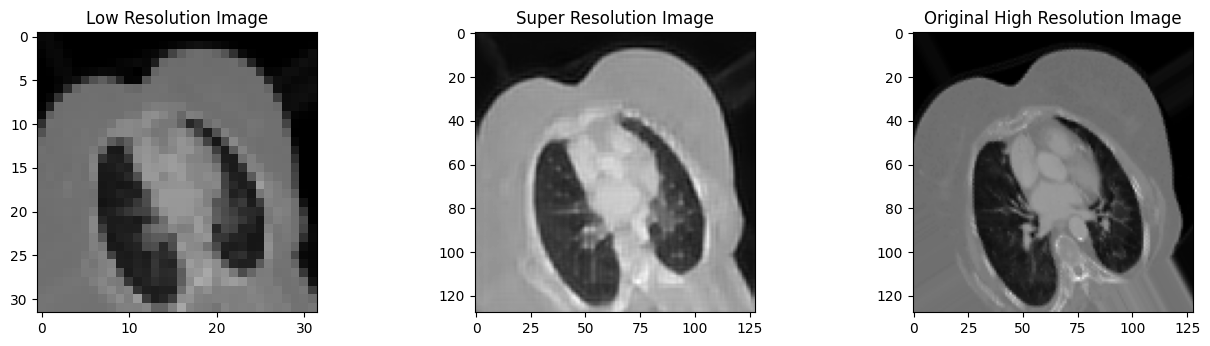

In [ ]:
from tensorflow.keras.models import load_model
from numpy.random import randint

[X1, X2] = [X_valid, y_valid]
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
gen_image = generator.predict(src_image)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Low Resolution Image')
plt.imshow(src_image[0,:,:,:], cmap = 'gray')
plt.subplot(232)
plt.title('Super Resolution Image')
plt.imshow(cv2.cvtColor(gen_image[0,:,:,:], cv2.COLOR_BGR2GRAY),cmap = 'gray')
plt.subplot(233)
plt.title('Original High Resolution Image')
plt.imshow(tar_image[0,:,:,:], cmap = 'gray')



plt.show()

1/1 [==============================] - 0s 25ms/step


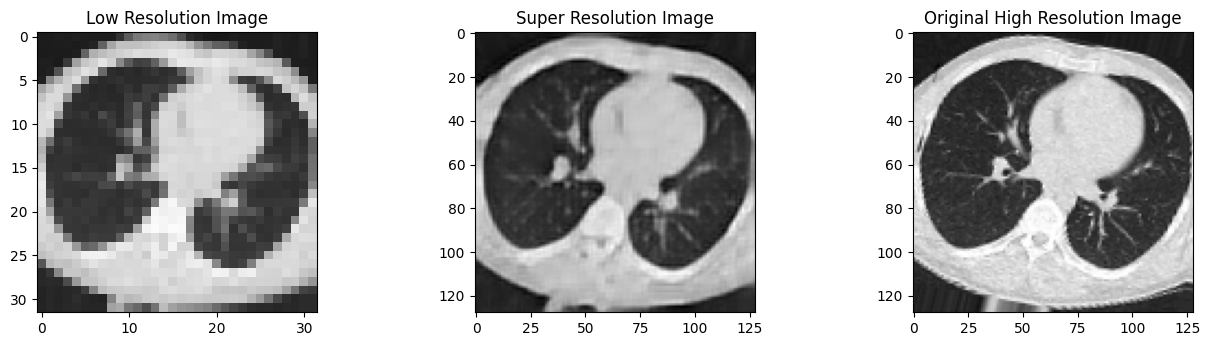

In [ ]:
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt

# Assuming you have a specific index you want to process
specific_index = 410 # Replace with the index you want to use

[X1, X2] = [X_valid, y_valid]
src_image, tar_image = X1[specific_index], X2[specific_index]

gen_image = generator.predict(np.expand_dims(src_image, axis=0))  # Expand dimensions to make it a batch of one

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Low Resolution Image')
plt.imshow(src_image, cmap='gray')
plt.subplot(232)
plt.title('Super Resolution Image')
plt.imshow(cv2.cvtColor(gen_image[0], cv2.COLOR_BGR2GRAY), cmap='gray')
plt.subplot(233)
plt.title('Original High Resolution Image')
plt.imshow(tar_image, cmap='gray')
plt.show()


In [ ]:
src_image

array([[[ 28,  28,  28],
        [ 28,  28,  28],
        [ 31,  31,  31],
        ...,
        [ 28,  28,  28],
        [ 34,  34,  34],
        [ 28,  28,  28]],

       [[ 28,  28,  28],
        [ 28,  28,  28],
        [ 29,  29,  29],
        ...,
        [ 29,  29,  29],
        [ 34,  34,  34],
        [ 27,  27,  27]],

       [[ 27,  27,  27],
        [ 28,  28,  28],
        [ 28,  28,  28],
        ...,
        [ 30,  30,  30],
        [ 33,  33,  33],
        [ 28,  28,  28]],

       ...,

       [[ 35,  35,  35],
        [ 39,  39,  39],
        [ 37,  37,  37],
        ...,
        [116, 116, 116],
        [ 67,  67,  67],
        [ 59,  59,  59]],

       [[ 35,  35,  35],
        [ 40,  40,  40],
        [ 36,  36,  36],
        ...,
        [ 38,  38,  38],
        [ 43,  43,  43],
        [ 43,  43,  43]],

       [[ 35,  35,  35],
        [ 40,  40,  40],
        [ 37,  37,  37],
        ...,
        [ 39,  39,  39],
        [ 43,  43,  43],
        [ 43,  43,  43]]

In [ ]:
from PIL import Image
F = cv2.resize(src_image, (128,128))
F.size
F.shape

(128, 128, 3)

In [ ]:
G1 = np.array(G).reshape(-1, 32, 32, 3)

NameError: ignored

In [ ]:
gen_image.reshape(128,128,3)

array([[[ 3.81838858e-01,  5.31591773e-01,  9.46226537e-01],
        [-7.55796373e-01, -2.69331574e-01,  9.74124670e-03],
        [ 8.97270888e-02,  2.24839568e-01,  6.23485982e-01],
        ...,
        [ 4.68973875e-01,  4.73695725e-01,  8.55300188e-01],
        [-1.14890480e+00, -5.24439454e-01, -5.52423060e-01],
        [-2.05752149e-01,  9.87832248e-02,  2.68461764e-01]],

       [[-1.24932244e-01,  3.11951041e-01,  6.86922491e-01],
        [-1.13138771e+00, -2.48982072e-01, -1.23649180e-01],
        [ 3.49092543e-01,  8.16542983e-01,  1.01321650e+00],
        ...,
        [ 3.36713135e-01,  7.01514423e-01,  6.36240005e-01],
        [-1.08773935e+00, -2.03182548e-01, -3.66645575e-01],
        [-8.55563104e-01, -2.82439709e-01,  7.84677863e-02]],

       [[-4.30639207e-01, -1.02648377e-01,  2.86550939e-01],
        [-6.47702157e-01, -9.37334299e-02,  3.96303535e-02],
        [ 6.75769866e-01,  9.46917892e-01,  1.18595552e+00],
        ...,
        [ 5.44735074e-01,  6.74910128e-01,

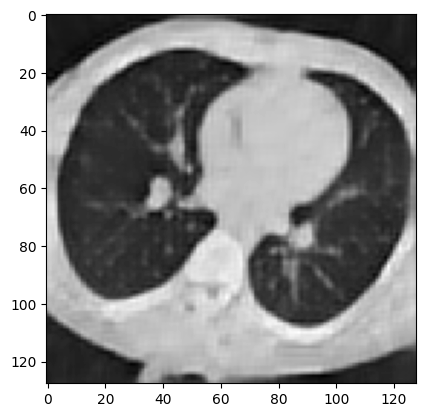

In [ ]:
plt.imshow(cv2.cvtColor(gen_image[0,:,:,:], cv2.COLOR_BGR2GRAY),cmap = 'gray')

In [ ]:
src_image.shape

(32, 32, 3)

In [ ]:
import cv2
import numpy as np
import math

def calculate_psnr(image_path_gen, image_path_ref):
    # Load the images
    gen_gray= image_path_gen
    ref_gray = image_path_ref

    # Calculate MSE
    mse = np.mean((gen_gray - ref_gray) ** 2)

    # Calculate PSNR
    psnr = 10 * math.log10((255**2) / mse)

    return psnr

psnr_value = calculate_psnr(gen_image, F)
print(f"PSNR: {psnr_value} dB")


PSNR: 20.341669457102913 dB


In [ ]:
import cv2
import numpy as np

# Load the two images you want to compare
image1 = F # Replace with the path to your first image
image2 = gen_image # Replace with the path to your second image

# Ensure the images have the same dimensions (resize if needed)
#i#f image1.shape != image2.shape:
 #   image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))

# Define constants for SSIM calculation
C1 = (0.01 * 255) ** 2
C2 = (0.03 * 255) ** 2

# Compute the mean of the images
mu1 = np.mean(image1)
mu2 = np.mean(image2)

# Compute the variance of the images
var1 = np.var(image1)
var2 = np.var(image2)

# Compute the covariance
covar12 = np.cov(image1.flatten(), image2.flatten())[0, 1]

# Compute SSIM
numerator = (2 * mu1 * mu2 + C1) * (2 * covar12 + C2)
denominator = (mu1 ** 2 + mu2 ** 2 + C1) * (var1 + var2 + C2)
ssim_value = numerator / denominator

# Print the SSIM value
print(f"SSIM Value: {ssim_value:.2f}")

SSIM Value: 0.96
